# Environmental Analytics London Ground Transport Analysis for a Net Zero Economy

The file 'Copy of LAEI-2019-Emissions-Summary-including-Forecast.xlsx' is too large to upload to GitHub. It is sourced from https://data.london.gov.uk/dataset/london-atmospheric-emissions-inventory--laei--2019. GitHub repository: GitHub Repository: https://github.com/HarveyDudley/Environmental-Analytics-Report

In [480]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotnine
from plotnine import *
import statsmodels.api as sma
from sklearn import *
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [481]:
#fist data source - LEGGI 2022

Leggi = pd.read_excel('Leggi.xlsx', 1, header=11)

In [482]:
print(Leggi)

    Unnamed: 0                                         Unnamed: 1    1990  \
0          NaN                                 I. ENERGY DOMESTIC       E   
1          NaN                                                Gas     NaN   
2          NaN                                        Electricity     NaN   
3          NaN                                              Other     NaN   
4          NaN                                               Coal     NaN   
..         ...                                                ...     ...   
91         NaN                                           Shipping     NaN   
92         NaN                                          SUB-TOTAL     NaN   
93         NaN                                              TOTAL  160431   
94         NaN                                                NaN     NaN   
95         NaN  1. Energy consumption calculated for road tran...     NaN   

             2000           2001           2002          2003           200

In [483]:
#dropping first 25 rows and resetting index
Leggi.drop(Leggi.head(25).index,inplace=True)
Leggi.reset_index(drop=True, inplace=True)

In [484]:
print(Leggi.head(15))

    Unnamed: 0                          Unnamed: 1      1990      2000  \
0          NaN                       II. TRANSPORT         E         C   
1          NaN       Road transport (non electric)  7.219858     6.623   
2          NaN                         Rail_diesel  1.386786  0.243225   
3          NaN                       Rail_electric       NaN  0.978683   
4          NaN           Road transport (electric)       NaN       NaN   
5          NaN                            Aviation  0.857653     0.856   
6          NaN                            Shipping      0.01     0.012   
7          NaN                                NRMM       NaN       NaN   
8          NaN                           SUB-TOTAL  9.474297  8.712908   
9          NaN                 Reduction from 2000       NaN       NaN   
10         NaN                          III. WASTE       NaN       NaN   
11         NaN                Solid waste disposal       NaN       NaN   
12         NaN       Biological treatm

In [485]:
Leggi.drop(Leggi.index[10:], inplace=True)

In [486]:
print(Leggi.head(15))

   Unnamed: 0                     Unnamed: 1      1990      2000      2001  \
0         NaN                  II. TRANSPORT         E         C         C   
1         NaN  Road transport (non electric)  7.219858     6.623  7.001864   
2         NaN                    Rail_diesel  1.386786  0.243225  0.700161   
3         NaN                  Rail_electric       NaN  0.978683  0.840447   
4         NaN      Road transport (electric)       NaN       NaN       NaN   
5         NaN                       Aviation  0.857653     0.856  0.761374   
6         NaN                       Shipping      0.01     0.012  0.005131   
7         NaN                           NRMM       NaN       NaN       NaN   
8         NaN                      SUB-TOTAL  9.474297  8.712908  9.308978   
9         NaN            Reduction from 2000       NaN       NaN  0.068412   

       2002       2003      2004      2005      2006  ...      2016      2017  \
0         E          C         C         C         C  ...   

In [487]:
df = Leggi.copy()

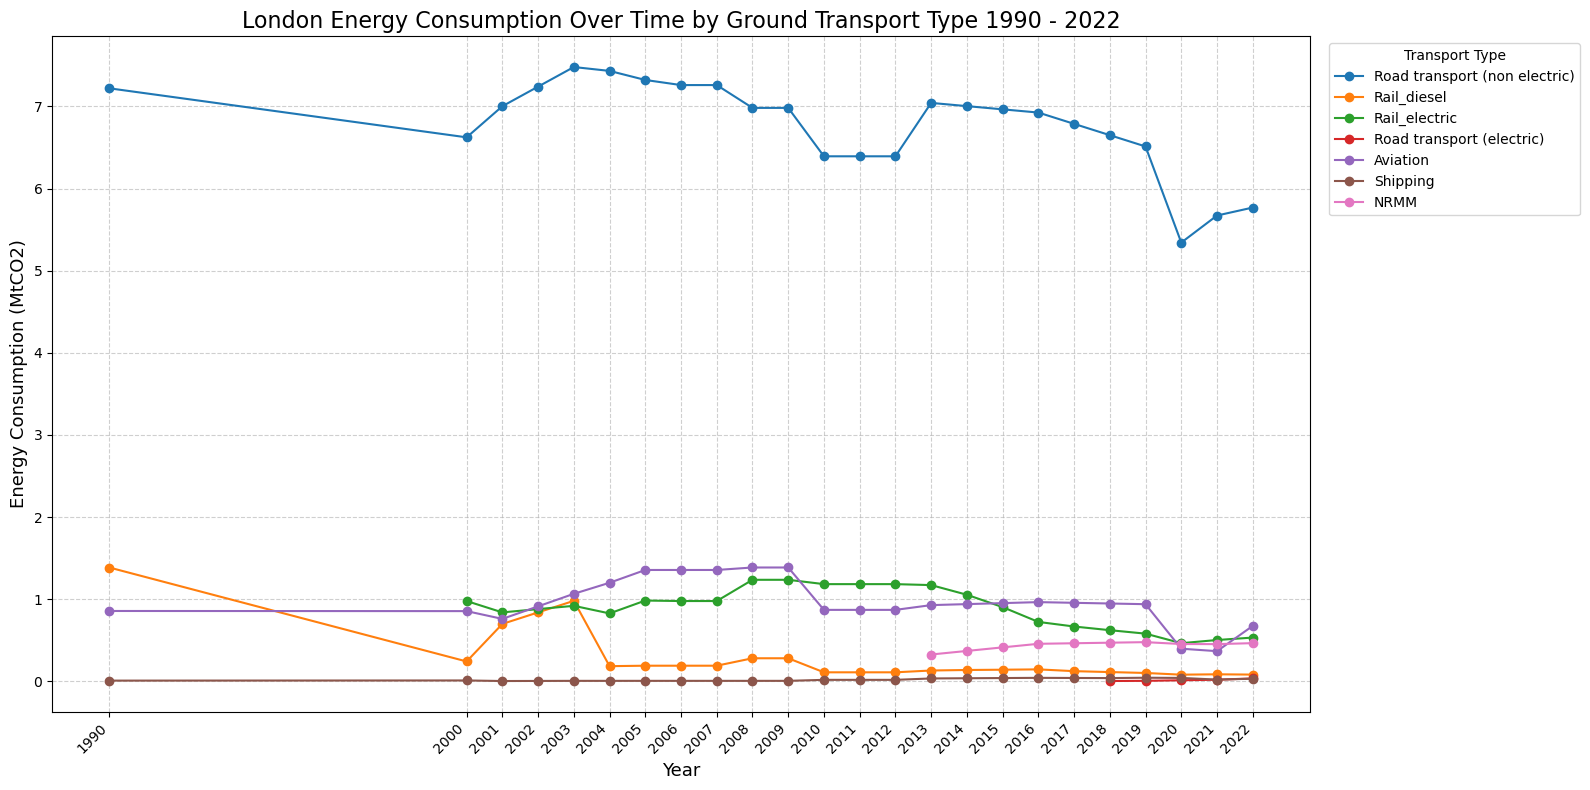

In [488]:
plt.figure(figsize=(16, 8))

# extracting the years from the column names
years = df.columns[2:-2]
numeric_years = pd.to_numeric(years, errors='coerce')
valid_years_indices = numeric_years.notna()
valid_years = years[valid_years_indices]

# Converting valid_years to numeric for plotting
valid_years = pd.to_numeric(valid_years)

# Plotting each transport type
for i in range(len(df) - 2):
    transport_name = df.iloc[i, 1]
    data_row = df.iloc[i, 2:-2]

    # Cleaning and converting to numeric 
    valid_data = pd.to_numeric(data_row[valid_years_indices], errors='coerce')

    if valid_data.notna().any():
        plt.plot(valid_years, valid_data, marker='o', label=transport_name)

# Plotting
plt.title("London Energy Consumption Over Time by Ground Transport Type 1990 - 2022", fontsize=16)
plt.xlabel("Year", fontsize=13)
plt.ylabel("Energy Consumption (MtCO2)", fontsize=13)
plt.xticks(valid_years, rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Transport Type", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

In [489]:
##2 borough transport energy consumption

borough =pd.read_excel('Leggi.xlsx', 2, header = 7)


In [490]:
print(borough.head(15))

    Unnamed: 0              Unnamed: 1   Electricity           Gas  \
0          NaN                    Year  2.022000e+03  2.022000e+03   
1          NaN    Barking and Dagenham  2.345045e+08  6.635707e+08   
2          NaN                  Barnet  5.799499e+08  1.887362e+09   
3          NaN                  Bexley  3.266702e+08  1.027856e+09   
4          NaN                   Brent  3.985285e+08  1.340074e+09   
5          NaN                 Bromley  4.839316e+08  1.712315e+09   
6          NaN                  Camden  3.130512e+08  8.297991e+08   
7          NaN          City of London  2.563013e+07  2.582534e+07   
8          NaN                 Croydon  5.305595e+08  1.771475e+09   
9          NaN                  Ealing  4.435288e+08  1.444668e+09   
10         NaN                 Enfield  4.338978e+08  1.358339e+09   
11         NaN               Greenwich  3.446273e+08  9.718361e+08   
12         NaN                 Hackney  3.168965e+08  8.428559e+08   
13         NaN  Hamm

In [491]:
borough_cleaned = pd.concat([
    borough.iloc[:, [1]],
    borough.iloc[:, 15:-2]
], axis=1)

In [492]:
borough_cleaned = borough_cleaned.rename(columns={"Unnamed: 1": "Borough"})

In [493]:
borough_cleaned = borough_cleaned.drop(index=borough_cleaned.index[33:39])
borough_cleaned = borough_cleaned.drop(index=borough_cleaned.index[0])

In [494]:
print(borough_cleaned)

                   Borough      Aviation      Shipping  Railways_Diesel  \
1     Barking and Dagenham  0.000000e+00  3.915136e+06     1.027288e+07   
2                   Barnet  4.730860e+05  0.000000e+00     3.826869e+07   
3                   Bexley  2.084628e+07  1.912897e+06     4.703977e+06   
4                    Brent  7.957394e+05  0.000000e+00     4.631887e+07   
5                  Bromley  2.296881e+07  0.000000e+00     5.728550e+06   
6                   Camden  0.000000e+00  0.000000e+00     4.599112e+07   
7           City of London  7.339894e+05  8.372527e+06     3.278041e+04   
8                  Croydon  1.065532e+06  0.000000e+00     1.474035e+07   
9                   Ealing  0.000000e+00  0.000000e+00     1.703526e+07   
10                 Enfield  7.431821e+05  0.000000e+00     4.775559e+06   
11               Greenwich  1.107054e+07  4.418107e+06     3.040520e+06   
12                 Hackney  0.000000e+00  0.000000e+00     6.560167e+06   
13  Hammersmith and Fulha

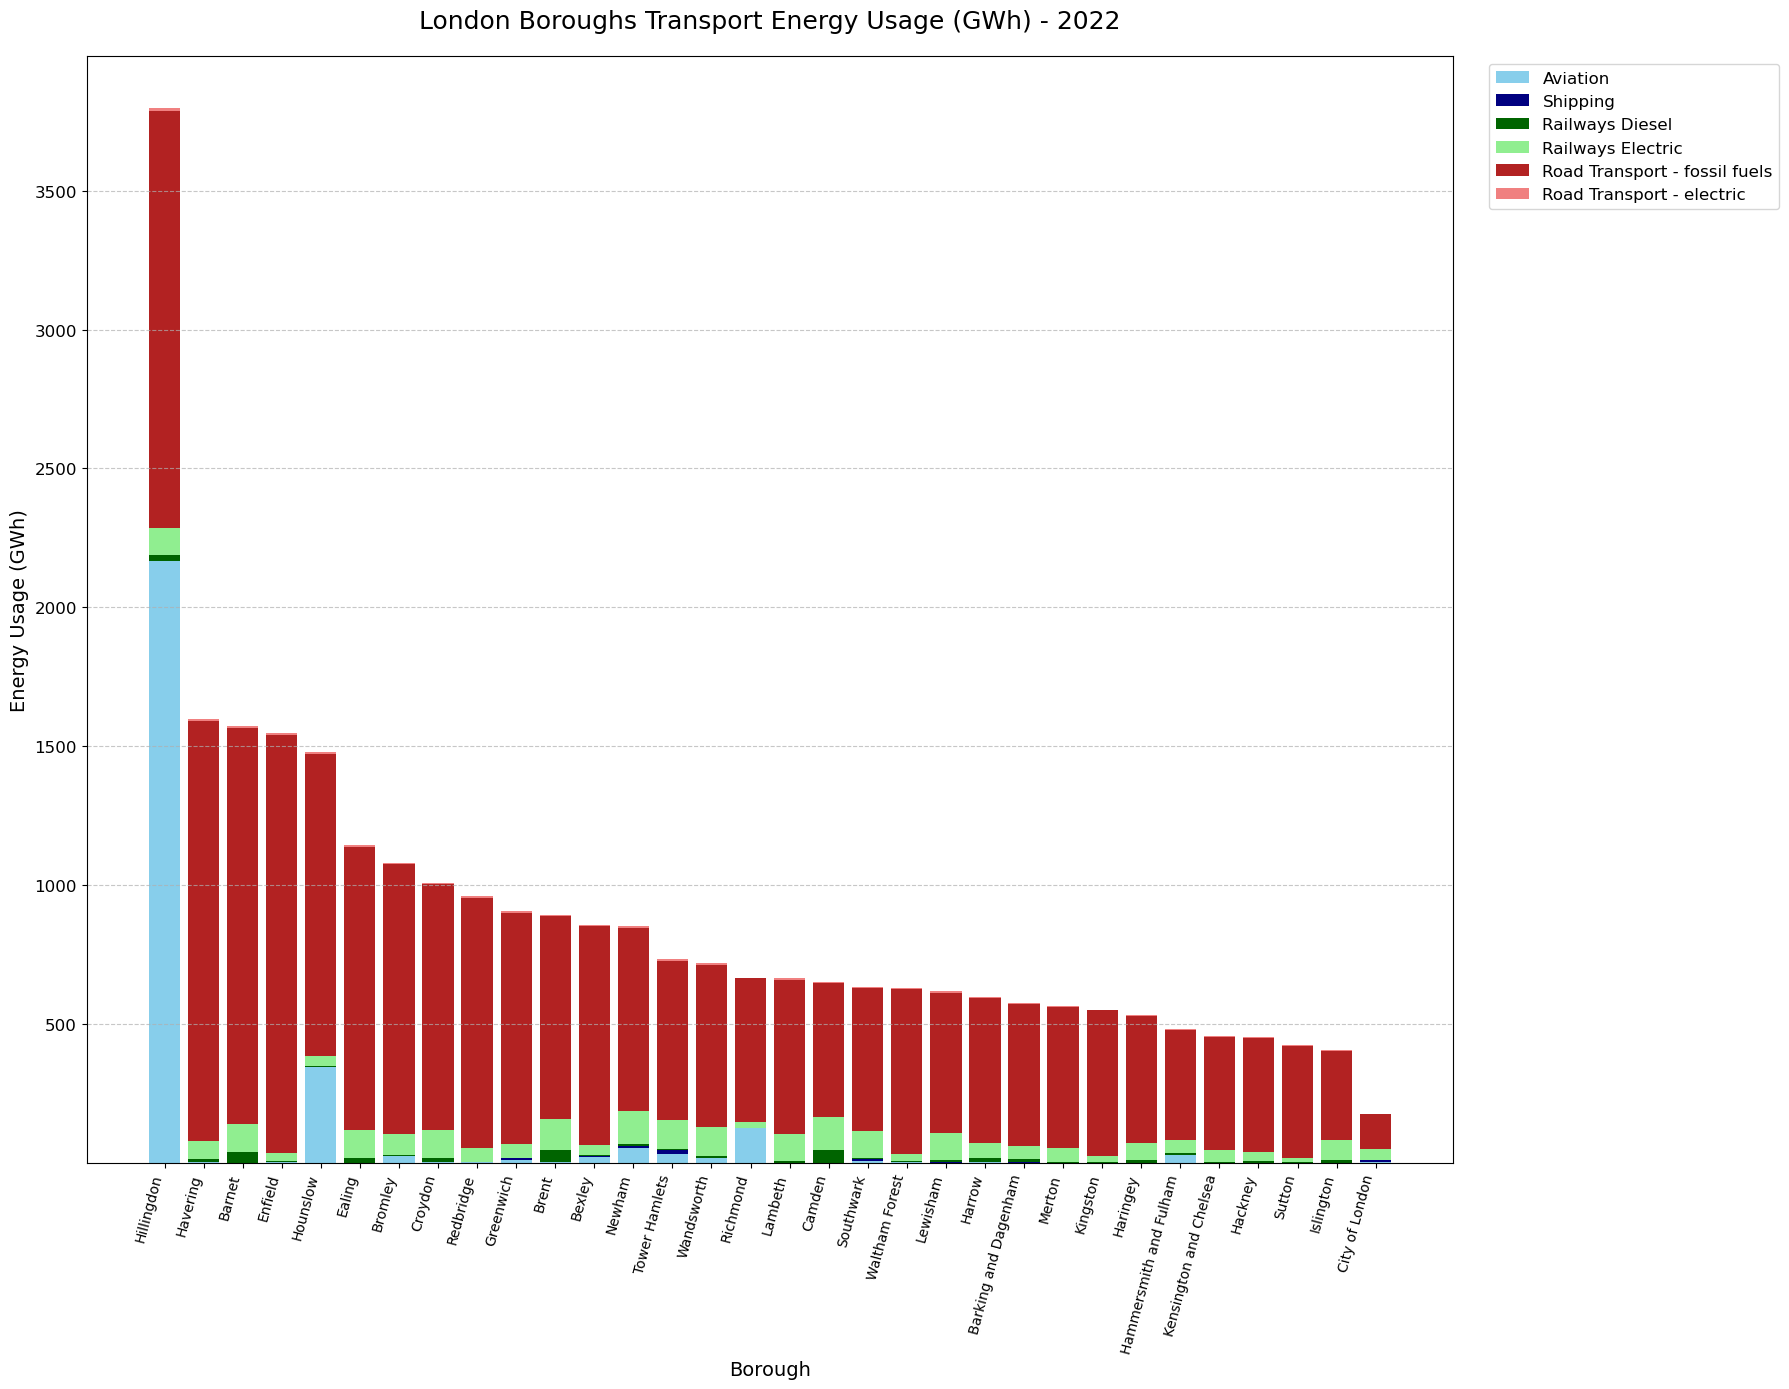

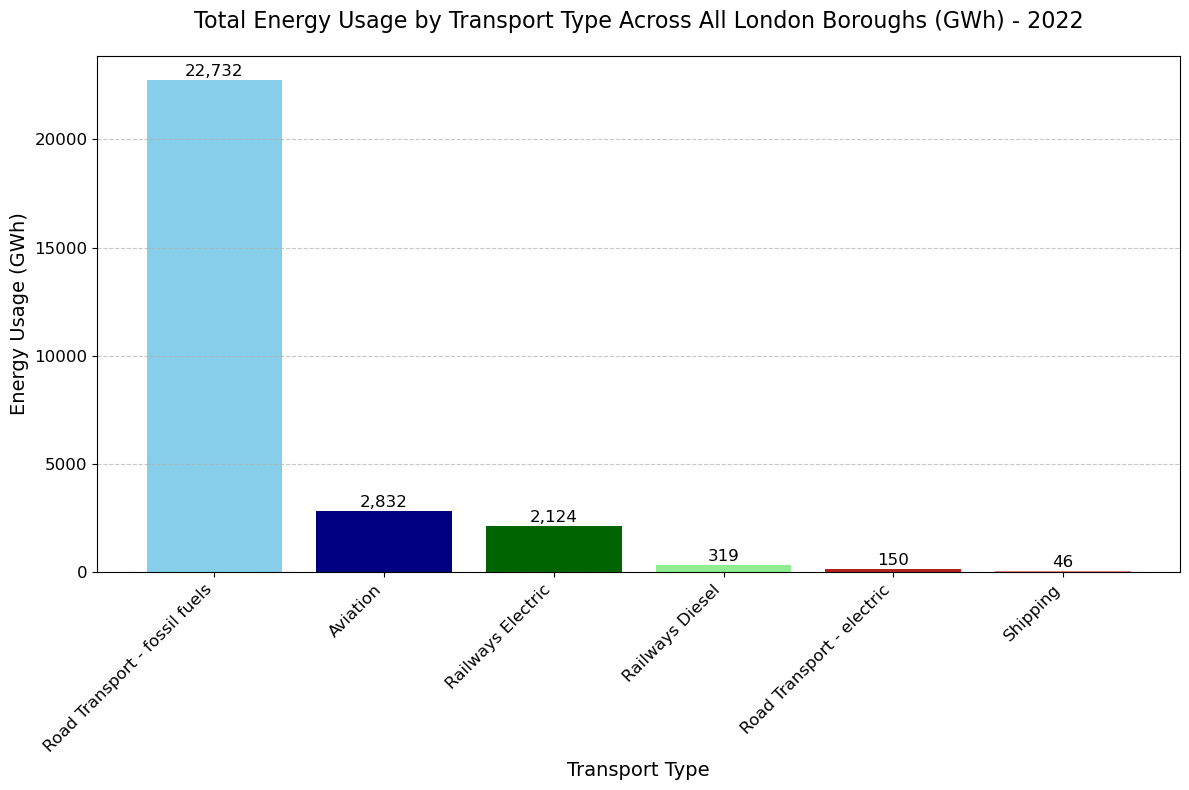

In [495]:
df = pd.DataFrame(borough_cleaned)

# Converting to Gwh
energy_columns = df.columns[1:]
for col in energy_columns:
    df[col] = df[col] / 1e6  

# Calculating total energy usage
df['Total'] = df[energy_columns].sum(axis=1)

# Sorting boroughs by total energy usage
df = df.sort_values('Total', ascending=False)

# Resetting index 
df = df.reset_index(drop=True)

# Setting figure size
plt.figure(figsize=(18, 14))

# Setting positions for bars
boroughs = df['Borough'].values
positions = np.arange(len(boroughs))
width = 0.8

# Creating stacked bars for each transport type
bottom = np.zeros(len(boroughs))
colors = ['skyblue', 'navy', 'darkgreen', 'lightgreen', 'firebrick', 'lightcoral']
transport_types = energy_columns

for i, col in enumerate(transport_types):
    plt.bar(positions, df[col], width, bottom=bottom, 
            label=col.replace('_', ' '), color=colors[i % len(colors)])
    bottom += df[col].values

#Plotting
plt.title('London Boroughs Transport Energy Usage (GWh) - 2022', fontsize=18, pad=20)
plt.xlabel('Borough', fontsize=14)
plt.ylabel('Energy Usage (GWh)', fontsize=14)
plt.xticks(positions, boroughs, rotation=75, ha='right', fontsize=10)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12, bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Creating a second chart showing the breakdown by transport type
transport_totals = df[energy_columns].sum()
transport_totals = transport_totals.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
bars = plt.bar(transport_totals.index.str.replace('_', ' '), transport_totals, color=colors)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=12)

plt.title('Total Energy Usage by Transport Type Across All London Boroughs (GWh) - 2022', fontsize=16, pad=20)
plt.xlabel('Transport Type', fontsize=14)
plt.ylabel('Energy Usage (GWh)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

In [496]:
#third graph - borough GHG levels
borough_ghg =pd.read_excel('Leggi.xlsx', 3, header = 7)


In [497]:
borough_ghg = borough_ghg.rename(columns={"Unnamed: 1": "Borough"})

In [498]:
borough_ghg = pd.concat([
    borough_ghg.iloc[:, [1]],
    borough_ghg.iloc[:, 15:-10]
], axis=1)
borough_ghg = borough_ghg.drop(index=borough_ghg.index[0])
borough_ghg = borough_ghg.drop(index=borough_ghg.index[33:39])

In [499]:
print(borough_ghg)

                   Borough    Aviation  Shipping  Railways diesel  \
1     Barking and Dagenham    0.000000  2.475820         2.637972   
2                   Barnet    0.116194  0.000000         9.827017   
3                   Bexley    5.115916  1.209944         1.207934   
4                    Brent    0.195349  0.000000        11.894221   
5                  Bromley    5.654063  0.000000         1.471034   
6                   Camden    0.000000  0.000000        11.810058   
7           City of London    0.180181  5.293918         0.008418   
8                  Croydon    0.261480  0.000000         3.785175   
9                   Ealing    0.000000  0.000000         4.374485   
10                 Enfield    0.183017  0.000000         1.226316   
11               Greenwich    2.717168  2.793562         0.780775   
12                 Hackney    0.000000  0.000000         1.684585   
13  Hammersmith and Fulham    6.518675  0.004385         1.675577   
14                Haringey    0.00

C:\Users\harve\AppData\Local\Temp\ipykernel_15968\2955875424.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




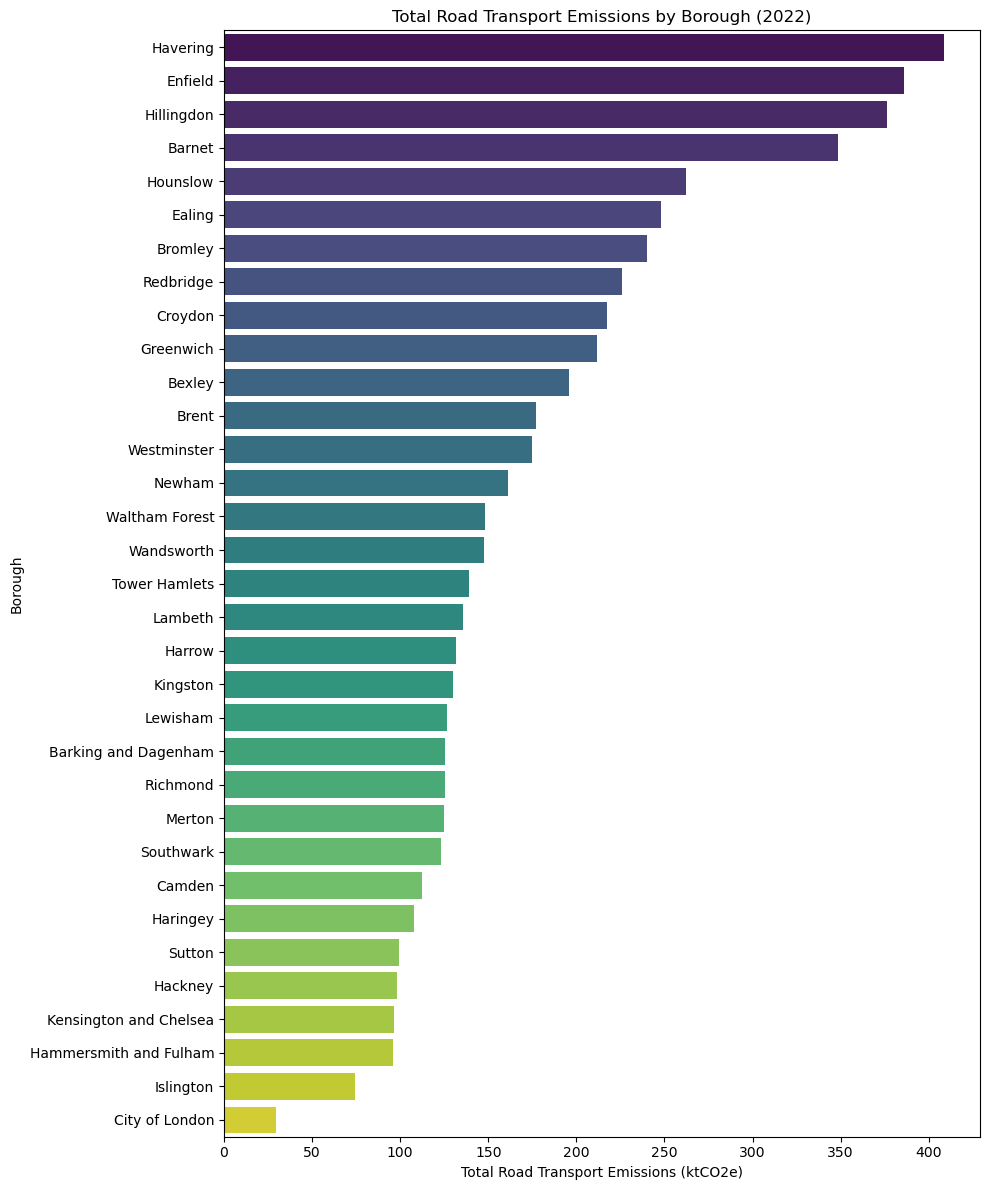

In [500]:
#Graph for road transport emissions
df_plot = borough_ghg.copy()
plt.figure(figsize=(10, 12))
df_plot['Total Road Emissions'] = df_plot['Road transport - fossil fuels'].fillna(0) + df_plot['Road transport - electric'].fillna(0)
sns.barplot(x='Total Road Emissions', y='Borough', data=df_plot.sort_values(by='Total Road Emissions', ascending=False), palette='viridis')
plt.xlabel('Total Road Transport Emissions (ktCO2e)')
plt.ylabel('Borough')
plt.title('Total Road Transport Emissions by Borough (2022)')
plt.tight_layout()
plt.show()


C:\Users\harve\AppData\Local\Temp\ipykernel_15968\1675562279.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




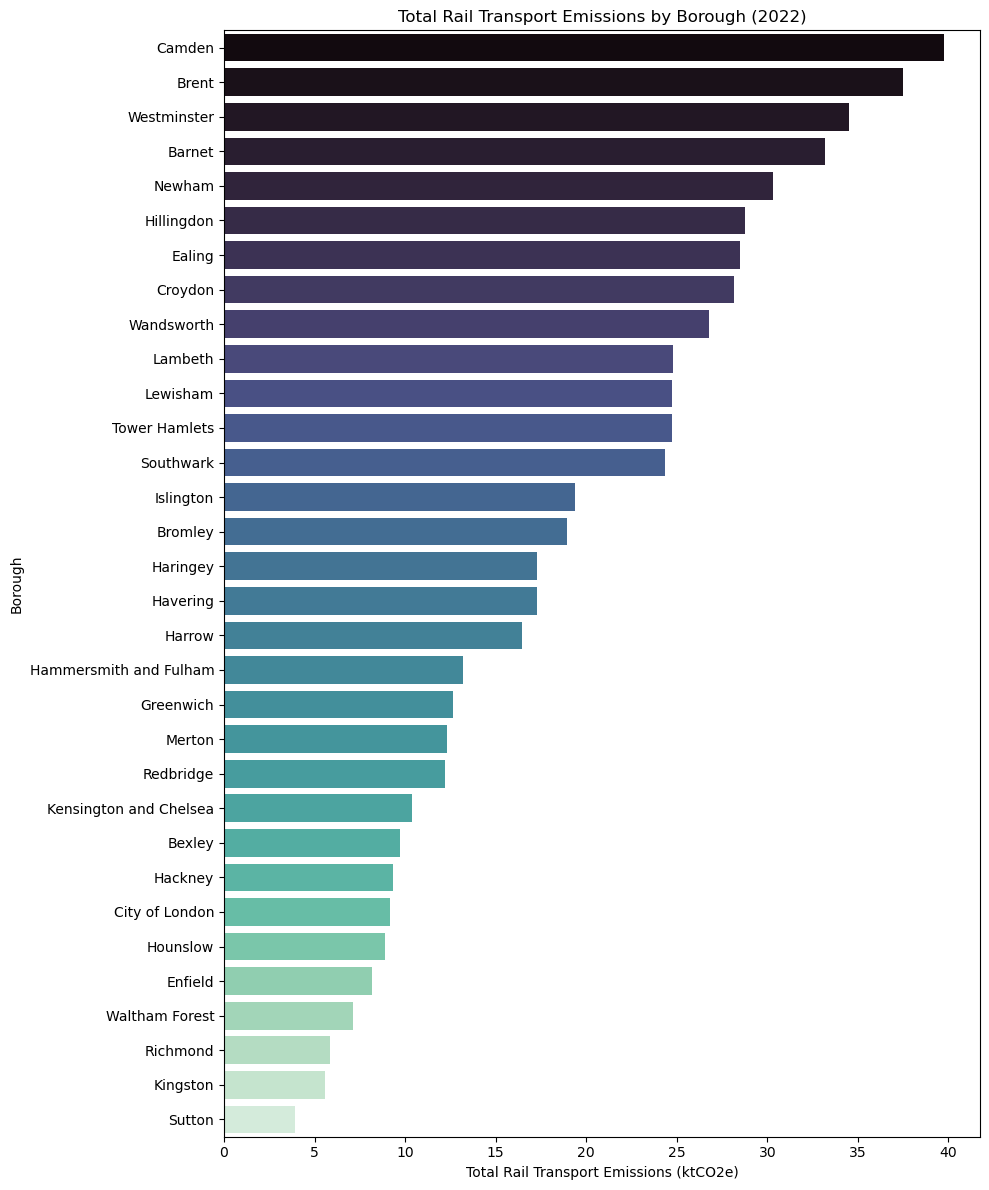

In [501]:
df_rail = borough_ghg.iloc[1:].dropna(subset=['Borough', 'Railways diesel', 'Railways electric'])
df_rail['Total Rail Emissions'] = df_rail['Railways diesel'].fillna(0) + df_rail['Railways electric'].fillna(0)

plt.figure(figsize=(10, 12))
sns.barplot(x='Total Rail Emissions', y='Borough', data=df_rail.sort_values(by='Total Rail Emissions', ascending=False), palette='mako')
plt.xlabel('Total Rail Transport Emissions (ktCO2e)')
plt.ylabel('Borough')
plt.title('Total Rail Transport Emissions by Borough (2022)')
plt.tight_layout()
plt.show()

C:\Users\harve\AppData\Local\Temp\ipykernel_15968\1310976135.py:29: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



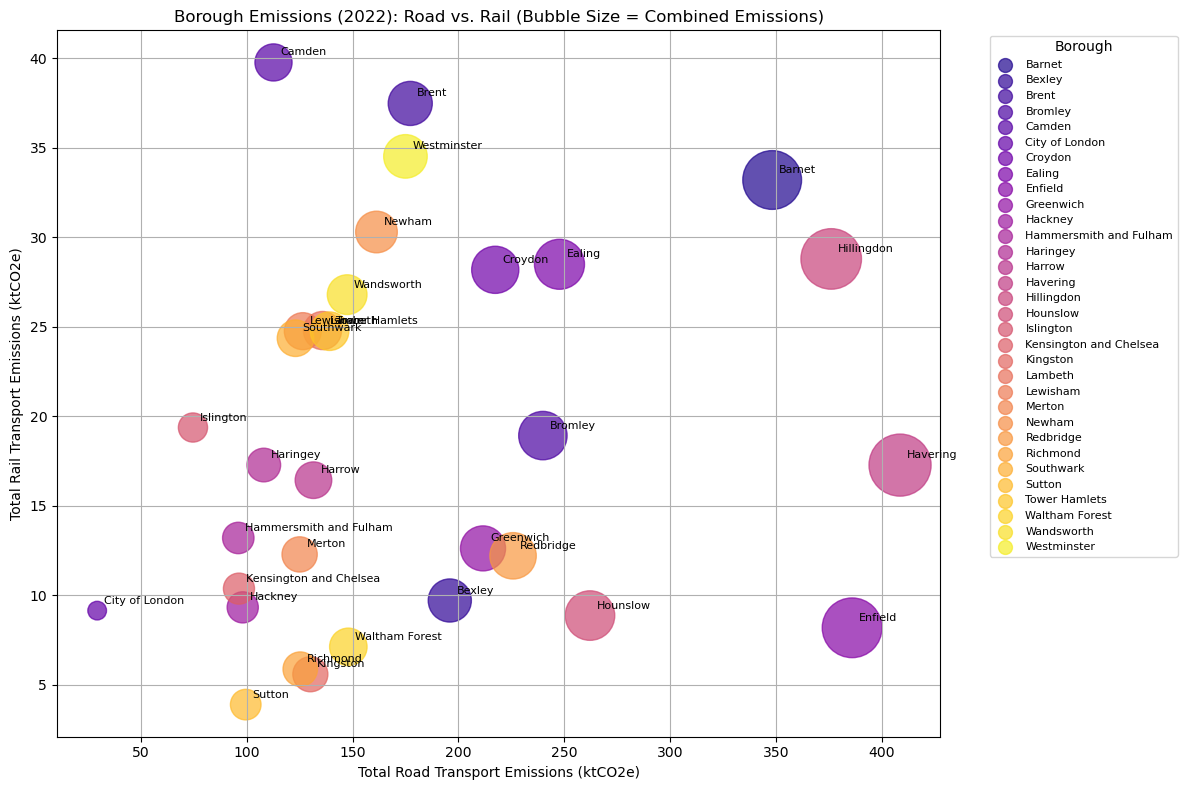

In [502]:
df_combined = borough_ghg.iloc[1:].dropna(subset=['Borough', 'Railways diesel', 'Railways electric', 'Road transport - fossil fuels', 'Road transport - electric'])

df_combined['Total Road Emissions'] = df_combined['Road transport - fossil fuels'].fillna(0) + df_combined['Road transport - electric'].fillna(0)
df_combined['Total Rail Emissions'] = df_combined['Railways diesel'].fillna(0) + df_combined['Railways electric'].fillna(0)

df_combined['Combined Emissions'] = df_combined['Total Road Emissions'] + df_combined['Total Rail Emissions']
size_factor = 2000 
df_combined['Bubble Size'] = df_combined['Combined Emissions'] / df_combined['Combined Emissions'].max() * size_factor

plt.figure(figsize=(12, 8))

unique_boroughs = df_combined['Borough'].unique()
borough_colors = sns.color_palette("plasma", n_colors=len(unique_boroughs))
borough_color_map = dict(zip(unique_boroughs, borough_colors))

scatter = plt.scatter(
    df_combined['Total Road Emissions'],
    df_combined['Total Rail Emissions'],
    s=df_combined['Bubble Size'],
    c=[borough_color_map[borough] for borough in df_combined['Borough']],
    alpha=0.7,
    label='Boroughs'
)

for i, row in df_combined.iterrows():
    plt.annotate(row['Borough'], (row['Total Road Emissions'], row['Total Rail Emissions']),
                 textcoords="offset points", xytext=(5,5), ha='left', fontsize=8)

legend_handles = [plt.scatter([], [], s=100, c=color, alpha=0.7) for color in borough_colors]
plt.legend(legend_handles, unique_boroughs, title='Borough', scatterpoints=1, fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left') 

plt.xlabel('Total Road Transport Emissions (ktCO2e)')
plt.ylabel('Total Rail Transport Emissions (ktCO2e)')
plt.title('Borough Emissions (2022): Road vs. Rail (Bubble Size = Combined Emissions)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [503]:
df = pd.read_excel('tfl-journeys-type.xlsx', 1)

In [504]:
print(df.head(15))

   Period and Financial year  Reporting Period  Days in period  \
0                   01_10/11                 1              31   
1                   02_10/11                 2              28   
2                   03_10/11                 3              28   
3                   04_10/11                 4              28   
4                   05_10/11                 5              28   
5                   06_10/11                 6              28   
6                   07_10/11                 7              28   
7                   08_10/11                 8              28   
8                   09_10/11                 9              28   
9                   10_10/11                10              28   
10                  11_10/11                11              28   
11                  12_10/11                12              28   
12                  13_10/11                13              26   
13                  01_11/12                 1              30   
14        

In [505]:
df['Period beginning'] = pd.to_datetime(df['Period beginning'])
df['Period ending'] = pd.to_datetime(df['Period ending'])

In [506]:
journey_columns = ['Bus journeys (m)', 'Underground journeys (m)', 'Overground Journeys (m)']
df[journey_columns] = df[journey_columns].apply(pd.to_numeric, errors='coerce')

In [507]:
df.dropna(subset=journey_columns, inplace=True)


In [508]:
df['Year'] = df['Period beginning'].dt.year
df['Month'] = df['Period beginning'].dt.month
df['Days in period'] = pd.to_numeric(df['Days in period'], errors='coerce')

Bus Journey MSE: 830.74
Underground Journey MSE: 542.27
Overground Journey MSE: 11.40


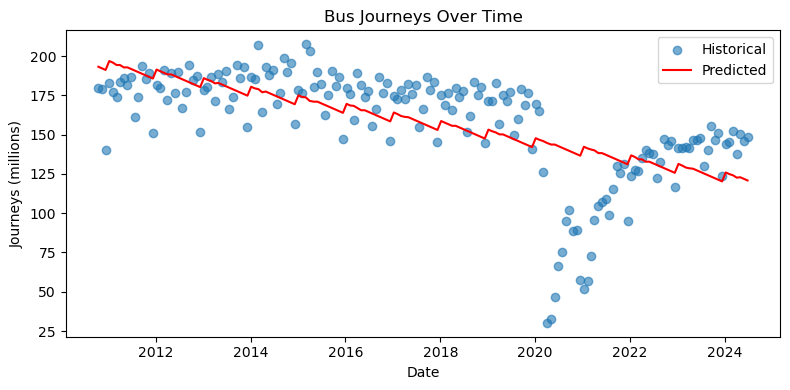

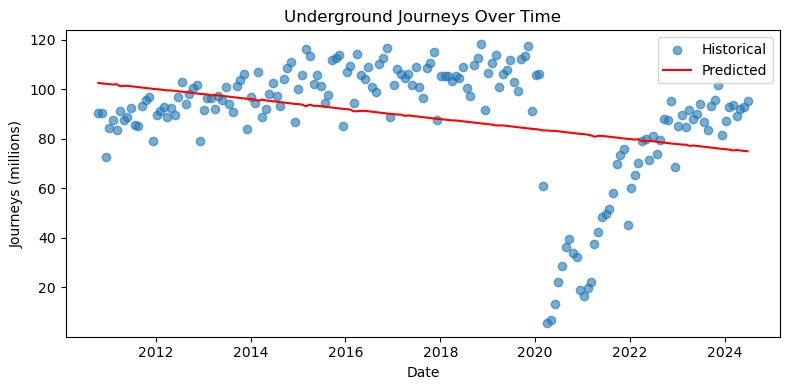

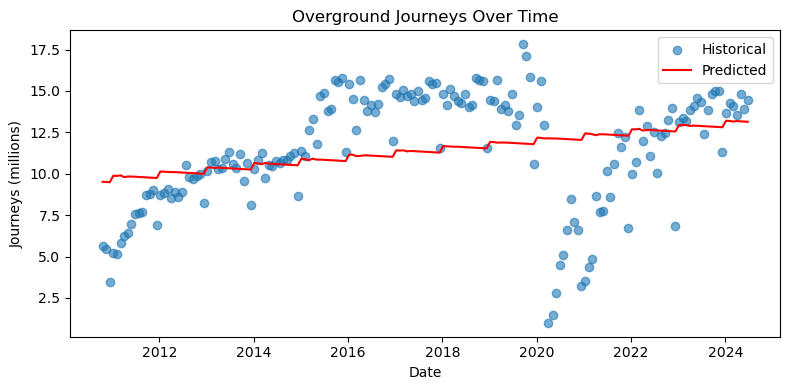

In [509]:
features = ['Year', 'Month', 'Days in period']
targets = {
    'Bus': 'Bus journeys (m)',
    'Underground': 'Underground journeys (m)',
    'Overground': 'Overground Journeys (m)'
}

models = {}
predictions = {}
scores = {}

for name, target in targets.items():
    X = df[features]
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    models[name] = model
    predictions[name] = y_pred
    scores[name] = mean_squared_error(y_test, y_pred)

    print(f"{name} Journey MSE: {scores[name]:.2f}")

for name, target in targets.items():
    plt.figure(figsize=(8, 4))
    plt.scatter(df['Period beginning'], df[target], label='Historical', alpha=0.6)
    df['Predicted ' + name] = models[name].predict(df[features])
    plt.plot(df['Period beginning'], df['Predicted ' + name], color='red', label='Predicted')
    plt.title(f"{name} Journeys Over Time")
    plt.xlabel("Date")
    plt.ylabel("Journeys (millions)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [510]:
df.set_index('Year', inplace=True)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1533.756, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1560.609, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1542.127, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1537.462, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1558.625, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1536.815, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1536.246, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1518.543, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1522.848, Time=0.07 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1520.458, Time=0.17 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1520.013, Time=0.12 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1505.670, Time=0.34 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=i

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



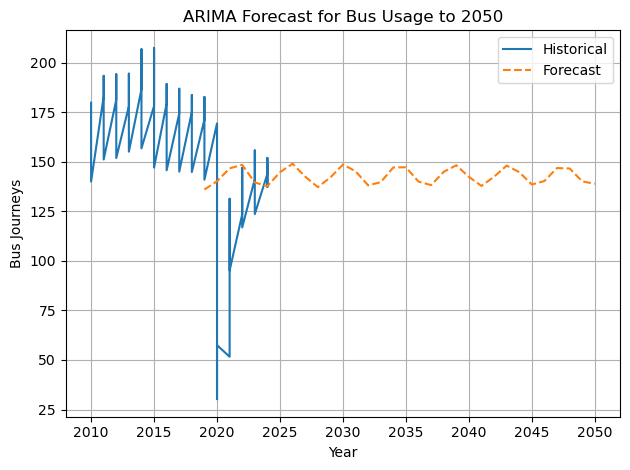

In [511]:
#Bus journeys initial ARIMA prediction
model = auto_arima(df['Bus journeys (m)'], seasonal=False, trace=True)
forecast = model.predict(n_periods=32)  

# Plot
future_years = np.arange(2019, 2051)
plt.plot(df.index, df['Bus journeys (m)'], label='Historical')
plt.plot(future_years, forecast, label='Forecast', linestyle='--')
plt.title("ARIMA Forecast for Bus Usage to 2050")
plt.xlabel("Year")
plt.ylabel("Bus Journeys")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [512]:
print(f"Shape of df: {df.shape}") 


Shape of df: (179, 16)


In [513]:
df_selected = df[['Bus journeys (m)', 'Underground journeys (m)', 'Overground Journeys (m)']]

In [514]:
model = VAR(df_selected)
lag_selection = model.select_order(maxlags=1)
print(lag_selection.summary())

results = model.fit(maxlags=1)
forecast = results.forecast(df_selected.values[-1:], steps=32)

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       12.66       12.72   3.157e+05       12.68
1      8.746*      8.961*      6288.*      8.833*
-------------------------------------------------


c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



In [515]:
df = pd.read_excel('tfl-journeys-type.xlsx', 1)

print(df.head())
print(df.info())

  Period and Financial year  Reporting Period  Days in period  \
0                  01_10/11                 1              31   
1                  02_10/11                 2              28   
2                  03_10/11                 3              28   
3                  04_10/11                 4              28   
4                  05_10/11                 5              28   

  Period beginning Period ending  Bus journeys (m)  Underground journeys (m)  \
0       2010-04-01    2010-05-01        189.114661                 90.545391   
1       2010-05-02    2010-05-29        181.604792                 84.517504   
2       2010-05-30    2010-06-26        175.883173                 84.286014   
3       2010-06-27    2010-07-24        183.428052                 86.479612   
4       2010-07-25    2010-08-21        160.422767                 82.895287   

   DLR Journeys (m)  Tram Journeys (m)  Overground Journeys (m)  \
0          6.291000           2.287785                      N

In [516]:
df['Period ending'] = pd.to_datetime(df['Period ending'], format='%d-%m-%Y')

df.isnull().sum()

df = df.fillna(method='ffill')

C:\Users\harve\AppData\Local\Temp\ipykernel_15968\1507112342.py:5: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



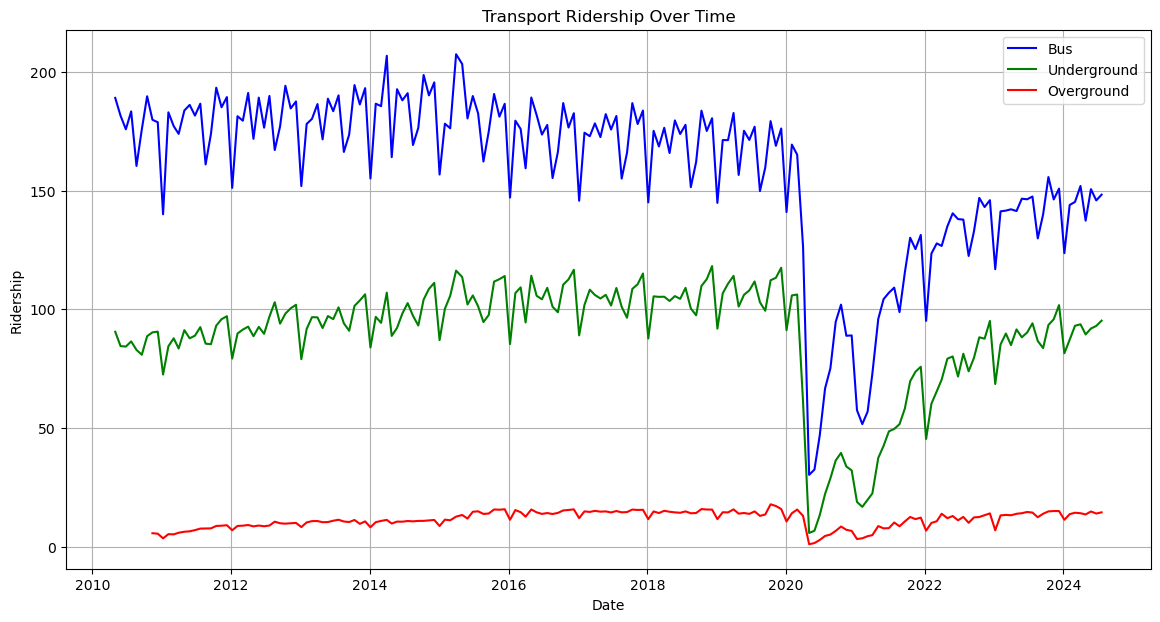

In [517]:
plt.figure(figsize=(14, 7))
plt.plot(df['Period ending'], df['Bus journeys (m)'], label='Bus', color='blue')
plt.plot(df['Period ending'], df['Underground journeys (m)'], label='Underground', color='green')
plt.plot(df['Period ending'], df['Overground Journeys (m)'], label='Overground', color='red')

plt.title('Transport Ridership Over Time')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date inde

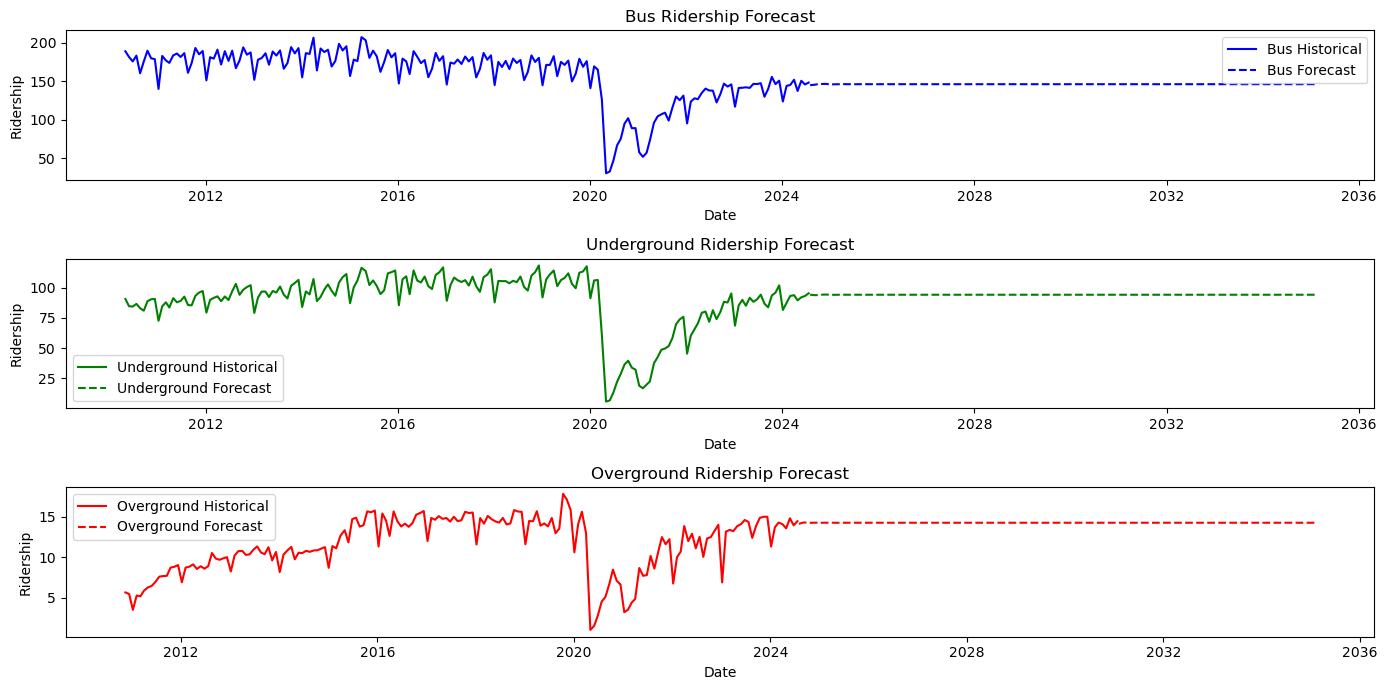

In [518]:
# Preparing the data for ARIMA analysis
df_bus = df[['Period ending', 'Bus journeys (m)']].rename(columns={'Period ending': 'ds', 'Bus journeys (m)': 'y'})
df_underground = df[['Period ending', 'Underground journeys (m)']].rename(columns={'Period ending': 'ds', 'Underground journeys (m)': 'y'})
df_overground = df[['Period ending', 'Overground Journeys (m)']].rename(columns={'Period ending': 'ds', 'Overground Journeys (m)': 'y'})

# Setting the date column as the index
df_bus.set_index('ds', inplace=True)
df_underground.set_index('ds', inplace=True)
df_overground.set_index('ds', inplace=True)

# Fit ARIMA model for Bus
model_bus = ARIMA(df_bus['y'], order=(5, 1, 0)) 
model_bus_fit = model_bus.fit()

# Fit ARIMA model for Underground
model_underground = ARIMA(df_underground['y'], order=(5, 1, 0))
model_underground_fit = model_underground.fit()

# Fit ARIMA model for Overground
model_overground = ARIMA(df_overground['y'], order=(5, 1, 0))
model_overground_fit = model_overground.fit()

# Make future predictions for 2050
forecast_bus = model_bus_fit.forecast(steps=(2050 - df_bus.index.year.max()) * 12)
forecast_underground = model_underground_fit.forecast(steps=(2050 - df_underground.index.year.max()) * 12)
forecast_overground = model_overground_fit.forecast(steps=(2050 - df_overground.index.year.max()) * 12)

#Creating future dates
future_dates = pd.date_range(start=df_bus.index[-1] + pd.Timedelta(days=1), periods=len(forecast_bus), freq='M')

# Plotting the forecasts
plt.figure(figsize=(14, 7))

# Plotting Bus forecast
plt.subplot(3, 1, 1)
plt.plot(df_bus.index, df_bus['y'], label='Bus Historical', color='blue')
plt.plot(future_dates, forecast_bus, label='Bus Forecast', color='blue', linestyle='--')
plt.title('Bus Ridership Forecast')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.legend()

# Plotting Underground forecast
plt.subplot(3, 1, 2)
plt.plot(df_underground.index, df_underground['y'], label='Underground Historical', color='green')
plt.plot(future_dates, forecast_underground, label='Underground Forecast', color='green', linestyle='--')
plt.title('Underground Ridership Forecast')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.legend()

# Plotting Overground forecast
plt.subplot(3, 1, 3)
plt.plot(df_overground.index, df_overground['y'], label='Overground Historical', color='red')
plt.plot(future_dates, forecast_overground, label='Overground Forecast', color='red', linestyle='--')
plt.title('Overground Ridership Forecast')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.legend()

plt.tight_layout()
plt.show()

ADF Statistic: -2.2991204115227997
p-value: 0.17225181323935151
Data is not stationary, differencing required


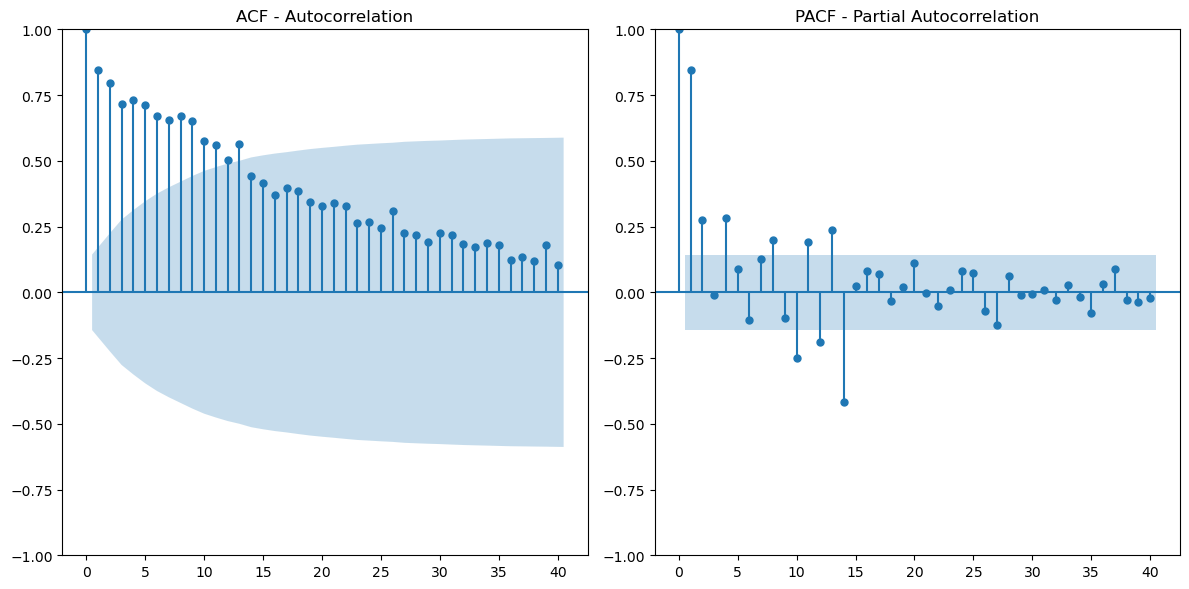

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-in

Best ARIMA order: (4, 2, 5)
Best AIC: 1532.5862792134335


c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\harve\AppData\Local\Temp\ipykernel_15968\498450998.py:66: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



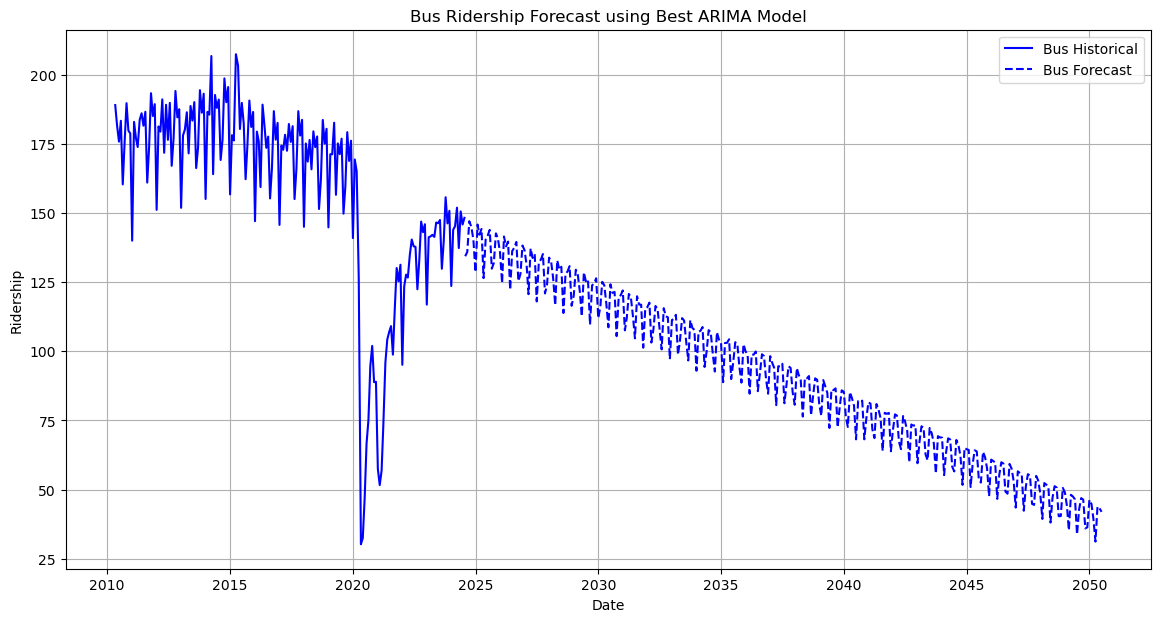

In [519]:
## tuning ARIMA for bus journeys
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] < 0.05:
        print("Data is stationary")
    else:
        print("Data is not stationary, differencing required")

# Checking stationarity of the data
check_stationarity(df['Bus journeys (m)'])

#Plotting ACF and PACF to determine possible values for p and q
plt.figure(figsize=(12, 6))

# ACF plot for q
plt.subplot(1, 2, 1)
plot_acf(df['Bus journeys (m)'], lags=40, ax=plt.gca())
plt.title('ACF - Autocorrelation')

# PACF plot for p
plt.subplot(1, 2, 2)
plot_pacf(df['Bus journeys (m)'], lags=40, ax=plt.gca())
plt.title('PACF - Partial Autocorrelation')

plt.tight_layout()
plt.show()

#Grid searching for best p, d, q parameters based on AIC
best_aic = np.inf
best_order = None
best_model = None

# Define range for p, d, q
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)

# Perform grid search
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(df['Bus journeys (m)'], order=(p, d, q))
                model_fit = model.fit()
                aic = model_fit.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model = model_fit
            except:
                continue

print(f"Best ARIMA order: {best_order}")
print(f"Best AIC: {best_aic}")

#Fitting the best model
model_bus_best = ARIMA(df['Bus journeys (m)'], order=best_order)
model_bus_best_fit = model_bus_best.fit()

# Forecasting with the best model
forecast_bus = model_bus_best_fit.forecast(steps=(2050 - df['Period ending'].dt.year.max()) * 12)

# Creating future dates
future_dates = pd.date_range(start=df['Period ending'].max() + pd.Timedelta(days=1), periods=len(forecast_bus), freq='M')

# Plotting the forecasts
plt.figure(figsize=(14, 7))
plt.plot(df['Period ending'], df['Bus journeys (m)'], label='Bus Historical', color='blue')
plt.plot(future_dates, forecast_bus, label='Bus Forecast', color='blue', linestyle='--')
plt.title('Bus Ridership Forecast using Best ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.legend()
plt.grid(True)
plt.show()

ADF Statistic: -2.534861258411175
p-value: 0.10722093106629044
Data not stationary


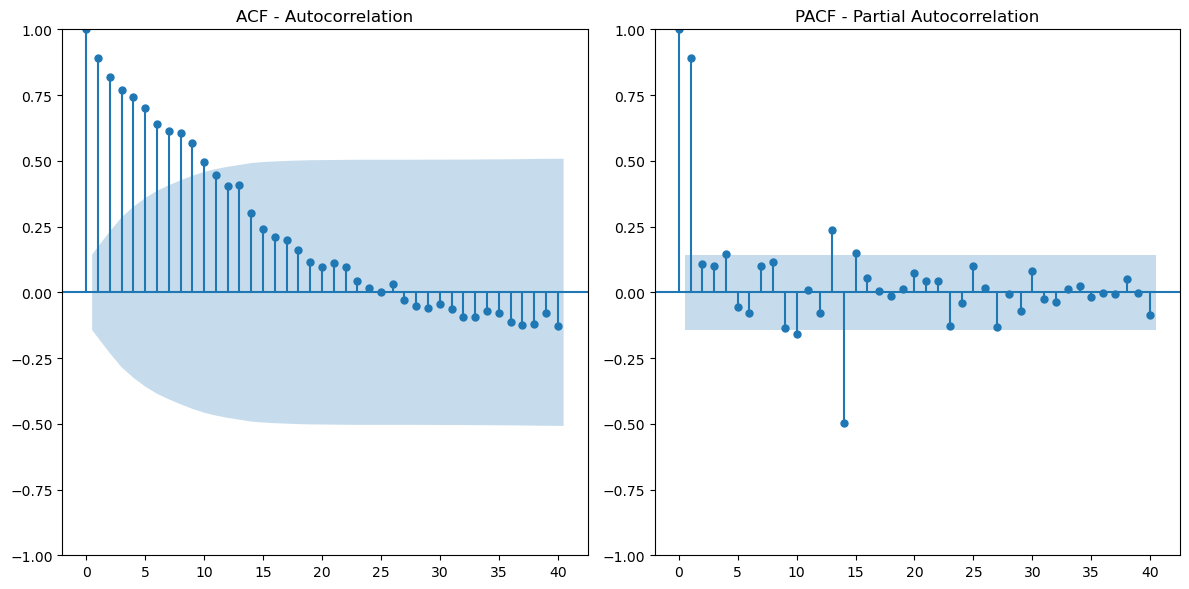

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Lik

Best ARIMA order: (5, 2, 5)
Best AIC: 1375.7733650712266


c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\harve\AppData\Local\Temp\ipykernel_15968\3605353812.py:66: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



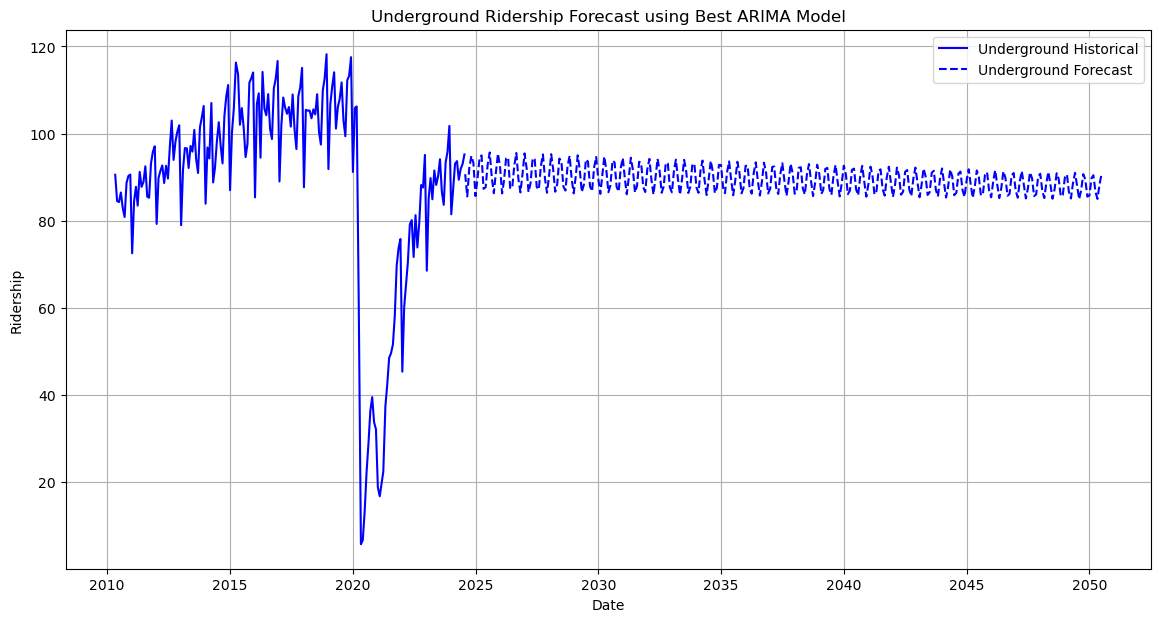

In [520]:
## tuning ARIMA for Underground journeys
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] < 0.05:
        print("Datastationary")
    else:
        print("Data not stationary")

# Check stationarity of the data 
check_stationarity(df['Underground journeys (m)'])

#Plotting the ACF and PACF to determine possible values for p and q
plt.figure(figsize=(12, 6))

# ACF plot for q
plt.subplot(1, 2, 1)
plot_acf(df['Underground journeys (m)'], lags=40, ax=plt.gca())
plt.title('ACF - Autocorrelation')

# PACF plot for p
plt.subplot(1, 2, 2)
plot_pacf(df['Underground journeys (m)'], lags=40, ax=plt.gca())
plt.title('PACF - Partial Autocorrelation')

plt.tight_layout()
plt.show()

#Grid search for best p, d, q parameters based on AIC
best_aic = np.inf
best_order = None
best_model = None

# Defining range for p, d, q
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)

# Performing grid search
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(df['Underground journeys (m)'], order=(p, d, q))
                model_fit = model.fit()
                aic = model_fit.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model = model_fit
            except:
                continue

print(f"Best ARIMA order: {best_order}")
print(f"Best AIC: {best_aic}")

#Fititng the best model
model_bus_best = ARIMA(df['Underground journeys (m)'], order=best_order)
model_bus_best_fit = model_bus_best.fit()

# Forecasting with the best model
forecast_bus = model_bus_best_fit.forecast(steps=(2050 - df['Period ending'].dt.year.max()) * 12)

# Creating future dates
future_dates = pd.date_range(start=df['Period ending'].max() + pd.Timedelta(days=1), periods=len(forecast_bus), freq='M')

# Plot the forecasts
plt.figure(figsize=(14, 7))
plt.plot(df['Period ending'], df['Underground journeys (m)'], label='Underground Historical', color='blue')
plt.plot(future_dates, forecast_bus, label='Underground Forecast', color='blue', linestyle='--')
plt.title('Underground Ridership Forecast using Best ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.legend()
plt.grid(True)
plt.show()

In [521]:
##filling overground missing values
df_cleaned = df[~df['Overground Journeys (m)'].isnull() & ~np.isinf(df['Overground Journeys (m)'])]

ADF Statistic: -2.511925130334845
p-value: 0.11259970757235899
Data not stationary


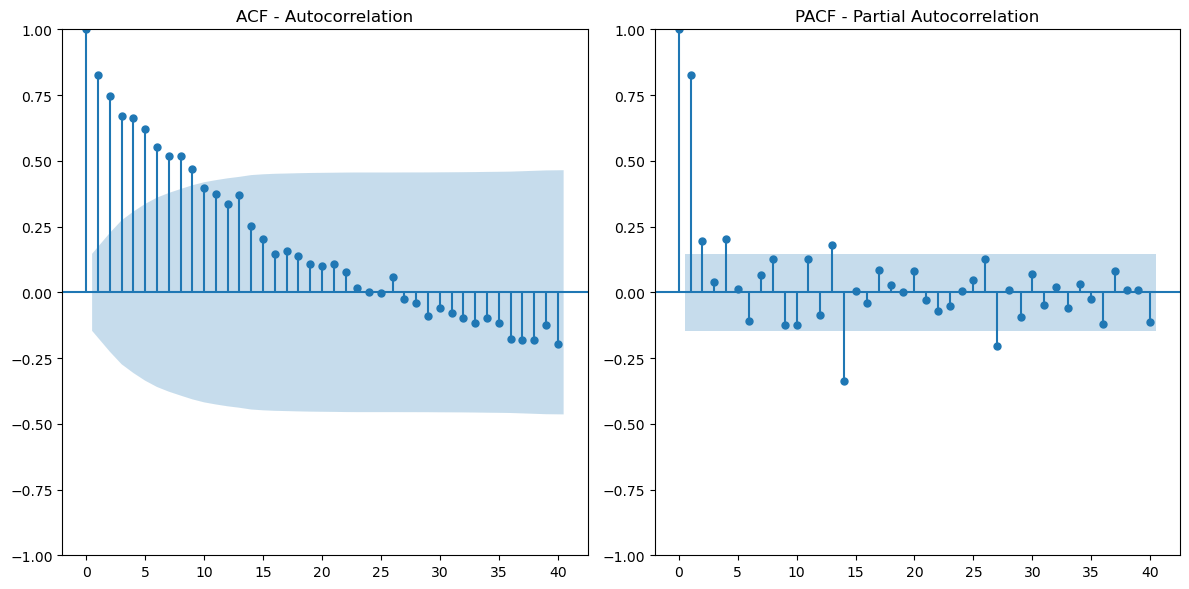

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was pro

Best ARIMA order: (2, 1, 3)
Best AIC: 714.4181535064661


c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

C:\Users\harve\AppData\Local\Temp\ipykernel_15968\850441050.py:73: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



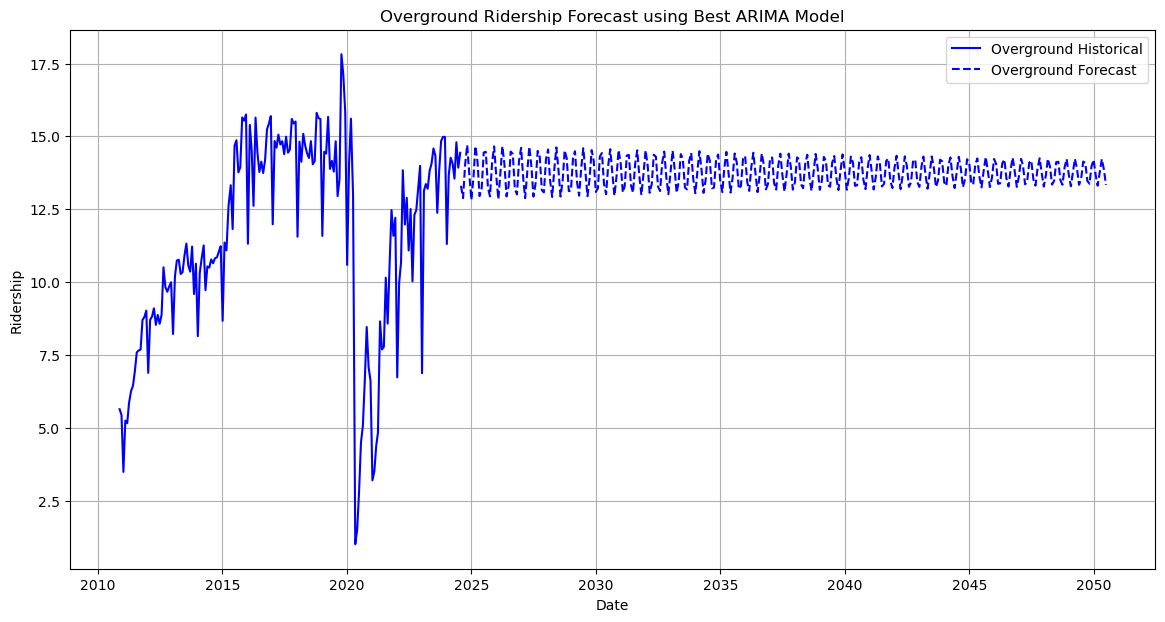

In [522]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# creating a function for checking stationarity
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] < 0.05:
        print("Data stationary")
    else:
        print("Data not stationary")

# Checking the stationarity of the cleaned data
check_stationarity(df_cleaned['Overground Journeys (m)'])

#Plotting ACF and PACF to determine possible values for p and q
plt.figure(figsize=(12, 6))

# ACF plot (for q)
plt.subplot(1, 2, 1)
plot_acf(df_cleaned['Overground Journeys (m)'], lags=40, ax=plt.gca())
plt.title('ACF - Autocorrelation')

# PACF plot (for p)
plt.subplot(1, 2, 2)
plot_pacf(df_cleaned['Overground Journeys (m)'], lags=40, ax=plt.gca())
plt.title('PACF - Partial Autocorrelation')

plt.tight_layout()
plt.show()

#Grid searching for the best p, d, q parameters based on the AIC
best_aic = np.inf
best_order = None
best_model = None

# Defining the range for p, d, q
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)

# Performing the grid search
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(df_cleaned['Overground Journeys (m)'], order=(p, d, q))
                model_fit = model.fit()
                aic = model_fit.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model = model_fit
            except:
                continue

print(f"Best ARIMA order: {best_order}")
print(f"Best AIC: {best_aic}")

#Fitting the best model
model_best = ARIMA(df_cleaned['Overground Journeys (m)'], order=best_order)
model_best_fit = model_best.fit()

#Forecasting with the best model
forecast_best = model_best_fit.forecast(steps=(2050 - df_cleaned['Period ending'].dt.year.max()) * 12)

# Creating future dates
future_dates = pd.date_range(start=df_cleaned['Period ending'].max() + pd.Timedelta(days=1), periods=len(forecast_best), freq='M')

# Plotting the forecasts
plt.figure(figsize=(14, 7))
plt.plot(df_cleaned['Period ending'], df_cleaned['Overground Journeys (m)'], label='Overground Historical', color='blue')
plt.plot(future_dates, forecast_best, label='Overground Forecast', color='blue', linestyle='--')
plt.title('Overground Ridership Forecast using Best ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.legend()
plt.grid(True)
plt.show()


c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\harve\AppData\Local\Temp\ipykernel_15968\1542831231.py:23: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



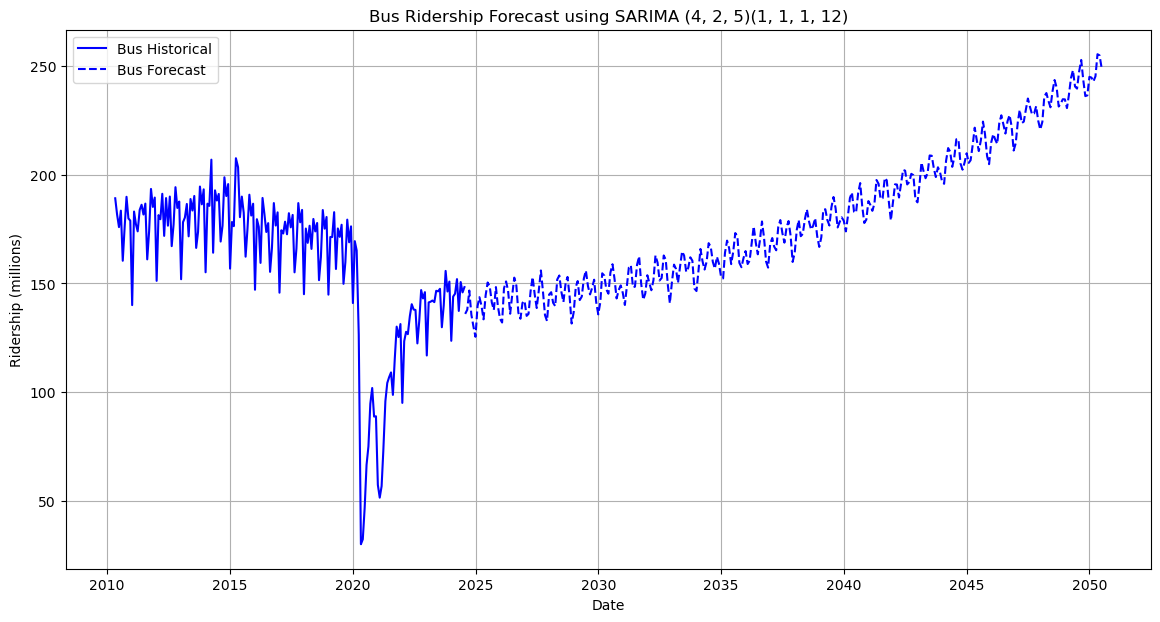

In [523]:
## using SARIMA
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Defining seasonal periods
seasonal_periods = 12

# Fitting the SARIMA model with seasonal and non-seasonal parameters
model_bus_sarima = SARIMAX(df['Bus journeys (m)'],
                           order=(4, 2, 5),
                           seasonal_order=(1, 1, 1, seasonal_periods),
                           enforce_stationarity=False, 
                           enforce_invertibility=False)

# Fitting the SARIMA model
model_bus_sarima_fit = model_bus_sarima.fit(disp=False)

# Forecasting for 2050
forecast_bus_sarima = model_bus_sarima_fit.forecast(steps=(2050 - df['Period ending'].dt.year.max()) * 12)

# Creating future monthly dates
future_dates = pd.date_range(start=df['Period ending'].max() + pd.Timedelta(days=1), periods=len(forecast_bus_sarima), freq='M')

# Plotting the historical and forecasted ridership
plt.figure(figsize=(14, 7))

# Historical
plt.plot(df['Period ending'], df['Bus journeys (m)'], label='Bus Historical', color='blue')

# Forecast
plt.plot(future_dates, forecast_bus_sarima, label='Bus Forecast', color='blue', linestyle='--')

plt.title('Bus Ridership Forecast using SARIMA (4, 2, 5)(1, 1, 1, 12)')
plt.xlabel('Date')
plt.ylabel('Ridership (millions)')
plt.legend()
plt.grid(True)
plt.show()


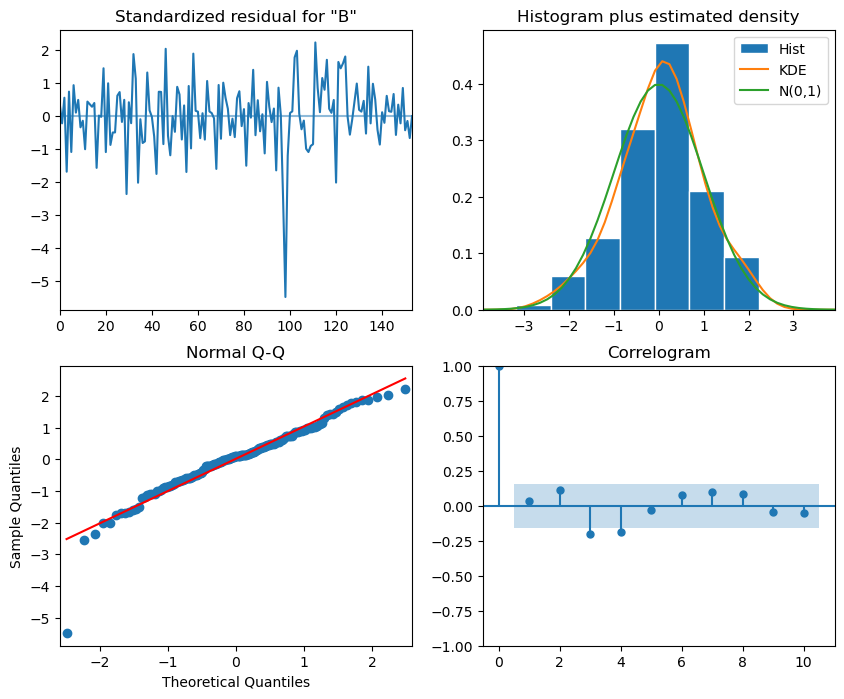

In [524]:
model_bus_sarima_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\harve\AppData\Local\Temp\ipykernel_15968\3991464981.py:22: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



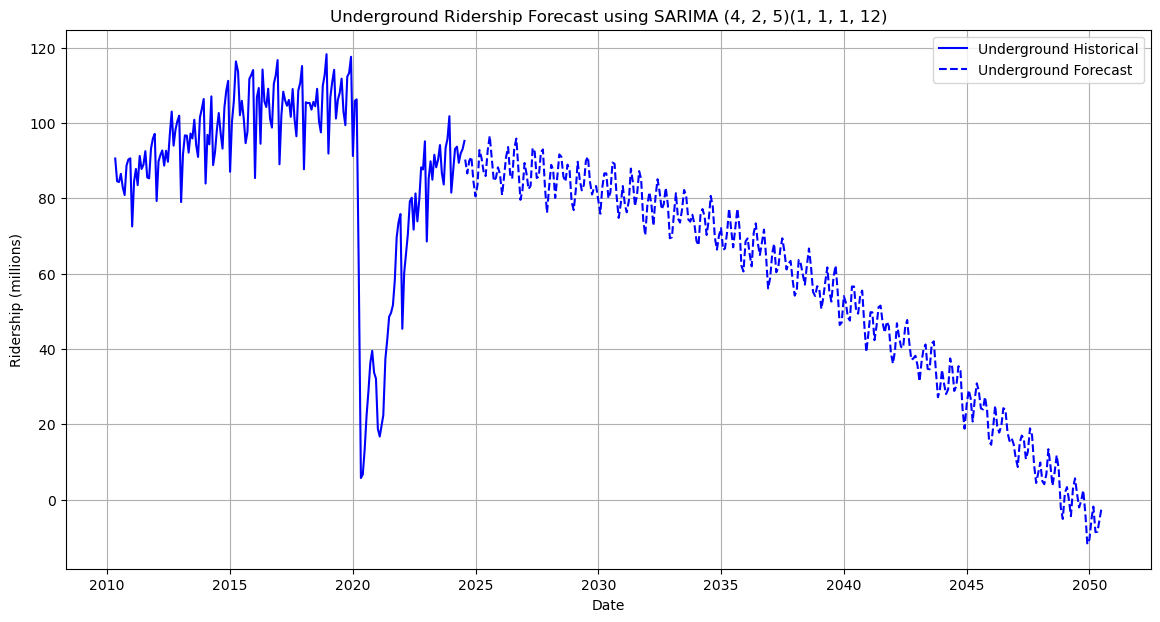

In [525]:
## SARIMA for Underground
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

seasonal_periods = 12

# Fitting the SARIMA model with seasonal and non-seasonal parameters
model_underground_sarima = SARIMAX(df['Underground journeys (m)'],
                           order=(4, 2, 5),
                           seasonal_order=(1, 1, 1, seasonal_periods),
                           enforce_stationarity=False, 
                           enforce_invertibility=False)

# Fitting the SARIMA model
model_underground_sarima_fit = model_underground_sarima.fit(disp=False)

# Forecasting for 2050
forecast_underground_sarima = model_underground_sarima_fit.forecast(steps=(2050 - df['Period ending'].dt.year.max()) * 12)

# Creating future dates
future_dates = pd.date_range(start=df['Period ending'].max() + pd.Timedelta(days=1), periods=len(forecast_bus_sarima), freq='M')

# Plotting the historical and forecasted ridership
plt.figure(figsize=(14, 7))

# Historical
plt.plot(df['Period ending'], df['Underground journeys (m)'], label='Underground Historical', color='blue')

# Forecasted
plt.plot(future_dates, forecast_underground_sarima, label='Underground Forecast', color='blue', linestyle='--')

plt.title('Underground Ridership Forecast using SARIMA (4, 2, 5)(1, 1, 1, 12)')
plt.xlabel('Date')
plt.ylabel('Ridership (millions)')
plt.legend()
plt.grid(True)
plt.show()


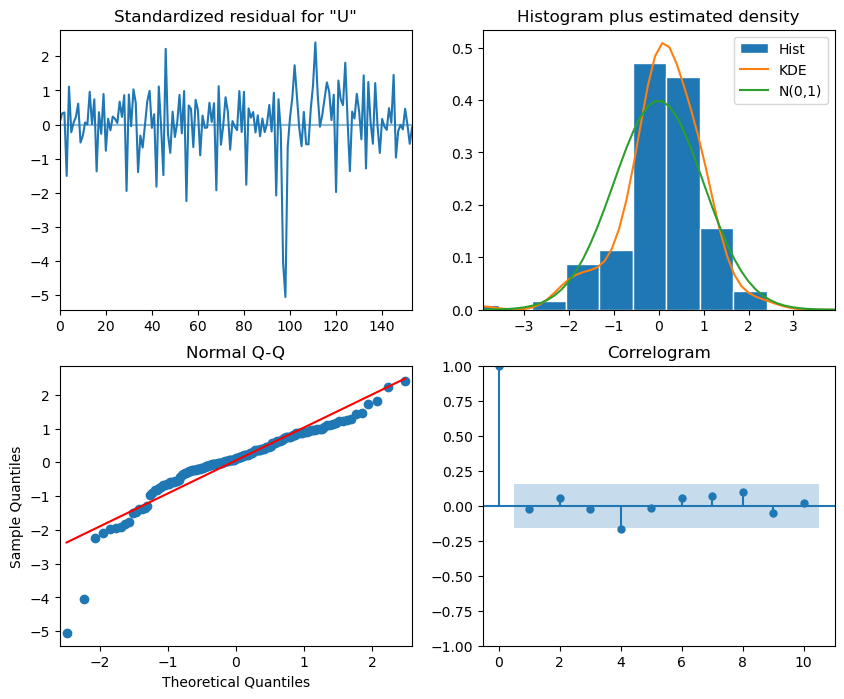

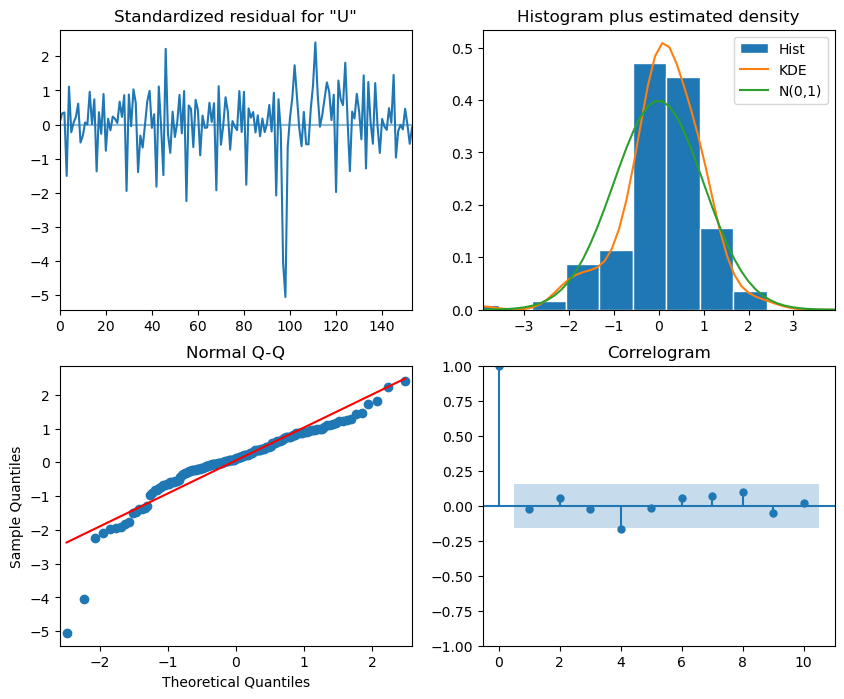

In [526]:
#observing residuals
model_underground_sarima_fit.plot_diagnostics(figsize=(10, 8))

c:\Users\harve\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\harve\AppData\Local\Temp\ipykernel_15968\3973472985.py:14: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



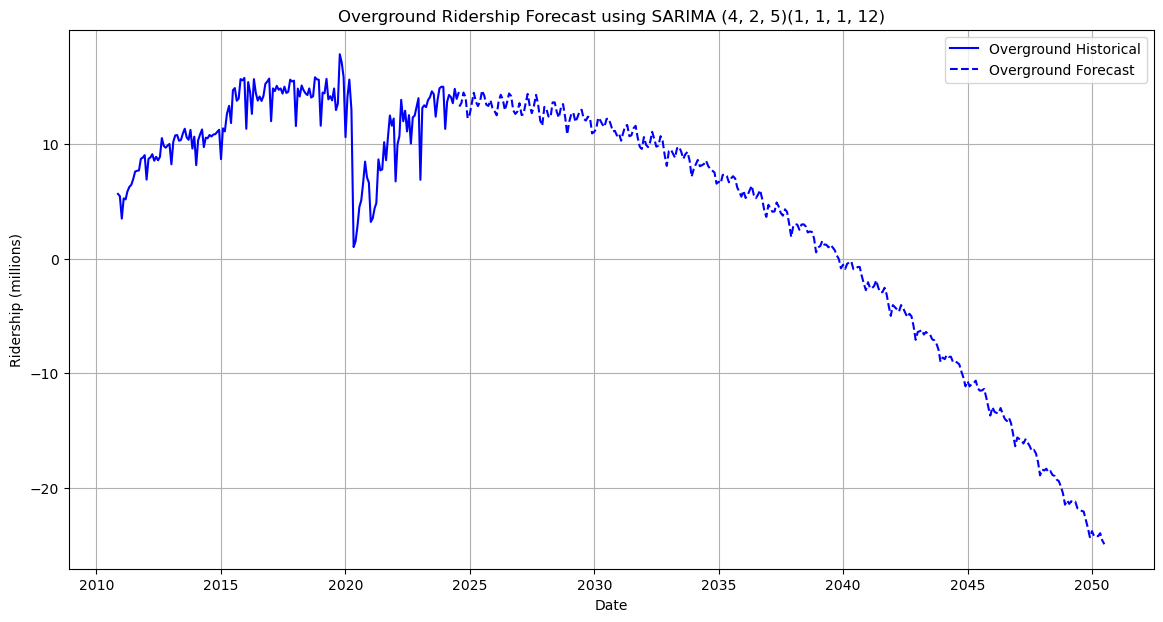

In [527]:
##SARIMA for Overground

seasonal_periods = 12
model_overground_sarima = SARIMAX(df['Overground Journeys (m)'],
                           order=(4, 2, 5),
                           seasonal_order=(1, 1, 1, seasonal_periods),
                           enforce_stationarity=False, 
                           enforce_invertibility=False)

model_overground_sarima_fit = model_overground_sarima.fit(disp=False)

forecast_overground_sarima = model_overground_sarima_fit.forecast(steps=(2050 - df['Period ending'].dt.year.max()) * 12)

future_dates = pd.date_range(start=df['Period ending'].max() + pd.Timedelta(days=1), periods=len(forecast_overground_sarima), freq='M')

plt.figure(figsize=(14, 7))

plt.plot(df['Period ending'], df['Overground Journeys (m)'], label='Overground Historical', color='blue')

plt.plot(future_dates, forecast_overground_sarima, label='Overground Forecast', color='blue', linestyle='--')

plt.title('Overground Ridership Forecast using SARIMA (4, 2, 5)(1, 1, 1, 12)')
plt.xlabel('Date')
plt.ylabel('Ridership (millions)')
plt.legend()
plt.grid(True)
plt.show()


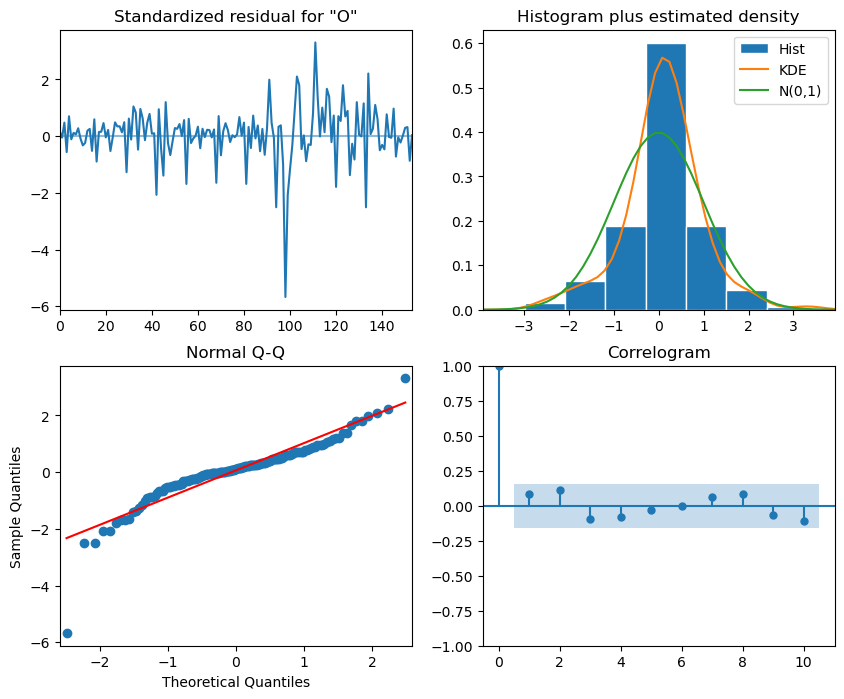

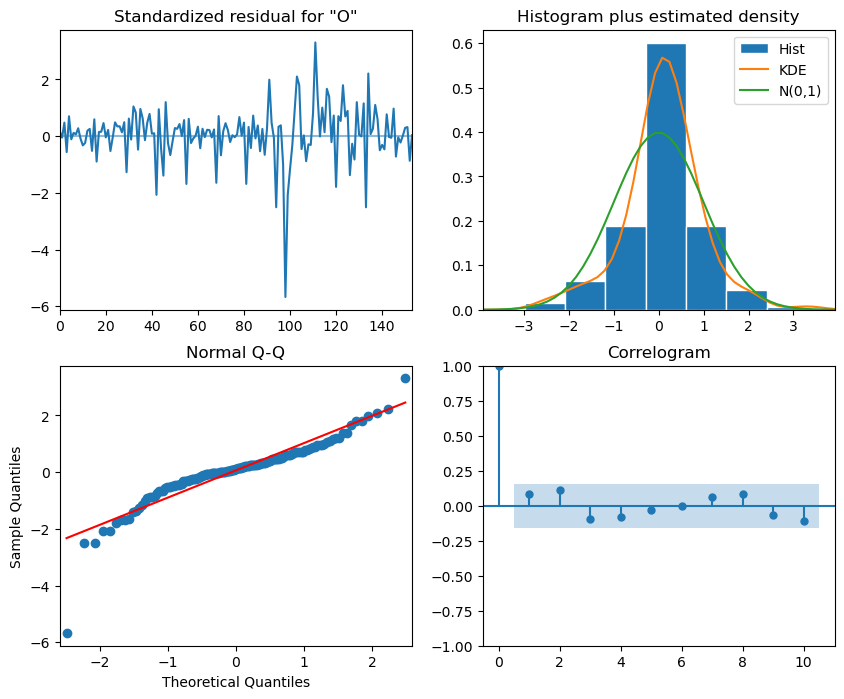

In [528]:
## observing residuals for overground
model_overground_sarima_fit.plot_diagnostics(figsize=(10, 8))

In [529]:
##london ghg per capita emissions

df = pd.read_excel('London_ConsumptionBasedEmissions_2001-2021.xlsx', 4, header = 1)

In [530]:
print(df.head(15))

   Unnamed: 0                               Unnamed: 1  \
0   Transport  Private transport (direct and indirect)   
1         NaN                         Public transport   
2         NaN                 Other transport services   
3         NaN                                 Aviation   
4         NaN                                    TOTAL   
5         NaN                                      NaN   
6         NaN                                      NaN   
7         NaN                                      NaN   
8         NaN                                      NaN   
9         NaN                                      NaN   
10        NaN                                      NaN   
11        NaN                                      NaN   
12        NaN                                      NaN   
13        NaN                                      NaN   
14        NaN                                     2021   

                                       2001              2002  \
0     

In [531]:
df.drop(df.index[4:], inplace=True)

In [532]:
print(df.head(15))

  Unnamed: 0                               Unnamed: 1      2001      2002  \
0  Transport  Private transport (direct and indirect)  1.352463  1.376911   
1        NaN                         Public transport  0.683891  0.756429   
2        NaN                 Other transport services  0.239205  0.119867   
3        NaN                                 Aviation  0.333245  0.474824   

       2003      2004      2005      2006      2007      2008  ...      2012  \
0  1.542784  1.382689   1.49074  1.436277  1.435949  1.269711  ...  0.972213   
1  0.614553  0.670407  0.719798  0.768376  0.728541  0.618052  ...  0.461000   
2  0.093474  0.143588  0.235161  0.128825  0.211909  0.186033  ...  0.125236   
3  0.384508  0.512747  0.487219  0.457983  0.578497  0.682369  ...  0.432386   

       2013      2014      2015      2016      2017      2018      2019  \
0  1.068077  1.132240  0.922963  0.954757  1.045560  1.073263  0.847276   
1  0.481457  0.468419  0.447298  0.463454  0.380198  0.396387  

In [533]:
new_df = df.drop(columns=['Unnamed: 0'])

In [534]:
new_df = new_df.rename(columns={"Unnamed: 1": "Transport Type"})

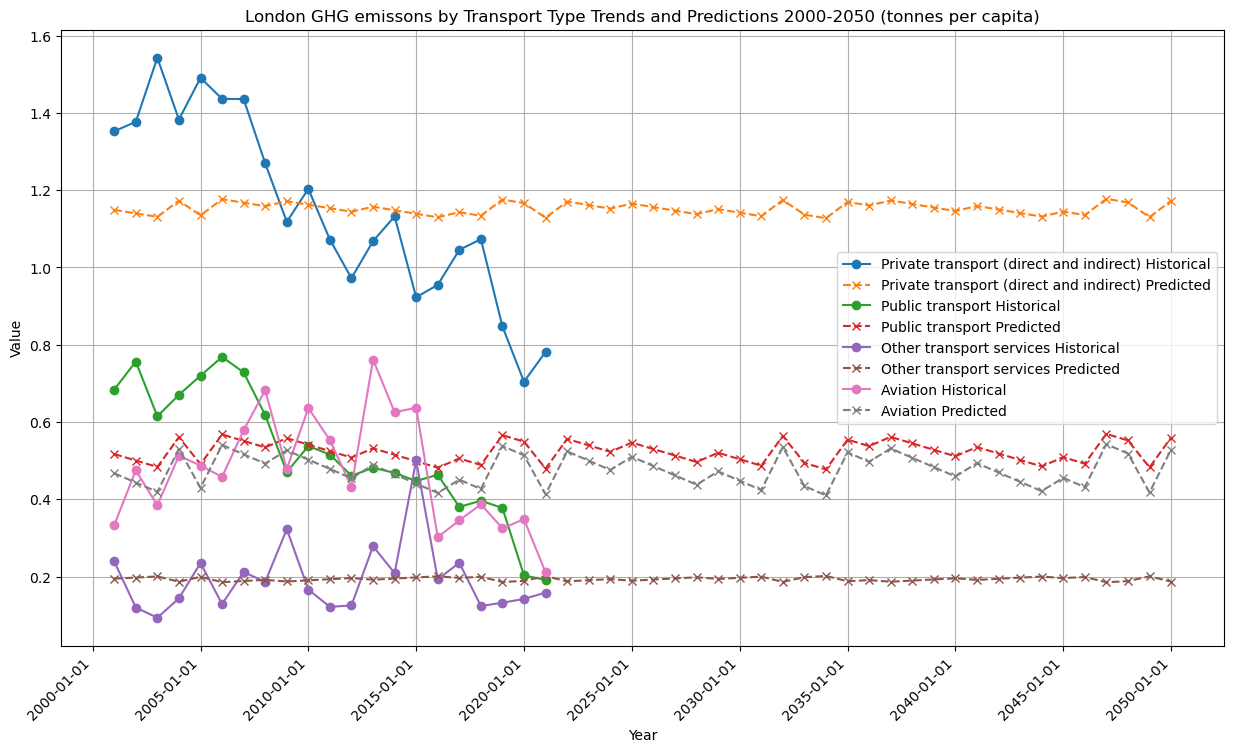

In [535]:
#Converting from wide to long data
df_melted = new_df.melt(id_vars='Transport Type', var_name='Year', value_name='Value')

# Converting Year to datetime
df_melted['Year'] = pd.to_datetime(df_melted['Year'], format='%Y')

# Preparing data for prediction
years = df_melted['Year'].dt.year.unique()
years_future = np.arange(years[0], 2051)

# Creating a DataFrame for the future years
df_future = pd.DataFrame({'Year': years_future})
df_future['Year'] = pd.to_datetime(df_future['Year'], format='%Y')

# Initialising an empty DataFrame to store predictions
df_predictions = pd.DataFrame({'Year': df_future['Year']})

# Predicting for each transport type
for transport_type in new_df['Transport Type'].unique():
    df_type = df_melted[df_melted['Transport Type'] == transport_type]
    model = LinearRegression()
    model.fit(df_type[['Year']].values.astype(int), df_type['Value'])
    predictions = model.predict(df_future[['Year']].values.astype(int))
    df_predictions[transport_type] = predictions

# Melting the predictions DataFrame to long format for plotting
df_predictions_melted = df_predictions.melt(id_vars='Year', var_name='Transport Type', value_name='Predicted Value')

# Combining historical and predicted data for plotting
df_combined = df_melted.merge(df_predictions_melted, on=['Year', 'Transport Type'], how='outer')

# Plotting the historical data and predictions
plt.figure(figsize=(15, 8))
for transport_type in new_df['Transport Type'].unique():
    df_type_combined = df_combined[df_combined['Transport Type'] == transport_type]
    plt.plot(df_type_combined['Year'], df_type_combined['Value'], marker='o', label=f'{transport_type} Historical')
    plt.plot(df_type_combined['Year'], df_type_combined['Predicted Value'], linestyle='--', marker='x', label=f'{transport_type} Predicted')

plt.xticks(rotation=45, ha='right')
desired_years = np.arange(2000, 2051, 5)
plt.xticks(pd.to_datetime(desired_years, format='%Y'))
plt.xticks(rotation=45, ha='right')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('London GHG emissons by Transport Type Trends and Predictions 2000-2050 (tonnes per capita)')
plt.legend()
plt.grid(True)
plt.show()

In [536]:
LAEI_nox_2013 = pd.read_excel('Copy of LAEI-2019-Emissions-Summary-including-Forecast.xlsx', 2, header=7)

In [537]:
LAEI_nox_2013.columns

Index(['Unnamed: 0', 'Source', 'Central', 'Inner', 'Outer', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10',
       'Row Labels', 'Barking and Dagenham', 'Barnet', 'Bexley', 'Brent',
       'Bromley', 'Camden', 'City', 'City of Westminster', 'Croydon', 'Ealing',
       'Enfield', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Haringey',
       'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington',
       'Kensington and Chelsea', 'Kingston', 'Lambeth', 'Lewisham', 'Merton',
       'Newham', 'Redbridge', 'Richmond', 'Southwark', 'Sutton',
       'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Non GLA',
       'Grand Total'],
      dtype='object')

In [538]:
new_LAEI_nox_2013 = LAEI_nox_2013.drop(columns=[ 'Unnamed: 0', 'Source', 'Central', 'Inner', 'Outer', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'])

In [539]:
new_LAEI_nox_2013.drop(new_LAEI_nox_2013.index[0:48], inplace=True)

In [540]:
new_LAEI_nox_2013.drop(new_LAEI_nox_2013.index[13], inplace=True)

In [541]:
print(new_LAEI_nox_2013)

             Row Labels  Barking and Dagenham       Barnet      Bexley  \
48       Road Transport            443.445381  1277.287386  605.577699   
49         Car - Diesel            122.771048   397.024308  188.456307   
50       Car - Electric              0.000000     0.000000    0.000000   
51         Car - Petrol             40.104403   129.317005   63.343942   
52    HGV - Articulated             43.438257    72.213748   42.994272   
53          HGV - Rigid             73.887258   145.408618   66.312180   
54         LGV - Diesel             87.453950   270.963248  132.325550   
55       LGV - Electric              0.000000     0.000000    0.000000   
56         LGV - Petrol              0.604974     1.849083    0.949818   
57           Motorcycle              1.103118     4.586011    2.145464   
58  Non-TfL Bus / Coach             22.750298   113.370667   50.089656   
59                 Taxi              2.566117    21.757417    3.704004   
60              TfL Bus             48

In [542]:
# turning the df into long format
new_LAEI_nox_2013 = new_LAEI_nox_2013.reset_index()

In [543]:
new_LAEI_nox_2013_long = new_LAEI_nox_2013.melt(
    id_vars=['Row Labels'],   
    var_name='Borough',       
    value_name='NOx'           
)

# Adding the year column
new_LAEI_nox_2013_long['Year'] = 2013

#renaming
new_LAEI_nox_2013_long = new_LAEI_nox_2013_long.rename(columns={'Row Labels': 'Transport Mode'})

print(new_LAEI_nox_2013_long.head(20))

         Transport Mode               Borough         NOx  Year
0        Road Transport                 index   48.000000  2013
1          Car - Diesel                 index   49.000000  2013
2        Car - Electric                 index   50.000000  2013
3          Car - Petrol                 index   51.000000  2013
4     HGV - Articulated                 index   52.000000  2013
5           HGV - Rigid                 index   53.000000  2013
6          LGV - Diesel                 index   54.000000  2013
7        LGV - Electric                 index   55.000000  2013
8          LGV - Petrol                 index   56.000000  2013
9            Motorcycle                 index   57.000000  2013
10  Non-TfL Bus / Coach                 index   58.000000  2013
11                 Taxi                 index   59.000000  2013
12              TfL Bus                 index   60.000000  2013
13       Road Transport  Barking and Dagenham  443.445381  2013
14         Car - Diesel  Barking and Dag

In [544]:
new_LAEI_nox_2013_long.drop(new_LAEI_nox_2013_long.index[0:13], inplace=True)

In [545]:
new_LAEI_nox_2013_long = new_LAEI_nox_2013_long.reset_index()

In [546]:
print(new_LAEI_nox_2013_long.tail(20))

     index       Transport Mode      Borough           NOx  Year
435    448         LGV - Diesel      Non GLA   2352.578385  2013
436    449       LGV - Electric      Non GLA      0.000000  2013
437    450         LGV - Petrol      Non GLA     10.932128  2013
438    451           Motorcycle      Non GLA     23.068459  2013
439    452  Non-TfL Bus / Coach      Non GLA    381.566497  2013
440    453                 Taxi      Non GLA     27.607928  2013
441    454              TfL Bus      Non GLA     28.868143  2013
442    455       Road Transport  Grand Total  31122.442572  2013
443    456         Car - Diesel  Grand Total   9430.400161  2013
444    457       Car - Electric  Grand Total      0.000000  2013
445    458         Car - Petrol  Grand Total   2538.940733  2013
446    459    HGV - Articulated  Grand Total   2336.046344  2013
447    460          HGV - Rigid  Grand Total   3705.701757  2013
448    461         LGV - Diesel  Grand Total   6704.888142  2013
449    462       LGV - El

In [547]:
new_LAEI_nox_2013_long.drop(new_LAEI_nox_2013_long.index[442:455], inplace=True)

In [548]:
new_LAEI_nox_2013_long.drop(new_LAEI_nox_2013_long.index[429:442], inplace=True)

In [549]:
print(new_LAEI_nox_2013_long.tail(15))

     index       Transport Mode         Borough         NOx  Year
414    427                 Taxi  Waltham Forest   23.099166  2013
415    428              TfL Bus  Waltham Forest   72.173545  2013
416    429       Road Transport      Wandsworth  587.291248  2013
417    430         Car - Diesel      Wandsworth  156.179897  2013
418    431       Car - Electric      Wandsworth    0.000000  2013
419    432         Car - Petrol      Wandsworth   48.427728  2013
420    433    HGV - Articulated      Wandsworth   24.723479  2013
421    434          HGV - Rigid      Wandsworth   86.776998  2013
422    435         LGV - Diesel      Wandsworth  121.973383  2013
423    436       LGV - Electric      Wandsworth    0.000000  2013
424    437         LGV - Petrol      Wandsworth    0.730292  2013
425    438           Motorcycle      Wandsworth    3.699261  2013
426    439  Non-TfL Bus / Coach      Wandsworth   52.436700  2013
427    440                 Taxi      Wandsworth   14.441713  2013
428    441

In [550]:
new_LAEI_nox_2013_long.drop(columns=['index'], inplace=True)

In [551]:
print(new_LAEI_nox_2013_long.head(15))

         Transport Mode               Borough          NOx  Year
0        Road Transport  Barking and Dagenham   443.445381  2013
1          Car - Diesel  Barking and Dagenham   122.771048  2013
2        Car - Electric  Barking and Dagenham     0.000000  2013
3          Car - Petrol  Barking and Dagenham    40.104403  2013
4     HGV - Articulated  Barking and Dagenham    43.438257  2013
5           HGV - Rigid  Barking and Dagenham    73.887258  2013
6          LGV - Diesel  Barking and Dagenham    87.453950  2013
7        LGV - Electric  Barking and Dagenham     0.000000  2013
8          LGV - Petrol  Barking and Dagenham     0.604974  2013
9            Motorcycle  Barking and Dagenham     1.103118  2013
10  Non-TfL Bus / Coach  Barking and Dagenham    22.750298  2013
11                 Taxi  Barking and Dagenham     2.566117  2013
12              TfL Bus  Barking and Dagenham    48.765958  2013
13       Road Transport                Barnet  1277.287386  2013
14         Car - Diesel  

In [552]:
LAEI_nox_2016 = pd.read_excel('Copy of LAEI-2019-Emissions-Summary-including-Forecast.xlsx', 3, header=7)

In [553]:
new_LAEI_nox_2016 = LAEI_nox_2016.drop(columns=[ 'Unnamed: 0', 'Source', 'Central', 'Inner', 'Outer', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'])

In [554]:
new_LAEI_nox_2016.drop(new_LAEI_nox_2016.index[0:48], inplace=True)

In [555]:
new_LAEI_nox_2016.drop(new_LAEI_nox_2016.index[13], inplace=True)

In [556]:
print(new_LAEI_nox_2016)

             Row Labels  Barking and Dagenham       Barnet       Bexley  \
48       Road Transport            329.063957   946.074136   519.935859   
49         Car - Diesel            113.572109   352.039860   196.685090   
50       Car - Electric              0.000000     0.000000     0.000000   
51         Car - Petrol             26.142198    79.178555    45.416189   
52    HGV - Articulated             15.624308    28.820944    19.019350   
53          HGV - Rigid             34.623782    69.151315    42.926237   
54         LGV - Diesel             86.086065   268.127340   139.563582   
55       LGV - Electric              0.000000     0.000000     0.000000   
56         LGV - Petrol              0.121539     0.358807     0.197950   
57           Motorcycle              1.163516     4.052648     2.033794   
58  Non-TfL Bus / Coach             20.749785    58.605461    31.834734   
59         PHV - Diesel              4.367647    11.125261     6.106071   
60       PHV - Electric  

In [557]:
new_LAEI_nox_2016 = new_LAEI_nox_2016.reset_index()

In [558]:
new_LAEI_nox_2016_long = new_LAEI_nox_2016.melt(
    id_vars=['Row Labels'],    
    var_name='Borough',        
    value_name='NOx'           
)

new_LAEI_nox_2016_long['Year'] = 2016

new_LAEI_nox_2016_long = new_LAEI_nox_2016_long.rename(columns={'Row Labels': 'Transport Mode'})

print(new_LAEI_nox_2016_long.head(20))

         Transport Mode               Borough         NOx  Year
0        Road Transport                 index   48.000000  2016
1          Car - Diesel                 index   49.000000  2016
2        Car - Electric                 index   50.000000  2016
3          Car - Petrol                 index   51.000000  2016
4     HGV - Articulated                 index   52.000000  2016
5           HGV - Rigid                 index   53.000000  2016
6          LGV - Diesel                 index   54.000000  2016
7        LGV - Electric                 index   55.000000  2016
8          LGV - Petrol                 index   56.000000  2016
9            Motorcycle                 index   57.000000  2016
10  Non-TfL Bus / Coach                 index   58.000000  2016
11         PHV - Diesel                 index   59.000000  2016
12       PHV - Electric                 index   60.000000  2016
13                 Taxi                 index   62.000000  2016
14              TfL Bus                 

In [559]:
new_LAEI_nox_2016_long.drop(new_LAEI_nox_2016_long.index[0:16], inplace=True)

In [560]:
new_LAEI_nox_2016_long = new_LAEI_nox_2016_long.reset_index()

In [561]:
new_LAEI_nox_2016_long.drop(new_LAEI_nox_2016_long.index[442:455], inplace=True)

In [562]:
new_LAEI_nox_2016_long.drop(columns=['index'], inplace=True)

In [563]:
print(new_LAEI_nox_2016_long.head(15))


         Transport Mode               Borough         NOx  Year
0        Road Transport  Barking and Dagenham  329.063957  2016
1          Car - Diesel  Barking and Dagenham  113.572109  2016
2        Car - Electric  Barking and Dagenham    0.000000  2016
3          Car - Petrol  Barking and Dagenham   26.142198  2016
4     HGV - Articulated  Barking and Dagenham   15.624308  2016
5           HGV - Rigid  Barking and Dagenham   34.623782  2016
6          LGV - Diesel  Barking and Dagenham   86.086065  2016
7        LGV - Electric  Barking and Dagenham    0.000000  2016
8          LGV - Petrol  Barking and Dagenham    0.121539  2016
9            Motorcycle  Barking and Dagenham    1.163516  2016
10  Non-TfL Bus / Coach  Barking and Dagenham   20.749785  2016
11         PHV - Diesel  Barking and Dagenham    4.367647  2016
12       PHV - Electric  Barking and Dagenham    0.000000  2016
13                 Taxi  Barking and Dagenham    7.912036  2016
14              TfL Bus  Barking and Dag

In [564]:
new_LAEI_nox_2016_long.drop(new_LAEI_nox_2016_long.index[528:560], inplace=True)

In [565]:
new_LAEI_nox_2016_long.reset_index()

index       Transport Mode               Borough         NOx  Year
0        0       Road Transport  Barking and Dagenham  329.063957  2016
1        1         Car - Diesel  Barking and Dagenham  113.572109  2016
2        2       Car - Electric  Barking and Dagenham    0.000000  2016
3        3         Car - Petrol  Barking and Dagenham   26.142198  2016
4        4    HGV - Articulated  Barking and Dagenham   15.624308  2016
..     ...                  ...                   ...         ...   ...
523    536         LGV - Petrol               Non GLA    2.644724  2016
524    537           Motorcycle               Non GLA   18.514507  2016
525    538  Non-TfL Bus / Coach               Non GLA  188.054210  2016
526    539         PHV - Diesel               Non GLA  100.459488  2016
527    540       PHV - Electric               Non GLA    0.000000  2016

[528 rows x 5 columns]

In [566]:
new_LAEI_nox_2016_long.tail(50)

Transport Mode         Borough          NOx  Year
491         PHV - Diesel   Tower Hamlets    10.116393  2016
492       PHV - Electric   Tower Hamlets     0.000000  2016
493                 Taxi   Tower Hamlets    27.894418  2016
494              TfL Bus   Tower Hamlets    12.237927  2016
495          Grand Total   Tower Hamlets  1052.629312  2016
496       Road Transport  Waltham Forest   399.944003  2016
497         Car - Diesel  Waltham Forest   147.967641  2016
498       Car - Electric  Waltham Forest     0.000000  2016
499         Car - Petrol  Waltham Forest    33.300810  2016
500    HGV - Articulated  Waltham Forest    10.339339  2016
501          HGV - Rigid  Waltham Forest    32.535683  2016
502         LGV - Diesel  Waltham Forest   112.298956  2016
503       LGV - Electric  Waltham Forest     0.000000  2016
504         LGV - Petrol  Waltham Forest     0.164904  2016
505           Motorcycle  Waltham Forest     2.447451  2016
506  Non-TfL Bus / Coach  Waltham Forest    23.677911  2016
507         PHV - Diesel  Waltham Forest     5.811529  2016
508       PHV - Electric  Waltham Forest     0.000000  2016
509                 Taxi  Waltham Forest    12.176300  2016
510              TfL Bus  Waltham Forest    18.504753  2016
511          Grand Total  Waltham Forest   627.257452  2016
512       Road Transport      Wandsworth   398.702386  2016
513         Car - Diesel      Wandsworth   135.017379  2016
514       Car - Electric      Wandsworth     0.000000  2016
515         Car - Petrol      Wandsworth    29.673796  2016
516    HGV - Articulated      Wandsworth    14.037898  2016
517          HGV - Rigid      Wandsworth    39.971329  2016
518         LGV - Diesel      Wandsworth   107.148167  2016
519       LGV - Electric      Wandsworth     0.000000  2016
520         LGV - Petrol      Wandsworth     0.149399  2016
521           Motorcycle      Wandsworth     1.670580  2016
522  Non-TfL Bus / Coach      Wandsworth    33.415530  2016
523         PHV - Diesel      Wandsworth     8.163468  2016
524       PHV - Electric      Wandsworth     0.000000  2016
525                 Taxi      Wandsworth    13.031934  2016
526              TfL Bus      Wandsworth    15.579659  2016
527          Grand Total      Wandsworth   767.053257  2016
528       Road Transport         Non GLA  6799.179943  2016
529         Car - Diesel         Non GLA  2747.025530  2016
530       Car - Electric         Non GLA     0.000000  2016
531         Car - Petrol         Non GLA   438.349758  2016
532    HGV - Articulated         Non GLA   494.335843  2016
533          HGV - Rigid         Non GLA   394.904196  2016
534         LGV - Diesel         Non GLA  2349.214203  2016
535       LGV - Electric         Non GLA     0.000000  2016
536         LGV - Petrol         Non GLA     2.644724  2016
537           Motorcycle         Non GLA    18.514507  2016
538  Non-TfL Bus / Coach         Non GLA   188.054210  2016
539         PHV - Diesel         Non GLA   100.459488  2016
540       PHV - Electric         Non GLA     0.000000  2016

In [567]:
new_LAEI_nox_2016_long.drop(index=range(528, 541), inplace=True)

In [568]:
new_LAEI_nox_2016_long.tail(50)

Transport Mode         Borough          NOx  Year
478              TfL Bus          Sutton    13.679295  2016
479          Grand Total          Sutton   765.838946  2016
480       Road Transport   Tower Hamlets   391.649393  2016
481         Car - Diesel   Tower Hamlets   108.755813  2016
482       Car - Electric   Tower Hamlets     0.000000  2016
483         Car - Petrol   Tower Hamlets    23.670367  2016
484    HGV - Articulated   Tower Hamlets    12.403023  2016
485          HGV - Rigid   Tower Hamlets    49.861762  2016
486         LGV - Diesel   Tower Hamlets   113.854008  2016
487       LGV - Electric   Tower Hamlets     0.000000  2016
488         LGV - Petrol   Tower Hamlets     0.167348  2016
489           Motorcycle   Tower Hamlets     2.721010  2016
490  Non-TfL Bus / Coach   Tower Hamlets    28.668912  2016
491         PHV - Diesel   Tower Hamlets    10.116393  2016
492       PHV - Electric   Tower Hamlets     0.000000  2016
493                 Taxi   Tower Hamlets    27.894418  2016
494              TfL Bus   Tower Hamlets    12.237927  2016
495          Grand Total   Tower Hamlets  1052.629312  2016
496       Road Transport  Waltham Forest   399.944003  2016
497         Car - Diesel  Waltham Forest   147.967641  2016
498       Car - Electric  Waltham Forest     0.000000  2016
499         Car - Petrol  Waltham Forest    33.300810  2016
500    HGV - Articulated  Waltham Forest    10.339339  2016
501          HGV - Rigid  Waltham Forest    32.535683  2016
502         LGV - Diesel  Waltham Forest   112.298956  2016
503       LGV - Electric  Waltham Forest     0.000000  2016
504         LGV - Petrol  Waltham Forest     0.164904  2016
505           Motorcycle  Waltham Forest     2.447451  2016
506  Non-TfL Bus / Coach  Waltham Forest    23.677911  2016
507         PHV - Diesel  Waltham Forest     5.811529  2016
508       PHV - Electric  Waltham Forest     0.000000  2016
509                 Taxi  Waltham Forest    12.176300  2016
510              TfL Bus  Waltham Forest    18.504753  2016
511          Grand Total  Waltham Forest   627.257452  2016
512       Road Transport      Wandsworth   398.702386  2016
513         Car - Diesel      Wandsworth   135.017379  2016
514       Car - Electric      Wandsworth     0.000000  2016
515         Car - Petrol      Wandsworth    29.673796  2016
516    HGV - Articulated      Wandsworth    14.037898  2016
517          HGV - Rigid      Wandsworth    39.971329  2016
518         LGV - Diesel      Wandsworth   107.148167  2016
519       LGV - Electric      Wandsworth     0.000000  2016
520         LGV - Petrol      Wandsworth     0.149399  2016
521           Motorcycle      Wandsworth     1.670580  2016
522  Non-TfL Bus / Coach      Wandsworth    33.415530  2016
523         PHV - Diesel      Wandsworth     8.163468  2016
524       PHV - Electric      Wandsworth     0.000000  2016
525                 Taxi      Wandsworth    13.031934  2016
526              TfL Bus      Wandsworth    15.579659  2016
527          Grand Total      Wandsworth   767.053257  2016

In [569]:
#nox 2019 
LAEI_nox_2019 = pd.read_excel('Copy of LAEI-2019-Emissions-Summary-including-Forecast.xlsx', 4, header=7)

In [570]:
new_LAEI_nox_2019 = LAEI_nox_2019.drop(columns=[ 'Unnamed: 0', 'Source', 'Central', 'Inner', 'Outer', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'])


In [571]:
new_LAEI_nox_2019.drop(new_LAEI_nox_2019.index[0:48], inplace=True)

In [572]:
new_LAEI_nox_2019.drop(new_LAEI_nox_2019.index[13], inplace=True)

In [573]:
print(new_LAEI_nox_2019)

             Row Labels  Barking and Dagenham      Barnet       Bexley  \
48       Road Transport            149.108714  406.808032   224.207685   
49         Car - Diesel             49.072469  138.489423    79.635622   
50       Car - Electric              0.000000    0.000000     0.000000   
51         Car - Petrol             18.295231   52.790091    30.107039   
52    HGV - Articulated              3.571768    6.457908     3.889653   
53          HGV - Rigid              9.967464   19.391541    10.826921   
54         LGV - Diesel             52.591754  151.943250    79.923444   
55       LGV - Electric              0.000000    0.000000     0.000000   
56         LGV - Petrol              0.075805    0.219948     0.118203   
57           Motorcycle              0.815818    2.798721     1.415547   
58  Non-TfL Bus / Coach              6.215938   15.804586     8.506170   
59         PHV - Diesel              1.374681    3.099743     1.843627   
60       PHV - Electric              0

In [574]:
new_LAEI_nox_2019 = new_LAEI_nox_2019.reset_index()

In [575]:
new_LAEI_nox_2019_long = new_LAEI_nox_2019.melt(
    id_vars=['Row Labels'],   
    var_name='Borough',        
    value_name='NOx'           
)

new_LAEI_nox_2019_long['Year'] = 2019

new_LAEI_nox_2019_long = new_LAEI_nox_2019_long.rename(columns={'Row Labels': 'Transport Mode'})


In [576]:
print(new_LAEI_nox_2019_long.head(20))

         Transport Mode               Borough         NOx  Year
0        Road Transport                 index   48.000000  2019
1          Car - Diesel                 index   49.000000  2019
2        Car - Electric                 index   50.000000  2019
3          Car - Petrol                 index   51.000000  2019
4     HGV - Articulated                 index   52.000000  2019
5           HGV - Rigid                 index   53.000000  2019
6          LGV - Diesel                 index   54.000000  2019
7        LGV - Electric                 index   55.000000  2019
8          LGV - Petrol                 index   56.000000  2019
9            Motorcycle                 index   57.000000  2019
10  Non-TfL Bus / Coach                 index   58.000000  2019
11         PHV - Diesel                 index   59.000000  2019
12       PHV - Electric                 index   60.000000  2019
13                 Taxi                 index   62.000000  2019
14              TfL Bus                 

In [577]:
new_LAEI_nox_2019_long.drop(new_LAEI_nox_2019_long.index[0:16], inplace=True)

In [578]:
new_LAEI_nox_2019_long = new_LAEI_nox_2019_long.reset_index()

In [579]:
new_LAEI_nox_2019_long.drop(new_LAEI_nox_2019_long.index[442:455], inplace=True)

In [580]:
new_LAEI_nox_2019_long.drop(columns=['index'], inplace=True)

In [581]:
print(new_LAEI_nox_2019_long.head(15))

         Transport Mode               Borough         NOx  Year
0        Road Transport  Barking and Dagenham  149.108714  2019
1          Car - Diesel  Barking and Dagenham   49.072469  2019
2        Car - Electric  Barking and Dagenham    0.000000  2019
3          Car - Petrol  Barking and Dagenham   18.295231  2019
4     HGV - Articulated  Barking and Dagenham    3.571768  2019
5           HGV - Rigid  Barking and Dagenham    9.967464  2019
6          LGV - Diesel  Barking and Dagenham   52.591754  2019
7        LGV - Electric  Barking and Dagenham    0.000000  2019
8          LGV - Petrol  Barking and Dagenham    0.075805  2019
9            Motorcycle  Barking and Dagenham    0.815818  2019
10  Non-TfL Bus / Coach  Barking and Dagenham    6.215938  2019
11         PHV - Diesel  Barking and Dagenham    1.374681  2019
12       PHV - Electric  Barking and Dagenham    0.000000  2019
13                 Taxi  Barking and Dagenham    3.392945  2019
14              TfL Bus  Barking and Dag

In [582]:
new_LAEI_nox_2019_long.drop(new_LAEI_nox_2019_long.index[528:560], inplace=True)

In [583]:
new_LAEI_nox_2019_long.reset_index()

index       Transport Mode               Borough         NOx  Year
0        0       Road Transport  Barking and Dagenham  149.108714  2019
1        1         Car - Diesel  Barking and Dagenham   49.072469  2019
2        2       Car - Electric  Barking and Dagenham    0.000000  2019
3        3         Car - Petrol  Barking and Dagenham   18.295231  2019
4        4    HGV - Articulated  Barking and Dagenham    3.571768  2019
..     ...                  ...                   ...         ...   ...
523    536         LGV - Petrol               Non GLA    4.064394  2019
524    537           Motorcycle               Non GLA   12.705902  2019
525    538  Non-TfL Bus / Coach               Non GLA   51.251485  2019
526    539         PHV - Diesel               Non GLA   63.233937  2019
527    540       PHV - Electric               Non GLA    0.000000  2019

[528 rows x 5 columns]

In [584]:
new_LAEI_nox_2019_long.drop(index=range(528, 541), inplace=True)

In [585]:
print(new_LAEI_nox_2019_long.tail(15))

          Transport Mode     Borough         NOx  Year
513         Car - Diesel  Wandsworth   51.718633  2019
514       Car - Electric  Wandsworth    0.000000  2019
515         Car - Petrol  Wandsworth   20.022245  2019
516    HGV - Articulated  Wandsworth    3.025218  2019
517          HGV - Rigid  Wandsworth   11.190529  2019
518         LGV - Diesel  Wandsworth   52.487977  2019
519       LGV - Electric  Wandsworth    0.000000  2019
520         LGV - Petrol  Wandsworth    0.081457  2019
521           Motorcycle  Wandsworth    1.162573  2019
522  Non-TfL Bus / Coach  Wandsworth    9.629992  2019
523         PHV - Diesel  Wandsworth    2.521736  2019
524       PHV - Electric  Wandsworth    0.000000  2019
525                 Taxi  Wandsworth    5.630566  2019
526              TfL Bus  Wandsworth    5.318560  2019
527          Grand Total  Wandsworth  418.234498  2019


In [586]:
## nox 2025
LAEI_nox_2025 = pd.read_excel('Copy of LAEI-2019-Emissions-Summary-including-Forecast.xlsx', 5, header=7)

In [587]:
new_LAEI_nox_2025 = LAEI_nox_2025.drop(columns=[ 'Unnamed: 0', 'Source', 'Central', 'Inner', 'Outer', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'])


In [588]:
new_LAEI_nox_2025.drop(new_LAEI_nox_2025.index[0:48], inplace=True)

In [589]:
new_LAEI_nox_2025.drop(new_LAEI_nox_2025.index[13], inplace=True)

In [590]:
print(new_LAEI_nox_2025)

             Row Labels  Barking and Dagenham      Barnet     Bexley  \
48       Road Transport             46.786511  131.086864  64.551415   
49         Car - Diesel             12.304775   37.346412  18.483395   
50       Car - Electric              0.007073    0.021027   0.010284   
51         Car - Petrol             13.802089   41.159163  20.116582   
52    HGV - Articulated              2.846585    4.279036   2.600531   
53          HGV - Rigid              5.365921   10.043247   4.746052   
54         LGV - Diesel              8.864474   25.191137  12.719175   
55       LGV - Electric              0.003332    0.009072   0.004691   
56         LGV - Petrol              0.119096    0.325174   0.168082   
57           Motorcycle              0.247531    0.913374   0.424031   
58  Non-TfL Bus / Coach              0.921958    4.390623   2.017873   
59                 Taxi              0.231406    1.797478   0.336860   
60              TfL Bus              2.072270    5.611121   2.92

In [591]:
new_LAEI_nox_2025 = new_LAEI_nox_2025.reset_index()

In [592]:
new_LAEI_nox_2025_long = new_LAEI_nox_2025.melt(
    id_vars=['Row Labels'],    
    var_name='Borough',        
    value_name='NOx'           
)

In [593]:
new_LAEI_nox_2025_long['Year'] = 2025

new_LAEI_nox_2025_long = new_LAEI_nox_2025_long.rename(columns={'Row Labels': 'Transport Mode'})

print(new_LAEI_nox_2025_long.head(20))


         Transport Mode               Borough        NOx  Year
0        Road Transport                 index  48.000000  2025
1          Car - Diesel                 index  49.000000  2025
2        Car - Electric                 index  50.000000  2025
3          Car - Petrol                 index  51.000000  2025
4     HGV - Articulated                 index  52.000000  2025
5           HGV - Rigid                 index  53.000000  2025
6          LGV - Diesel                 index  54.000000  2025
7        LGV - Electric                 index  55.000000  2025
8          LGV - Petrol                 index  56.000000  2025
9            Motorcycle                 index  57.000000  2025
10  Non-TfL Bus / Coach                 index  58.000000  2025
11                 Taxi                 index  59.000000  2025
12              TfL Bus                 index  60.000000  2025
13                  NaN                 index  62.000000  2025
14                  NaN                 index  63.00000

In [594]:
new_LAEI_nox_2025_long.drop(new_LAEI_nox_2025_long.index[0:16], inplace=True)

In [595]:
new_LAEI_nox_2025_long = new_LAEI_nox_2025_long.reset_index()

In [596]:
new_LAEI_nox_2025_long.drop(new_LAEI_nox_2025_long.index[442:455], inplace=True)

In [597]:
new_LAEI_nox_2025_long.drop(columns=['index'], inplace=True)

In [598]:
print(new_LAEI_nox_2025_long.head(15))

         Transport Mode               Borough        NOx  Year
0        Road Transport  Barking and Dagenham  46.786511  2025
1          Car - Diesel  Barking and Dagenham  12.304775  2025
2        Car - Electric  Barking and Dagenham   0.007073  2025
3          Car - Petrol  Barking and Dagenham  13.802089  2025
4     HGV - Articulated  Barking and Dagenham   2.846585  2025
5           HGV - Rigid  Barking and Dagenham   5.365921  2025
6          LGV - Diesel  Barking and Dagenham   8.864474  2025
7        LGV - Electric  Barking and Dagenham   0.003332  2025
8          LGV - Petrol  Barking and Dagenham   0.119096  2025
9            Motorcycle  Barking and Dagenham   0.247531  2025
10  Non-TfL Bus / Coach  Barking and Dagenham   0.921958  2025
11                 Taxi  Barking and Dagenham   0.231406  2025
12              TfL Bus  Barking and Dagenham   2.072270  2025
13                  NaN  Barking and Dagenham        NaN  2025
14                  NaN  Barking and Dagenham        Na

In [599]:
new_LAEI_nox_2025_long.drop(new_LAEI_nox_2025_long.index[528:560], inplace=True)

In [600]:
new_LAEI_nox_2025_long.reset_index()

index       Transport Mode               Borough        NOx  Year
0        0       Road Transport  Barking and Dagenham  46.786511  2025
1        1         Car - Diesel  Barking and Dagenham  12.304775  2025
2        2       Car - Electric  Barking and Dagenham   0.007073  2025
3        3         Car - Petrol  Barking and Dagenham  13.802089  2025
4        4    HGV - Articulated  Barking and Dagenham   2.846585  2025
..     ...                  ...                   ...        ...   ...
523    536         LGV - Petrol               Non GLA   2.114418  2025
524    537           Motorcycle               Non GLA   3.151321  2025
525    538  Non-TfL Bus / Coach               Non GLA  12.448148  2025
526    539                 Taxi               Non GLA   2.193455  2025
527    540              TfL Bus               Non GLA   2.513707  2025

[528 rows x 5 columns]

In [601]:
new_LAEI_nox_2025_long.drop(index=range(528, 541), inplace=True)

In [602]:
new_LAEI_nox_2025_long.tail(50)

Transport Mode         Borough        NOx  Year
478                  NaN          Sutton        NaN  2025
479                  NaN          Sutton        NaN  2025
480       Road Transport   Tower Hamlets  64.623559  2025
481         Car - Diesel   Tower Hamlets  14.414061  2025
482       Car - Electric   Tower Hamlets   0.008277  2025
483         Car - Petrol   Tower Hamlets  16.119061  2025
484    HGV - Articulated   Tower Hamlets   1.698848  2025
485          HGV - Rigid   Tower Hamlets   8.545582  2025
486         LGV - Diesel   Tower Hamlets  14.375431  2025
487       LGV - Electric   Tower Hamlets   0.005422  2025
488         LGV - Petrol   Tower Hamlets   0.193279  2025
489           Motorcycle   Tower Hamlets   0.992230  2025
490  Non-TfL Bus / Coach   Tower Hamlets   2.347568  2025
491                 Taxi   Tower Hamlets   2.544654  2025
492              TfL Bus   Tower Hamlets   3.379145  2025
493                  NaN   Tower Hamlets        NaN  2025
494                  NaN   Tower Hamlets        NaN  2025
495                  NaN   Tower Hamlets        NaN  2025
496       Road Transport  Waltham Forest  65.857175  2025
497         Car - Diesel  Waltham Forest  18.070962  2025
498       Car - Electric  Waltham Forest   0.010121  2025
499         Car - Petrol  Waltham Forest  19.783696  2025
500    HGV - Articulated  Waltham Forest   1.788462  2025
501          HGV - Rigid  Waltham Forest   5.536308  2025
502         LGV - Diesel  Waltham Forest  13.041658  2025
503       LGV - Electric  Waltham Forest   0.004748  2025
504         LGV - Petrol  Waltham Forest   0.169975  2025
505           Motorcycle  Waltham Forest   0.451309  2025
506  Non-TfL Bus / Coach  Waltham Forest   1.792992  2025
507                 Taxi  Waltham Forest   1.870077  2025
508              TfL Bus  Waltham Forest   3.336867  2025
509                  NaN  Waltham Forest        NaN  2025
510                  NaN  Waltham Forest        NaN  2025
511                  NaN  Waltham Forest        NaN  2025
512       Road Transport      Wandsworth  62.455497  2025
513         Car - Diesel      Wandsworth  16.040977  2025
514       Car - Electric      Wandsworth   0.009220  2025
515         Car - Petrol      Wandsworth  17.935134  2025
516    HGV - Articulated      Wandsworth   1.288177  2025
517          HGV - Rigid      Wandsworth   5.655185  2025
518         LGV - Diesel      Wandsworth  13.124710  2025
519       LGV - Electric      Wandsworth   0.005006  2025
520         LGV - Petrol      Wandsworth   0.178208  2025
521           Motorcycle      Wandsworth   1.102324  2025
522  Non-TfL Bus / Coach      Wandsworth   1.863367  2025
523                 Taxi      Wandsworth   1.208521  2025
524              TfL Bus      Wandsworth   4.044666  2025
525                  NaN      Wandsworth        NaN  2025
526                  NaN      Wandsworth        NaN  2025
527                  NaN      Wandsworth        NaN  2025

In [603]:
new_LAEI_nox_2025_long.dropna(subset=['Transport Mode'], inplace=True)
print(new_LAEI_nox_2025_long.tail(50))

          Transport Mode         Borough        NOx  Year
466       Car - Electric          Sutton   0.007499  2025
467         Car - Petrol          Sutton  14.587665  2025
468    HGV - Articulated          Sutton   0.890067  2025
469          HGV - Rigid          Sutton   3.092832  2025
470         LGV - Diesel          Sutton   7.890637  2025
471       LGV - Electric          Sutton   0.003054  2025
472         LGV - Petrol          Sutton   0.108739  2025
473           Motorcycle          Sutton   0.266801  2025
474  Non-TfL Bus / Coach          Sutton   1.195540  2025
475                 Taxi          Sutton   0.221590  2025
476              TfL Bus          Sutton   1.945754  2025
480       Road Transport   Tower Hamlets  64.623559  2025
481         Car - Diesel   Tower Hamlets  14.414061  2025
482       Car - Electric   Tower Hamlets   0.008277  2025
483         Car - Petrol   Tower Hamlets  16.119061  2025
484    HGV - Articulated   Tower Hamlets   1.698848  2025
485          H

In [604]:
#combining into one big nox dataframe
dataframes = [new_LAEI_nox_2013_long,
              new_LAEI_nox_2016_long,
              new_LAEI_nox_2019_long,
              new_LAEI_nox_2025_long]

# Concatanating the dataframes
combined_nox_df = pd.concat(dataframes, ignore_index=True)

#viewing combined nox dataframe
print(combined_nox_df.head())
print(combined_nox_df.tail())
print(f"Shape of the combined DataFrame: {combined_nox_df.shape}")

      Transport Mode               Borough         NOx  Year
0     Road Transport  Barking and Dagenham  443.445381  2013
1       Car - Diesel  Barking and Dagenham  122.771048  2013
2     Car - Electric  Barking and Dagenham    0.000000  2013
3       Car - Petrol  Barking and Dagenham   40.104403  2013
4  HGV - Articulated  Barking and Dagenham   43.438257  2013
           Transport Mode     Borough       NOx  Year
1873         LGV - Petrol  Wandsworth  0.178208  2025
1874           Motorcycle  Wandsworth  1.102324  2025
1875  Non-TfL Bus / Coach  Wandsworth  1.863367  2025
1876                 Taxi  Wandsworth  1.208521  2025
1877              TfL Bus  Wandsworth  4.044666  2025
Shape of the combined DataFrame: (1878, 4)


In [605]:
combined_nox_df['Transport Mode'].unique()

array(['Road Transport', 'Car - Diesel', 'Car - Electric', 'Car - Petrol',
       'HGV - Articulated', 'HGV - Rigid', 'LGV - Diesel',
       'LGV - Electric', 'LGV - Petrol', 'Motorcycle',
       'Non-TfL Bus / Coach', 'Taxi', 'TfL Bus', 'PHV - Diesel',
       'PHV - Electric', 'Grand Total'], dtype=object)

In [606]:
combined_nox_df

Transport Mode               Borough         NOx  Year
0          Road Transport  Barking and Dagenham  443.445381  2013
1            Car - Diesel  Barking and Dagenham  122.771048  2013
2          Car - Electric  Barking and Dagenham    0.000000  2013
3            Car - Petrol  Barking and Dagenham   40.104403  2013
4       HGV - Articulated  Barking and Dagenham   43.438257  2013
...                   ...                   ...         ...   ...
1873         LGV - Petrol            Wandsworth    0.178208  2025
1874           Motorcycle            Wandsworth    1.102324  2025
1875  Non-TfL Bus / Coach            Wandsworth    1.863367  2025
1876                 Taxi            Wandsworth    1.208521  2025
1877              TfL Bus            Wandsworth    4.044666  2025

[1878 rows x 4 columns]

In [607]:
#removing redundant entries
modes_to_remove = ['Road Transport', 'Grand Total']
combined_nox_df = combined_nox_df[~combined_nox_df['Transport Mode'].isin(modes_to_remove)]

In [608]:
combined_nox_df

Transport Mode               Borough         NOx  Year
1            Car - Diesel  Barking and Dagenham  122.771048  2013
2          Car - Electric  Barking and Dagenham    0.000000  2013
3            Car - Petrol  Barking and Dagenham   40.104403  2013
4       HGV - Articulated  Barking and Dagenham   43.438257  2013
5             HGV - Rigid  Barking and Dagenham   73.887258  2013
...                   ...                   ...         ...   ...
1873         LGV - Petrol            Wandsworth    0.178208  2025
1874           Motorcycle            Wandsworth    1.102324  2025
1875  Non-TfL Bus / Coach            Wandsworth    1.863367  2025
1876                 Taxi            Wandsworth    1.208521  2025
1877              TfL Bus            Wandsworth    4.044666  2025

[1685 rows x 4 columns]

Overall NOx Descriptive Statistics:
count    1685.000000
mean       27.572910
std        50.796821
min         0.000000
25%         0.266801
50%         5.391271
75%        30.107039
max       430.302423
Name: NOx, dtype: float64


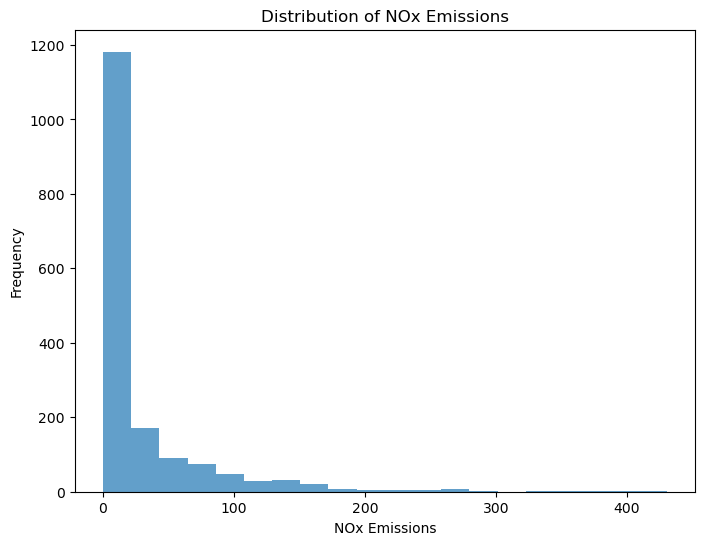

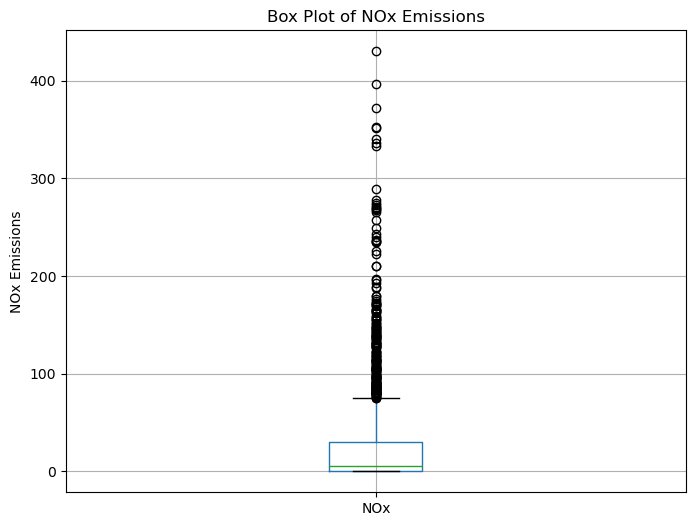


NOx Emissions by Borough and Year:
Borough               Year
Barking and Dagenham  2013     443.445381
                      2016     328.635230
                      2019     148.863918
                      2025      46.786511
Barnet                2013    1277.287386
                                 ...     
Waltham Forest        2025      65.857175
Wandsworth            2013     587.291248
                      2016     397.859139
                      2019     162.789487
                      2025      62.455497
Name: NOx, Length: 132, dtype: float64


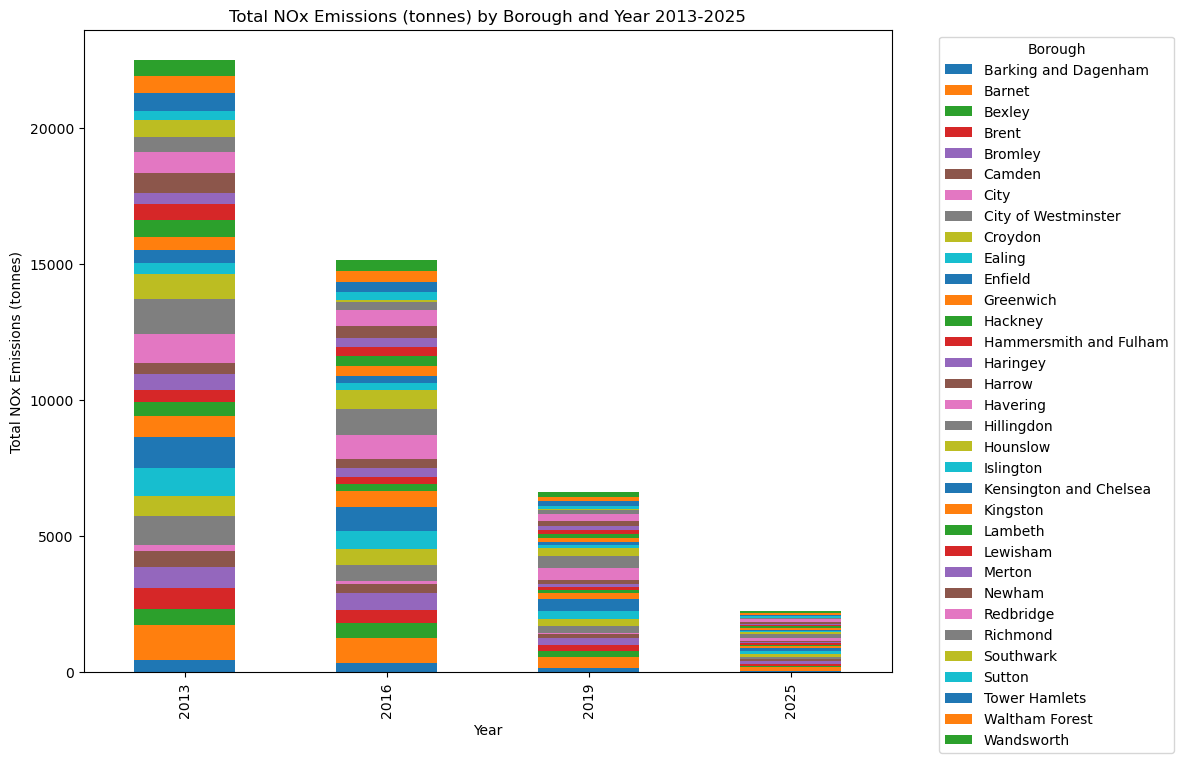


NOx Emissions by Transport Mode and Year:
Transport Mode       Year
Car - Diesel         2013    6188.109584
                     2016    5332.780414
                     2019    2140.827989
                     2025     595.015880
Car - Electric       2013       0.000000
                     2016       0.000000
                     2019       0.000000
                     2025       0.331327
Car - Petrol         2013    1916.753435
                     2016    1164.926247
                     2019     802.308467
                     2025     654.197503
HGV - Articulated    2013    1222.485963
                     2016     499.448985
                     2019     127.667387
                     2025      81.240034
HGV - Rigid          2013    2859.146080
                     2016    1269.785961
                     2019     404.345417
                     2025     191.675778
LGV - Diesel         2013    4352.309757
                     2016    3949.458489
                     2019    

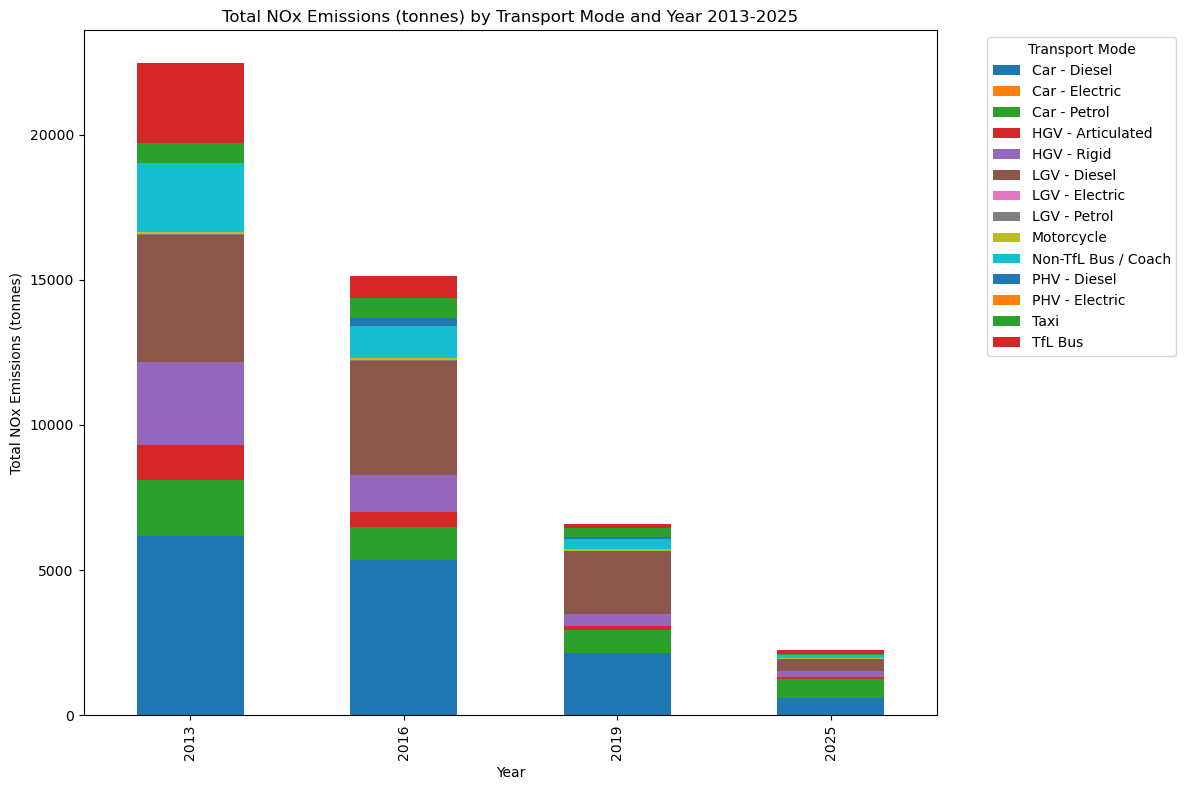


Top 5 Boroughs with Highest NOx Emissions:
Borough
Hillingdon    2802.270807
Barnet        2759.400267
Enfield       2583.323693
Havering      2467.379514
Ealing        2054.322023
Name: NOx, dtype: float64

Top 5 Transport Modes with Highest NOx Emissions:
Transport Mode
Car - Diesel           14256.733867
LGV - Diesel           10910.668063
HGV - Rigid             4724.953236
Car - Petrol            4538.185651
Non-TfL Bus / Coach     3941.135371
Name: NOx, dtype: float64


In [609]:
# 1. Descriptive Statistics
print("Overall NOx Descriptive Statistics:")
print(combined_nox_df['NOx'].describe())

plt.figure(figsize=(8, 6))
plt.hist(combined_nox_df['NOx'], bins=20, alpha=0.7)
plt.xlabel('NOx Emissions')
plt.ylabel('Frequency')
plt.title('Distribution of NOx Emissions')
plt.show()

plt.figure(figsize=(8, 6))
combined_nox_df.boxplot(column='NOx')
plt.ylabel('NOx Emissions')
plt.title('Box Plot of NOx Emissions')
plt.show()


# 2. Grouped Analysis
print("\nNOx Emissions by Borough and Year:")
print(combined_nox_df.groupby(['Borough', 'Year'])['NOx'].sum())

# Visualisation
borough_year_nox = combined_nox_df.groupby(['Borough', 'Year'])['NOx'].sum().reset_index()
plt.figure(figsize=(12, 8))
borough_year_nox.pivot(index='Year', columns='Borough', values='NOx').plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('Year')
plt.ylabel('Total NOx Emissions (tonnes)')
plt.title('Total NOx Emissions (tonnes) by Borough and Year 2013-2025')
plt.legend(title='Borough', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



print("\nNOx Emissions by Transport Mode and Year:")
print(combined_nox_df.groupby(['Transport Mode', 'Year'])['NOx'].sum())

# Visualisation
mode_year_nox = combined_nox_df.groupby(['Transport Mode', 'Year'])['NOx'].sum().reset_index()
plt.figure(figsize=(12, 8))
mode_year_nox.pivot(index='Year', columns='Transport Mode', values='NOx').plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('Year')
plt.ylabel('Total NOx Emissions (tonnes)')
plt.title('Total NOx Emissions (tonnes) by Transport Mode and Year 2013-2025')
plt.legend(title='Transport Mode', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Top borough analysis
n = 5
top_boroughs = combined_nox_df.groupby('Borough')['NOx'].sum().nlargest(n)
print(f"\nTop {n} Boroughs with Highest NOx Emissions:")
print(top_boroughs)

top_modes = combined_nox_df.groupby('Transport Mode')['NOx'].sum().nlargest(n)
print(f"\nTop {n} Transport Modes with Highest NOx Emissions:")
print(top_modes)


Pm10 2013-2025

In [610]:
LAEI_pm10_2013 = pd.read_excel('Copy of LAEI-2019-Emissions-Summary-including-Forecast.xlsx', 5, header=7)

In [611]:
print(LAEI_pm10_2013)

    Unnamed: 0                     Source     Central        Inner  \
0          NaN                   Domestic    5.553694   231.390649   
1          NaN                    Biomass    1.981989   145.726757   
2          NaN               Wood Burning    1.981989   145.726757   
3          NaN  Heat and Power Generation    3.571140    85.568764   
4          NaN             Gas Combustion    2.872756    64.994133   
..         ...                        ...         ...          ...   
60         NaN             PHV - Electric    0.050502     0.220972   
61         NaN               PHV - Petrol    3.260573    16.076612   
62         NaN                       Taxi    8.786402    20.815858   
63         NaN                    TfL Bus    6.090616    50.267561   
64         NaN         LAEI (Grand Total)  466.597716  2537.304631   

          Outer   Unnamed: 5   Unnamed: 6   Unnamed: 7  Unnamed: 8  \
0    581.323764   818.268107   151.025592   969.293699         NaN   
1    421.189134   5

In [612]:
new_LAEI_pm10_2013 = LAEI_pm10_2013.drop(columns=[ 'Unnamed: 0', 'Source', 'Central', 'Inner', 'Outer', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'])


In [613]:
new_LAEI_pm10_2013.drop(new_LAEI_pm10_2013.index[0:48], inplace=True)
new_LAEI_pm10_2013.drop(new_LAEI_pm10_2013.index[13], inplace=True)


In [614]:
print(new_LAEI_pm10_2013)

             Row Labels  Barking and Dagenham      Barnet     Bexley  \
48       Road Transport             46.786511  131.086864  64.551415   
49         Car - Diesel             12.304775   37.346412  18.483395   
50       Car - Electric              0.007073    0.021027   0.010284   
51         Car - Petrol             13.802089   41.159163  20.116582   
52    HGV - Articulated              2.846585    4.279036   2.600531   
53          HGV - Rigid              5.365921   10.043247   4.746052   
54         LGV - Diesel              8.864474   25.191137  12.719175   
55       LGV - Electric              0.003332    0.009072   0.004691   
56         LGV - Petrol              0.119096    0.325174   0.168082   
57           Motorcycle              0.247531    0.913374   0.424031   
58  Non-TfL Bus / Coach              0.921958    4.390623   2.017873   
59                 Taxi              0.231406    1.797478   0.336860   
60              TfL Bus              2.072270    5.611121   2.92

In [615]:
new_LAEI_pm10_2013 = new_LAEI_pm10_2013.reset_index()

In [616]:
new_LAEI_pm10_2013_long= new_LAEI_pm10_2013.melt(
    id_vars=['Row Labels'],    
    var_name='Borough',        
    value_name='Pm10'           
)


In [617]:
new_LAEI_pm10_2013_long['Year'] = 2013

In [618]:
new_LAEI_pm10_2013_long = new_LAEI_pm10_2013_long.rename(columns={'Row Labels': 'Transport Mode'})

In [619]:
print(new_LAEI_pm10_2013_long.head(20))

         Transport Mode               Borough       Pm10  Year
0        Road Transport                 index  48.000000  2013
1          Car - Diesel                 index  49.000000  2013
2        Car - Electric                 index  50.000000  2013
3          Car - Petrol                 index  51.000000  2013
4     HGV - Articulated                 index  52.000000  2013
5           HGV - Rigid                 index  53.000000  2013
6          LGV - Diesel                 index  54.000000  2013
7        LGV - Electric                 index  55.000000  2013
8          LGV - Petrol                 index  56.000000  2013
9            Motorcycle                 index  57.000000  2013
10  Non-TfL Bus / Coach                 index  58.000000  2013
11                 Taxi                 index  59.000000  2013
12              TfL Bus                 index  60.000000  2013
13                  NaN                 index  62.000000  2013
14                  NaN                 index  63.00000

In [620]:
new_LAEI_pm10_2013_long.drop(new_LAEI_pm10_2013_long.index[0:16], inplace=True)

In [621]:
new_LAEI_pm10_2013_long = new_LAEI_pm10_2013_long.reset_index()

In [622]:
new_LAEI_pm10_2013_long.drop(columns=['index'], inplace=True)

In [623]:
new_LAEI_pm10_2013_long.tail(50)

Transport Mode         Borough         Pm10  Year
510                  NaN  Waltham Forest          NaN  2013
511                  NaN  Waltham Forest          NaN  2013
512       Road Transport      Wandsworth    62.455497  2013
513         Car - Diesel      Wandsworth    16.040977  2013
514       Car - Electric      Wandsworth     0.009220  2013
515         Car - Petrol      Wandsworth    17.935134  2013
516    HGV - Articulated      Wandsworth     1.288177  2013
517          HGV - Rigid      Wandsworth     5.655185  2013
518         LGV - Diesel      Wandsworth    13.124710  2013
519       LGV - Electric      Wandsworth     0.005006  2013
520         LGV - Petrol      Wandsworth     0.178208  2013
521           Motorcycle      Wandsworth     1.102324  2013
522  Non-TfL Bus / Coach      Wandsworth     1.863367  2013
523                 Taxi      Wandsworth     1.208521  2013
524              TfL Bus      Wandsworth     4.044666  2013
525                  NaN      Wandsworth          NaN  2013
526                  NaN      Wandsworth          NaN  2013
527                  NaN      Wandsworth          NaN  2013
528       Road Transport         Non GLA   758.790837  2013
529         Car - Diesel         Non GLA   222.848688  2013
530       Car - Electric         Non GLA     0.068116  2013
531         Car - Petrol         Non GLA   184.452442  2013
532    HGV - Articulated         Non GLA   110.165349  2013
533          HGV - Rigid         Non GLA    63.463327  2013
534         LGV - Diesel         Non GLA   155.342276  2013
535       LGV - Electric         Non GLA     0.029590  2013
536         LGV - Petrol         Non GLA     2.114418  2013
537           Motorcycle         Non GLA     3.151321  2013
538  Non-TfL Bus / Coach         Non GLA    12.448148  2013
539                 Taxi         Non GLA     2.193455  2013
540              TfL Bus         Non GLA     2.513707  2013
541                  NaN         Non GLA          NaN  2013
542                  NaN         Non GLA          NaN  2013
543                  NaN         Non GLA          NaN  2013
544       Road Transport     Grand Total  3058.328923  2013
545         Car - Diesel     Grand Total   831.521643  2013
546       Car - Electric     Grand Total     0.407154  2013
547         Car - Petrol     Grand Total   853.640878  2013
548    HGV - Articulated     Grand Total   192.553903  2013
549          HGV - Rigid     Grand Total   261.098823  2013
550         LGV - Diesel     Grand Total   590.560201  2013
551       LGV - Electric     Grand Total     0.188119  2013
552         LGV - Petrol     Grand Total     7.925338  2013
553           Motorcycle     Grand Total    25.481457  2013
554  Non-TfL Bus / Coach     Grand Total   100.198947  2013
555                 Taxi     Grand Total    63.816679  2013
556              TfL Bus     Grand Total   130.935783  2013
557                  NaN     Grand Total          NaN  2013
558                  NaN     Grand Total          NaN  2013
559                  NaN     Grand Total          NaN  2013

In [624]:
new_LAEI_pm10_2013_long.drop(index=range(525, 560), inplace=True)

In [625]:
new_LAEI_pm10_2013_long.tail(50)

Transport Mode         Borough       Pm10  Year
475                 Taxi          Sutton   0.221590  2013
476              TfL Bus          Sutton   1.945754  2013
477                  NaN          Sutton        NaN  2013
478                  NaN          Sutton        NaN  2013
479                  NaN          Sutton        NaN  2013
480       Road Transport   Tower Hamlets  64.623559  2013
481         Car - Diesel   Tower Hamlets  14.414061  2013
482       Car - Electric   Tower Hamlets   0.008277  2013
483         Car - Petrol   Tower Hamlets  16.119061  2013
484    HGV - Articulated   Tower Hamlets   1.698848  2013
485          HGV - Rigid   Tower Hamlets   8.545582  2013
486         LGV - Diesel   Tower Hamlets  14.375431  2013
487       LGV - Electric   Tower Hamlets   0.005422  2013
488         LGV - Petrol   Tower Hamlets   0.193279  2013
489           Motorcycle   Tower Hamlets   0.992230  2013
490  Non-TfL Bus / Coach   Tower Hamlets   2.347568  2013
491                 Taxi   Tower Hamlets   2.544654  2013
492              TfL Bus   Tower Hamlets   3.379145  2013
493                  NaN   Tower Hamlets        NaN  2013
494                  NaN   Tower Hamlets        NaN  2013
495                  NaN   Tower Hamlets        NaN  2013
496       Road Transport  Waltham Forest  65.857175  2013
497         Car - Diesel  Waltham Forest  18.070962  2013
498       Car - Electric  Waltham Forest   0.010121  2013
499         Car - Petrol  Waltham Forest  19.783696  2013
500    HGV - Articulated  Waltham Forest   1.788462  2013
501          HGV - Rigid  Waltham Forest   5.536308  2013
502         LGV - Diesel  Waltham Forest  13.041658  2013
503       LGV - Electric  Waltham Forest   0.004748  2013
504         LGV - Petrol  Waltham Forest   0.169975  2013
505           Motorcycle  Waltham Forest   0.451309  2013
506  Non-TfL Bus / Coach  Waltham Forest   1.792992  2013
507                 Taxi  Waltham Forest   1.870077  2013
508              TfL Bus  Waltham Forest   3.336867  2013
509                  NaN  Waltham Forest        NaN  2013
510                  NaN  Waltham Forest        NaN  2013
511                  NaN  Waltham Forest        NaN  2013
512       Road Transport      Wandsworth  62.455497  2013
513         Car - Diesel      Wandsworth  16.040977  2013
514       Car - Electric      Wandsworth   0.009220  2013
515         Car - Petrol      Wandsworth  17.935134  2013
516    HGV - Articulated      Wandsworth   1.288177  2013
517          HGV - Rigid      Wandsworth   5.655185  2013
518         LGV - Diesel      Wandsworth  13.124710  2013
519       LGV - Electric      Wandsworth   0.005006  2013
520         LGV - Petrol      Wandsworth   0.178208  2013
521           Motorcycle      Wandsworth   1.102324  2013
522  Non-TfL Bus / Coach      Wandsworth   1.863367  2013
523                 Taxi      Wandsworth   1.208521  2013
524              TfL Bus      Wandsworth   4.044666  2013

In [626]:
LAEI_pm10_2016 = pd.read_excel('Copy of LAEI-2019-Emissions-Summary-including-Forecast.xlsx', 6, header=7)

In [627]:
print(LAEI_pm10_2016)

    Unnamed: 0                     Source     Central        Inner  \
0          NaN                   Domestic    5.553694   231.390649   
1          NaN                    Biomass    1.981989   145.726757   
2          NaN               Wood Burning    1.981989   145.726757   
3          NaN  Heat and Power Generation    3.571140    85.568764   
4          NaN             Gas Combustion    2.872756    64.994133   
..         ...                        ...         ...          ...   
60         NaN             PHV - Electric    0.050502     0.220972   
61         NaN               PHV - Petrol    3.260573    16.076612   
62         NaN                       Taxi    8.786402    20.815858   
63         NaN                    TfL Bus    6.090616    50.267561   
64         NaN         LAEI (Grand Total)  466.597716  2537.304631   

          Outer   Unnamed: 5   Unnamed: 6   Unnamed: 7  Unnamed: 8  \
0    581.323764   818.268107   151.025592   969.293699         NaN   
1    421.189134   5

In [628]:
new_LAEI_pm10_2016 = LAEI_pm10_2016.drop(columns=[ 'Unnamed: 0', 'Source', 'Central', 'Inner', 'Outer', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'])


In [629]:
new_LAEI_pm10_2016.drop(new_LAEI_pm10_2016.index[0:48], inplace=True)
new_LAEI_pm10_2016.drop(new_LAEI_pm10_2016.index[13], inplace=True)


In [630]:
new_LAEI_pm10_2016 = new_LAEI_pm10_2016.reset_index()

In [631]:
new_LAEI_pm10_2016_long= new_LAEI_pm10_2016.melt(
    id_vars=['Row Labels'],    
    var_name='Borough',        
    value_name='Pm10'           
)


In [632]:
new_LAEI_pm10_2016_long['Year'] = 2016

In [633]:
new_LAEI_pm10_2016_long = new_LAEI_pm10_2016_long.rename(columns={'Row Labels': 'Transport Mode'})

In [634]:
print(new_LAEI_pm10_2016_long.head(20))

         Transport Mode               Borough       Pm10  Year
0        Road Transport                 index  48.000000  2016
1          Car - Diesel                 index  49.000000  2016
2        Car - Electric                 index  50.000000  2016
3          Car - Petrol                 index  51.000000  2016
4     HGV - Articulated                 index  52.000000  2016
5           HGV - Rigid                 index  53.000000  2016
6          LGV - Diesel                 index  54.000000  2016
7        LGV - Electric                 index  55.000000  2016
8          LGV - Petrol                 index  56.000000  2016
9            Motorcycle                 index  57.000000  2016
10  Non-TfL Bus / Coach                 index  58.000000  2016
11                 Taxi                 index  59.000000  2016
12              TfL Bus                 index  60.000000  2016
13                  NaN                 index  62.000000  2016
14                  NaN                 index  63.00000

In [635]:
new_LAEI_pm10_2016_long.drop(new_LAEI_pm10_2016_long.index[0:16], inplace=True)

In [636]:
new_LAEI_pm10_2016_long = new_LAEI_pm10_2016_long.reset_index()

In [637]:
new_LAEI_pm10_2016_long.drop(columns=['index'], inplace=True)

In [638]:
new_LAEI_pm10_2016_long.drop(index=range(525, 560), inplace=True)

In [639]:
new_LAEI_pm10_2016_long.tail(50)

Transport Mode         Borough       Pm10  Year
475                 Taxi          Sutton   0.205305  2016
476              TfL Bus          Sutton   2.016294  2016
477                  NaN          Sutton        NaN  2016
478                  NaN          Sutton        NaN  2016
479                  NaN          Sutton        NaN  2016
480       Road Transport   Tower Hamlets  61.964166  2016
481         Car - Diesel   Tower Hamlets  14.026452  2016
482       Car - Electric   Tower Hamlets   0.042439  2016
483         Car - Petrol   Tower Hamlets  15.293785  2016
484    HGV - Articulated   Tower Hamlets   1.613094  2016
485          HGV - Rigid   Tower Hamlets   8.180636  2016
486         LGV - Diesel   Tower Hamlets  13.902464  2016
487       LGV - Electric   Tower Hamlets   0.017795  2016
488         LGV - Petrol   Tower Hamlets   0.137563  2016
489           Motorcycle   Tower Hamlets   0.878448  2016
490  Non-TfL Bus / Coach   Tower Hamlets   2.200610  2016
491                 Taxi   Tower Hamlets   2.395338  2016
492              TfL Bus   Tower Hamlets   3.275543  2016
493                  NaN   Tower Hamlets        NaN  2016
494                  NaN   Tower Hamlets        NaN  2016
495                  NaN   Tower Hamlets        NaN  2016
496       Road Transport  Waltham Forest  62.785995  2016
497         Car - Diesel  Waltham Forest  17.577022  2016
498       Car - Electric  Waltham Forest   0.051869  2016
499         Car - Petrol  Waltham Forest  18.976967  2016
500    HGV - Articulated  Waltham Forest   1.676721  2016
501          HGV - Rigid  Waltham Forest   5.265582  2016
502         LGV - Diesel  Waltham Forest  12.011122  2016
503       LGV - Electric  Waltham Forest   0.014878  2016
504         LGV - Petrol  Waltham Forest   0.117292  2016
505           Motorcycle  Waltham Forest   0.401938  2016
506  Non-TfL Bus / Coach  Waltham Forest   1.669570  2016
507                 Taxi  Waltham Forest   1.698814  2016
508              TfL Bus  Waltham Forest   3.324220  2016
509                  NaN  Waltham Forest        NaN  2016
510                  NaN  Waltham Forest        NaN  2016
511                  NaN  Waltham Forest        NaN  2016
512       Road Transport      Wandsworth  59.517653  2016
513         Car - Diesel      Wandsworth  15.465690  2016
514       Car - Electric      Wandsworth   0.046346  2016
515         Car - Petrol      Wandsworth  16.893974  2016
516    HGV - Articulated      Wandsworth   1.231304  2016
517          HGV - Rigid      Wandsworth   5.485553  2016
518         LGV - Diesel      Wandsworth  12.270261  2016
519       LGV - Electric      Wandsworth   0.015618  2016
520         LGV - Petrol      Wandsworth   0.122411  2016
521           Motorcycle      Wandsworth   0.973340  2016
522  Non-TfL Bus / Coach      Wandsworth   1.765234  2016
523                 Taxi      Wandsworth   1.191256  2016
524              TfL Bus      Wandsworth   4.056667  2016

In [640]:
#2019
LAEI_pm10_2019 = pd.read_excel('Copy of LAEI-2019-Emissions-Summary-including-Forecast.xlsx', 7, header=7)

In [641]:
print(LAEI_pm10_2019)

    Unnamed: 0                     Source     Central        Inner  \
0          NaN                   Domestic    5.553694   231.390649   
1          NaN                    Biomass    1.981989   145.726757   
2          NaN               Wood Burning    1.981989   145.726757   
3          NaN  Heat and Power Generation    3.571140    85.568764   
4          NaN             Gas Combustion    2.872756    64.994133   
..         ...                        ...         ...          ...   
60         NaN             PHV - Electric    0.050502     0.220972   
61         NaN               PHV - Petrol    3.260573    16.076612   
62         NaN                       Taxi    8.786402    20.815858   
63         NaN                    TfL Bus    6.090616    50.267561   
64         NaN         LAEI (Grand Total)  466.597716  2537.304631   

          Outer   Unnamed: 5   Unnamed: 6   Unnamed: 7  Unnamed: 8  \
0    581.323764   818.268107   151.025592   969.293699         NaN   
1    421.189134   5

In [642]:
new_LAEI_pm10_2019 = LAEI_pm10_2019.drop(columns=[ 'Unnamed: 0', 'Source', 'Central', 'Inner', 'Outer', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'])


In [643]:
new_LAEI_pm10_2019.drop(new_LAEI_pm10_2019.index[0:48], inplace=True)

In [644]:
new_LAEI_pm10_2019.drop(new_LAEI_pm10_2019.index[13], inplace=True)

In [645]:
new_LAEI_pm10_2019 = new_LAEI_pm10_2019.reset_index()

In [646]:
new_LAEI_pm10_2019_long= new_LAEI_pm10_2019.melt(
    id_vars=['Row Labels'],    
    var_name='Borough',        
    value_name='Pm10'           
)


In [647]:
new_LAEI_pm10_2019_long['Year'] = 2019

In [648]:
new_LAEI_pm10_2019_long = new_LAEI_pm10_2019_long.rename(columns={'Row Labels': 'Transport Mode'})

In [649]:
new_LAEI_pm10_2019_long.drop(new_LAEI_pm10_2019_long.index[0:16], inplace=True)

In [650]:
new_LAEI_pm10_2019_long = new_LAEI_pm10_2019_long.reset_index()

In [651]:
new_LAEI_pm10_2019_long.drop(columns=['index'], inplace=True)

In [652]:
new_LAEI_pm10_2019_long.drop(index=range(525, 560), inplace=True)

In [653]:
print(new_LAEI_pm10_2019_long.head(50))

         Transport Mode               Borough        Pm10  Year
0        Road Transport  Barking and Dagenham   43.687109  2019
1          Car - Diesel  Barking and Dagenham   11.188013  2019
2        Car - Electric  Barking and Dagenham    0.074237  2019
3          Car - Petrol  Barking and Dagenham   12.808324  2019
4     HGV - Articulated  Barking and Dagenham    2.006612  2019
5           HGV - Rigid  Barking and Dagenham    4.795977  2019
6          LGV - Diesel  Barking and Dagenham    7.324094  2019
7        LGV - Electric  Barking and Dagenham    0.013434  2019
8          LGV - Petrol  Barking and Dagenham    0.053893  2019
9            Motorcycle  Barking and Dagenham    0.280386  2019
10  Non-TfL Bus / Coach  Barking and Dagenham    1.306386  2019
11         PHV - Diesel  Barking and Dagenham    0.393413  2019
12       PHV - Electric  Barking and Dagenham    0.006124  2019
13                 Taxi  Barking and Dagenham    0.463569  2019
14              TfL Bus  Barking and Dag

In [654]:
LAEI_pm10_2025 = pd.read_excel('Copy of LAEI-2019-Emissions-Summary-including-Forecast.xlsx', 8, header=7)

In [655]:
print(LAEI_pm10_2025)

    Unnamed: 0                     Source     Central        Inner  \
0          NaN                   Domestic    5.553694   231.390649   
1          NaN                    Biomass    1.981989   145.726757   
2          NaN               Wood Burning    1.981989   145.726757   
3          NaN  Heat and Power Generation    3.571140    85.568764   
4          NaN             Gas Combustion    2.872756    64.994133   
..         ...                        ...         ...          ...   
60         NaN             PHV - Electric    0.050502     0.220972   
61         NaN               PHV - Petrol    3.260573    16.076612   
62         NaN                       Taxi    8.786402    20.815858   
63         NaN                    TfL Bus    6.090616    50.267561   
64         NaN         LAEI (Grand Total)  466.597716  2537.304631   

          Outer   Unnamed: 5   Unnamed: 6   Unnamed: 7  Unnamed: 8  \
0    581.323764   818.268107   151.025592   969.293699         NaN   
1    421.189134   5

In [656]:
new_LAEI_pm10_2025 = LAEI_pm10_2025.drop(columns=[ 'Unnamed: 0', 'Source', 'Central', 'Inner', 'Outer', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'])


In [657]:
new_LAEI_pm10_2025.drop(new_LAEI_pm10_2025.index[0:48], inplace=True)

In [658]:
new_LAEI_pm10_2025.drop(new_LAEI_pm10_2025.index[13], inplace=True)

In [659]:
new_LAEI_pm10_2025 = new_LAEI_pm10_2025.reset_index()

In [660]:
new_LAEI_pm10_2025_long= new_LAEI_pm10_2025.melt(
    id_vars=['Row Labels'],    
    var_name='Borough',        
    value_name='Pm10'           
)


In [661]:
new_LAEI_pm10_2025_long['Year'] = 2025

In [662]:
new_LAEI_pm10_2025_long = new_LAEI_pm10_2025_long.rename(columns={'Row Labels': 'Transport Mode'})

In [663]:
print(new_LAEI_pm10_2025_long.head(20))

         Transport Mode               Borough       Pm10  Year
0        Road Transport                 index  48.000000  2025
1          Car - Diesel                 index  49.000000  2025
2        Car - Electric                 index  50.000000  2025
3          Car - Petrol                 index  51.000000  2025
4     HGV - Articulated                 index  52.000000  2025
5           HGV - Rigid                 index  53.000000  2025
6          LGV - Diesel                 index  54.000000  2025
7        LGV - Electric                 index  55.000000  2025
8          LGV - Petrol                 index  56.000000  2025
9            Motorcycle                 index  57.000000  2025
10  Non-TfL Bus / Coach                 index  58.000000  2025
11         PHV - Diesel                 index  59.000000  2025
12       PHV - Electric                 index  60.000000  2025
13                 Taxi                 index  62.000000  2025
14              TfL Bus                 index  63.00000

In [664]:
new_LAEI_pm10_2025_long.drop(new_LAEI_pm10_2025_long.index[0:16], inplace=True)

In [665]:
new_LAEI_pm10_2025_long = new_LAEI_pm10_2025_long.reset_index()

In [666]:
new_LAEI_pm10_2025_long.drop(columns=['index'], inplace=True)

In [667]:
new_LAEI_pm10_2025_long.drop(index=range(525, 560), inplace=True)

In [668]:
#combining pm10 dataframes
dataframes = [new_LAEI_pm10_2013_long,
              new_LAEI_pm10_2016_long,
              new_LAEI_pm10_2019_long,
              new_LAEI_pm10_2025_long]

In [669]:
combined_pm10_df = pd.concat(dataframes, ignore_index=True)

In [670]:
modes_to_remove = ['Road Transport', 'Grand Total']

In [671]:
combined_pm10_df = combined_pm10_df[~combined_pm10_df['Transport Mode'].isin(modes_to_remove)]

In [672]:
print(combined_pm10_df.head())
print(f"Shape of the combined DataFrame: {combined_pm10_df.shape}")

      Transport Mode               Borough       Pm10  Year
1       Car - Diesel  Barking and Dagenham  12.304775  2013
2     Car - Electric  Barking and Dagenham   0.007073  2013
3       Car - Petrol  Barking and Dagenham  13.802089  2013
4  HGV - Articulated  Barking and Dagenham   2.846585  2013
5        HGV - Rigid  Barking and Dagenham   5.365921  2013
Shape of the combined DataFrame: (1904, 4)


In [673]:
print(combined_pm10_df.tail())

           Transport Mode     Borough      Pm10  Year
2095         LGV - Petrol  Wandsworth  0.151390  2025
2096           Motorcycle  Wandsworth  0.492426  2025
2097  Non-TfL Bus / Coach  Wandsworth  1.606608  2025
2098         PHV - Diesel  Wandsworth  0.379396  2025
2099       PHV - Electric  Wandsworth  0.225672  2025


Overall Pm10 Descriptive Statistics:
count    1712.000000
mean        4.751449
std         7.134334
min         0.000958
25%         0.259656
50%         1.542797
75%         6.032001
max        41.159163
Name: Pm10, dtype: float64


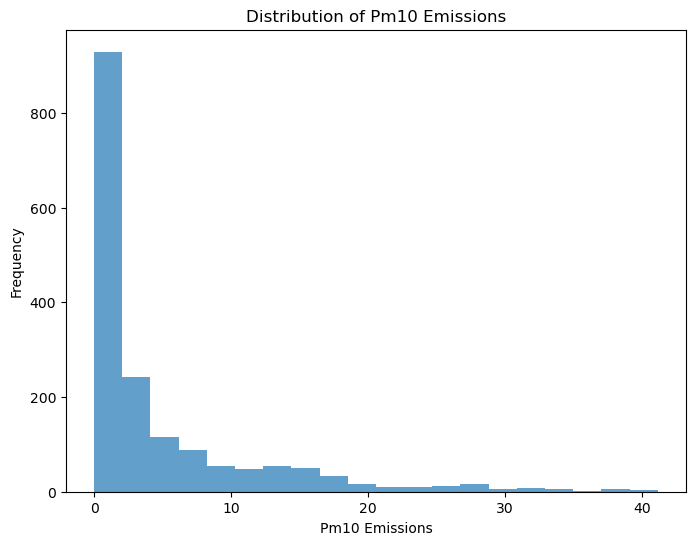

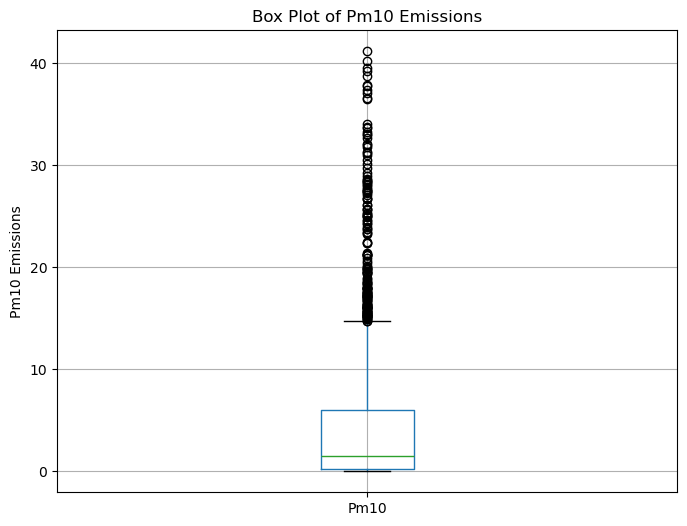


Pm10 Emissions (tonnes) by Borough and Year 2013 - 2025
Borough               Year
Barking and Dagenham  2013     46.786511
                      2016     45.540511
                      2019     43.239651
                      2025     38.732878
Barnet                2013    131.086864
                                 ...    
Waltham Forest        2025     47.885535
Wandsworth            2013     62.455497
                      2016     59.517653
                      2019     48.457715
                      2025     38.944649
Name: Pm10, Length: 132, dtype: float64


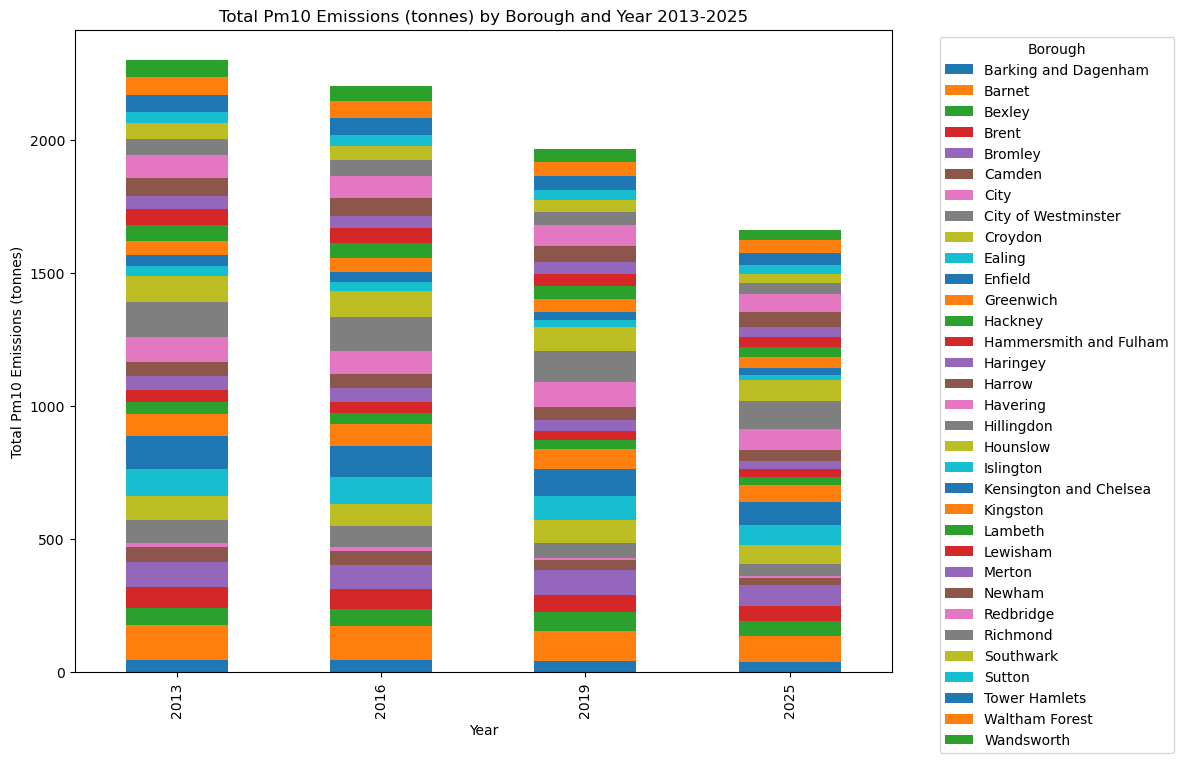


Pm10 Emissions by Transport Mode and Year:
Transport Mode       Year
Car - Diesel         2013    608.672954
                     2016    598.189452
                     2019    520.606833
                     2025    282.148969
Car - Electric       2013      0.339038
                     2016      1.790301
                     2019      4.187386
                     2025     60.848529
Car - Petrol         2013    669.188436
                     2016    642.221347
                     2019    590.931954
                     2025    551.617231
HGV - Articulated    2013     82.388553
                     2016     75.982485
                     2019     63.612190
                     2025     56.626802
HGV - Rigid          2013    197.635496
                     2016    189.331726
                     2019    170.480655
                     2025    153.513571
LGV - Diesel         2013    435.217925
                     2016    405.744306
                     2019    341.168188
          

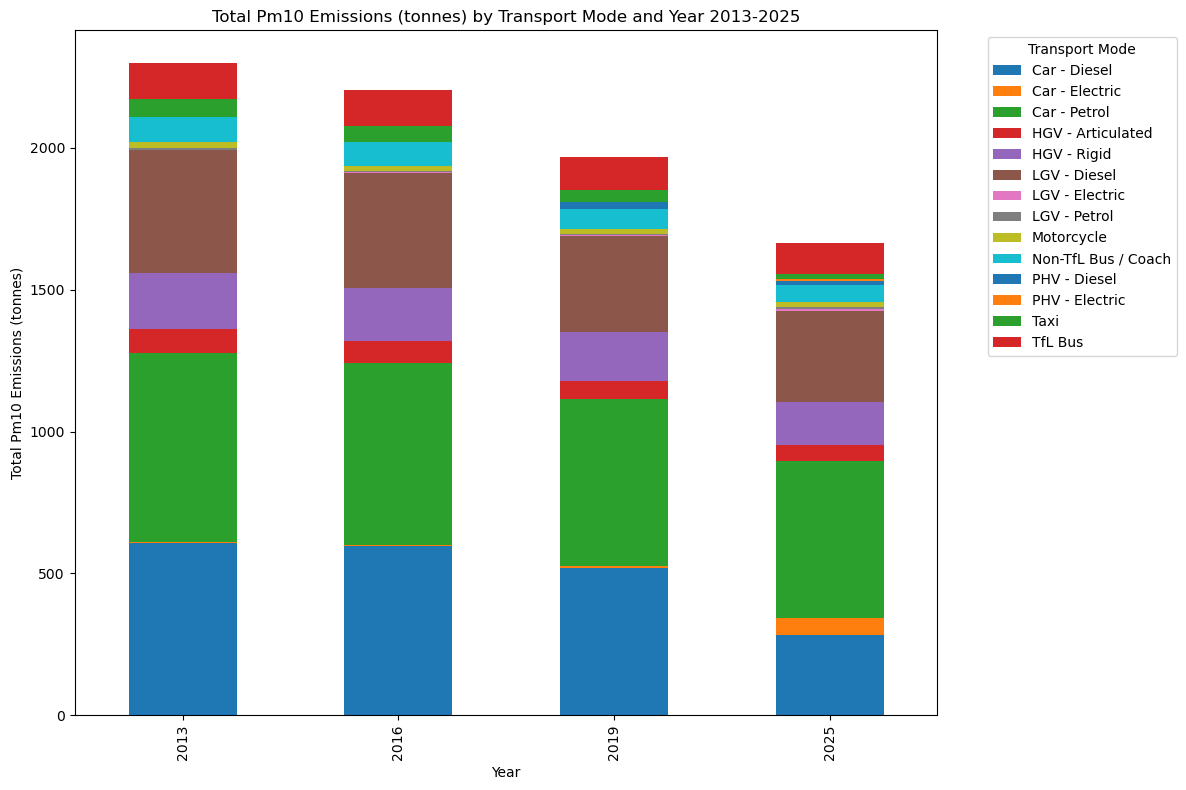


Top 5 Boroughs with Highest Pm10 Emissions:
Borough
Hillingdon    475.699973
Barnet        467.007427
Enfield       429.272715
Ealing        367.980240
Hounslow      363.453675
Name: Pm10, dtype: float64

Top 5 Transport Modes with Highest Pm10 Emissions:
Transport Mode
Car - Petrol    2453.958968
Car - Diesel    2009.618208
LGV - Diesel    1501.895810
HGV - Rigid      710.961447
TfL Bus          478.937677
Name: Pm10, dtype: float64


In [674]:
# 1. Descriptive Statistics for Pm10
print("Overall Pm10 Descriptive Statistics:")
print(combined_pm10_df['Pm10'].describe())

plt.figure(figsize=(8, 6))
plt.hist(combined_pm10_df['Pm10'], bins=20, alpha=0.7)
plt.xlabel('Pm10 Emissions')
plt.ylabel('Frequency')
plt.title('Distribution of Pm10 Emissions')
plt.show()

plt.figure(figsize=(8, 6))
combined_pm10_df.boxplot(column='Pm10')
plt.ylabel('Pm10 Emissions')
plt.title('Box Plot of Pm10 Emissions')
plt.show()


# 2. Grouped Analysis for Pm10
print("\nPm10 Emissions (tonnes) by Borough and Year 2013 - 2025")
print(combined_pm10_df.groupby(['Borough', 'Year'])['Pm10'].sum())

# Visualisation
borough_year_pm10 = combined_pm10_df.groupby(['Borough', 'Year'])['Pm10'].sum().reset_index()
plt.figure(figsize=(12, 8))
borough_year_pm10.pivot(index='Year', columns='Borough', values='Pm10').plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('Year')
plt.ylabel('Total Pm10 Emissions (tonnes)')
plt.title('Total Pm10 Emissions (tonnes) by Borough and Year 2013-2025')
plt.legend(title='Borough', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



print("\nPm10 Emissions by Transport Mode and Year:")
print(combined_pm10_df.groupby(['Transport Mode', 'Year'])['Pm10'].sum())

# Visualisation
mode_year_pm10 = combined_pm10_df.groupby(['Transport Mode', 'Year'])['Pm10'].sum().reset_index()
plt.figure(figsize=(12, 8))
mode_year_pm10.pivot(index='Year', columns='Transport Mode', values='Pm10').plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('Year')
plt.ylabel('Total Pm10 Emissions (tonnes)')
plt.title('Total Pm10 Emissions (tonnes) by Transport Mode and Year 2013-2025')
plt.legend(title='Transport Mode', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Top borough analysis for Pm10
n = 5
top_boroughs_pm10 = combined_pm10_df.groupby('Borough')['Pm10'].sum().nlargest(n)
print(f"\nTop {n} Boroughs with Highest Pm10 Emissions:")
print(top_boroughs_pm10)

top_modes_pm10 = combined_pm10_df.groupby('Transport Mode')['Pm10'].sum().nlargest(n)
print(f"\nTop {n} Transport Modes with Highest Pm10 Emissions:")
print(top_modes_pm10)

In [675]:
LAEI_pm025_2013 = pd.read_excel('Copy of LAEI-2019-Emissions-Summary-including-Forecast.xlsx', 9, header=7)

In [676]:
print(LAEI_pm025_2013)

    Unnamed: 0                     Source     Central        Inner  \
0          NaN                   Domestic    5.544289   231.092625   
1          NaN                    Biomass    1.981989   145.726757   
2          NaN               Wood Burning    1.981989   145.726757   
3          NaN  Heat and Power Generation    3.561735    85.270740   
4          NaN             Gas Combustion    2.872756    64.994133   
..         ...                        ...         ...          ...   
60         NaN             PHV - Electric    0.022836     0.100159   
61         NaN               PHV - Petrol    1.526651     7.531987   
62         NaN                       Taxi    5.353915    11.965310   
63         NaN                    TfL Bus    2.710319    22.656792   
64         NaN         LAEI (Grand Total)  224.389177  1115.152358   

          Outer   Unnamed: 5  Unnamed: 6   Unnamed: 7  Unnamed: 8  Unnamed: 9  \
0    580.625336   817.262250  150.570775   967.833025         NaN         NaN 

In [677]:
new_LAEI_pm025_2013 = LAEI_pm025_2013.drop(columns=[ 'Unnamed: 0', 'Source', 'Central', 'Inner', 'Outer', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'])


In [678]:
new_LAEI_pm025_2013.drop(new_LAEI_pm025_2013.index[0:48], inplace=True)

In [679]:
new_LAEI_pm025_2013.drop(new_LAEI_pm025_2013.index[13], inplace=True)

In [680]:
new_LAEI_pm025_2013 = new_LAEI_pm025_2013.reset_index()

In [681]:
new_LAEI_pm025_2013_long= new_LAEI_pm025_2013.melt(
    id_vars=['Row Labels'],    
    var_name='Borough',        
    value_name='Pm025'           
)


In [682]:
new_LAEI_pm025_2013_long['Year'] = 2013

In [683]:
new_LAEI_pm025_2013_long = new_LAEI_pm025_2013_long.rename(columns={'Row Labels': 'Transport Mode'})

In [684]:
print(new_LAEI_pm025_2013_long.head(20))

         Transport Mode               Borough      Pm025  Year
0        Road Transport                 index  48.000000  2013
1          Car - Diesel                 index  49.000000  2013
2        Car - Electric                 index  50.000000  2013
3          Car - Petrol                 index  51.000000  2013
4     HGV - Articulated                 index  52.000000  2013
5           HGV - Rigid                 index  53.000000  2013
6          LGV - Diesel                 index  54.000000  2013
7        LGV - Electric                 index  55.000000  2013
8          LGV - Petrol                 index  56.000000  2013
9            Motorcycle                 index  57.000000  2013
10  Non-TfL Bus / Coach                 index  58.000000  2013
11                 Taxi                 index  59.000000  2013
12              TfL Bus                 index  60.000000  2013
13                  NaN                 index  62.000000  2013
14                  NaN                 index  63.00000

In [685]:
new_LAEI_pm025_2013_long.drop(new_LAEI_pm025_2013_long.index[0:16], inplace=True)

In [686]:
new_LAEI_pm025_2013_long = new_LAEI_pm025_2013_long.reset_index()

In [687]:
new_LAEI_pm025_2013_long.drop(columns=['index'], inplace=True)

In [688]:
new_LAEI_pm025_2013_long.drop(index=range(525, 560), inplace=True)

In [689]:
print(new_LAEI_pm025_2013_long.tail(20))

          Transport Mode         Borough      Pm025  Year
505           Motorcycle  Waltham Forest   0.287940  2013
506  Non-TfL Bus / Coach  Waltham Forest   1.061334  2013
507                 Taxi  Waltham Forest   1.323652  2013
508              TfL Bus  Waltham Forest   1.743309  2013
509                  NaN  Waltham Forest        NaN  2013
510                  NaN  Waltham Forest        NaN  2013
511                  NaN  Waltham Forest        NaN  2013
512       Road Transport      Wandsworth  35.103582  2013
513         Car - Diesel      Wandsworth  10.107227  2013
514       Car - Electric      Wandsworth   0.004175  2013
515         Car - Petrol      Wandsworth   8.393593  2013
516    HGV - Articulated      Wandsworth   0.744772  2013
517          HGV - Rigid      Wandsworth   2.946869  2013
518         LGV - Diesel      Wandsworth   8.123897  2013
519       LGV - Electric      Wandsworth   0.002270  2013
520         LGV - Petrol      Wandsworth   0.082857  2013
521           

In [690]:
LAEI_pm025_2016 = pd.read_excel('Copy of LAEI-2019-Emissions-Summary-including-Forecast.xlsx', 10, header=7)

In [691]:
print(LAEI_pm025_2016)

    Unnamed: 0                     Source     Central        Inner  \
0          NaN                   Domestic    5.544289   231.092625   
1          NaN                    Biomass    1.981989   145.726757   
2          NaN               Wood Burning    1.981989   145.726757   
3          NaN  Heat and Power Generation    3.561735    85.270740   
4          NaN             Gas Combustion    2.872756    64.994133   
..         ...                        ...         ...          ...   
60         NaN             PHV - Electric    0.022836     0.100159   
61         NaN               PHV - Petrol    1.526651     7.531987   
62         NaN                       Taxi    5.353915    11.965310   
63         NaN                    TfL Bus    2.710319    22.656792   
64         NaN         LAEI (Grand Total)  224.389177  1115.152358   

          Outer   Unnamed: 5  Unnamed: 6   Unnamed: 7  Unnamed: 8  Unnamed: 9  \
0    580.625336   817.262250  150.570775   967.833025         NaN         NaN 

In [692]:
new_LAEI_pm025_2016 = LAEI_pm025_2016.drop(columns=[ 'Unnamed: 0', 'Source', 'Central', 'Inner', 'Outer', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'])


In [693]:
new_LAEI_pm025_2016.drop(new_LAEI_pm025_2016.index[0:48], inplace=True)

In [694]:
new_LAEI_pm025_2016.drop(new_LAEI_pm025_2016.index[13], inplace=True)

In [695]:
new_LAEI_pm025_2016 = new_LAEI_pm025_2016.reset_index()

In [696]:
new_LAEI_pm025_2016_long= new_LAEI_pm025_2016.melt(
    id_vars=['Row Labels'],    
    var_name='Borough',        
    value_name='Pm025'           
)


In [697]:
new_LAEI_pm025_2016_long['Year'] = 2016

In [698]:
new_LAEI_pm025_2016_long = new_LAEI_pm025_2016_long.rename(columns={'Row Labels': 'Transport Mode'})

In [699]:
new_LAEI_pm025_2016_long.drop(new_LAEI_pm025_2016_long.index[0:16], inplace=True)

In [700]:
new_LAEI_pm025_2016_long = new_LAEI_pm025_2016_long.reset_index()

In [701]:
new_LAEI_pm025_2016_long.drop(columns=['index'], inplace=True)

In [702]:
new_LAEI_pm025_2016_long.drop(index=range(525, 560), inplace=True)

In [703]:
print(new_LAEI_pm025_2016_long.tail(20))

          Transport Mode         Borough      Pm025  Year
505           Motorcycle  Waltham Forest   0.238321  2016
506  Non-TfL Bus / Coach  Waltham Forest   0.932493  2016
507                 Taxi  Waltham Forest   1.149713  2016
508              TfL Bus  Waltham Forest   1.731514  2016
509                  NaN  Waltham Forest        NaN  2016
510                  NaN  Waltham Forest        NaN  2016
511                  NaN  Waltham Forest        NaN  2016
512       Road Transport      Wandsworth  31.918551  2016
513         Car - Diesel      Wandsworth   9.130320  2016
514       Car - Electric      Wandsworth   0.020988  2016
515         Car - Petrol      Wandsworth   7.895583  2016
516    HGV - Articulated      Wandsworth   0.672854  2016
517          HGV - Rigid      Wandsworth   2.697994  2016
518         LGV - Diesel      Wandsworth   7.020280  2016
519       LGV - Electric      Wandsworth   0.007081  2016
520         LGV - Petrol      Wandsworth   0.056817  2016
521           

In [704]:
LAEI_pm025_2019 = pd.read_excel('Copy of LAEI-2019-Emissions-Summary-including-Forecast.xlsx', 11, header=7)

In [705]:
print(LAEI_pm025_2019)

    Unnamed: 0                     Source     Central        Inner  \
0          NaN                   Domestic    5.544289   231.092625   
1          NaN                    Biomass    1.981989   145.726757   
2          NaN               Wood Burning    1.981989   145.726757   
3          NaN  Heat and Power Generation    3.561735    85.270740   
4          NaN             Gas Combustion    2.872756    64.994133   
..         ...                        ...         ...          ...   
60         NaN             PHV - Electric    0.022836     0.100159   
61         NaN               PHV - Petrol    1.526651     7.531987   
62         NaN                       Taxi    5.353915    11.965310   
63         NaN                    TfL Bus    2.710319    22.656792   
64         NaN         LAEI (Grand Total)  224.389177  1115.152358   

          Outer   Unnamed: 5  Unnamed: 6   Unnamed: 7  Unnamed: 8  Unnamed: 9  \
0    580.625336   817.262250  150.570775   967.833025         NaN         NaN 

In [706]:
new_LAEI_pm025_2019 = LAEI_pm025_2019.drop(columns=[ 'Unnamed: 0', 'Source', 'Central', 'Inner', 'Outer', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'])


In [707]:
new_LAEI_pm025_2019.drop(new_LAEI_pm025_2019.index[0:48], inplace=True)

In [708]:
new_LAEI_pm025_2019.drop(new_LAEI_pm025_2019.index[13], inplace=True)

In [709]:
new_LAEI_pm025_2019 = new_LAEI_pm025_2019.reset_index()

In [710]:
new_LAEI_pm025_2019_long= new_LAEI_pm025_2019.melt(
    id_vars=['Row Labels'],    
    var_name='Borough',        
    value_name='Pm025'           
)


In [711]:
new_LAEI_pm025_2019_long['Year'] = 2019

In [712]:
new_LAEI_pm025_2019_long = new_LAEI_pm025_2019_long.rename(columns={'Row Labels': 'Transport Mode'})

In [713]:
new_LAEI_pm025_2019_long.drop(new_LAEI_pm025_2019_long.index[0:16], inplace=True)

In [714]:
new_LAEI_pm025_2019_long = new_LAEI_pm025_2019_long.reset_index()

In [715]:
new_LAEI_pm025_2019_long.drop(columns=['index'], inplace=True)

In [716]:
new_LAEI_pm025_2019_long.drop(index=range(525, 560), inplace=True)

In [717]:
print(new_LAEI_pm025_2019_long.tail(20))

          Transport Mode         Borough      Pm025  Year
505           Motorcycle  Waltham Forest   0.352085  2019
506  Non-TfL Bus / Coach  Waltham Forest   0.784431  2019
507         PHV - Diesel  Waltham Forest   0.267303  2019
508       PHV - Electric  Waltham Forest   0.004736  2019
509                 Taxi  Waltham Forest   0.421141  2019
510              TfL Bus  Waltham Forest   1.467984  2019
511          Grand Total  Waltham Forest  75.547046  2019
512       Road Transport      Wandsworth  27.379219  2019
513         Car - Diesel      Wandsworth   7.522460  2019
514       Car - Electric      Wandsworth   0.047717  2019
515         Car - Petrol      Wandsworth   7.103413  2019
516    HGV - Articulated      Wandsworth   0.775903  2019
517          HGV - Rigid      Wandsworth   2.325762  2019
518         LGV - Diesel      Wandsworth   5.304293  2019
519       LGV - Electric      Wandsworth   0.013958  2019
520         LGV - Petrol      Wandsworth   0.038457  2019
521           

In [718]:
#pm025 2025
LAEI_pm025_2025 = pd.read_excel('Copy of LAEI-2019-Emissions-Summary-including-Forecast.xlsx', 12, header=7)
print(LAEI_pm025_2025)

    Unnamed: 0                     Source     Central        Inner  \
0          NaN                   Domestic    5.544289   231.092625   
1          NaN                    Biomass    1.981989   145.726757   
2          NaN               Wood Burning    1.981989   145.726757   
3          NaN  Heat and Power Generation    3.561735    85.270740   
4          NaN             Gas Combustion    2.872756    64.994133   
..         ...                        ...         ...          ...   
60         NaN             PHV - Electric    0.022836     0.100159   
61         NaN               PHV - Petrol    1.526651     7.531987   
62         NaN                       Taxi    5.353915    11.965310   
63         NaN                    TfL Bus    2.710319    22.656792   
64         NaN         LAEI (Grand Total)  224.389177  1115.152358   

          Outer   Unnamed: 5  Unnamed: 6   Unnamed: 7  Unnamed: 8  Unnamed: 9  \
0    580.625336   817.262250  150.570775   967.833025         NaN         NaN 

In [719]:
new_LAEI_pm025_2025 = LAEI_pm025_2025.drop(columns=[ 'Unnamed: 0', 'Source', 'Central', 'Inner', 'Outer', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'])


In [720]:
new_LAEI_pm025_2025.drop(new_LAEI_pm025_2025.index[0:48], inplace=True)

In [721]:
new_LAEI_pm025_2025.drop(new_LAEI_pm025_2025.index[13], inplace=True)

In [722]:
new_LAEI_pm025_2025 = new_LAEI_pm025_2025.reset_index()

In [723]:
new_LAEI_pm025_2025_long= new_LAEI_pm025_2025.melt(
    id_vars=['Row Labels'],    
    var_name='Borough',        
    value_name='Pm025'           
)


In [724]:
new_LAEI_pm025_2025_long['Year'] = 2025

In [725]:
new_LAEI_pm025_2025_long = new_LAEI_pm025_2025_long.rename(columns={'Row Labels': 'Transport Mode'})

In [726]:
new_LAEI_pm025_2025_long.drop(new_LAEI_pm025_2025_long.index[0:16], inplace=True)

In [727]:
new_LAEI_pm025_2025_long = new_LAEI_pm025_2025_long.reset_index()

In [728]:
new_LAEI_pm025_2025_long.drop(columns=['index'], inplace=True)

In [729]:
new_LAEI_pm025_2025_long.drop(index=range(525, 560), inplace=True)

In [730]:
new_LAEI_pm025_2025_long.head(50)

Transport Mode               Borough       Pm025  Year
0        Road Transport  Barking and Dagenham   18.701965  2025
1          Car - Diesel  Barking and Dagenham    3.331357  2025
2        Car - Electric  Barking and Dagenham    0.772523  2025
3          Car - Petrol  Barking and Dagenham    5.927975  2025
4     HGV - Articulated  Barking and Dagenham    0.886773  2025
5           HGV - Rigid  Barking and Dagenham    2.041215  2025
6          LGV - Diesel  Barking and Dagenham    3.535638  2025
7        LGV - Electric  Barking and Dagenham    0.091418  2025
8          LGV - Petrol  Barking and Dagenham    0.062385  2025
9            Motorcycle  Barking and Dagenham    0.158038  2025
10  Non-TfL Bus / Coach  Barking and Dagenham    0.493034  2025
11         PHV - Diesel  Barking and Dagenham    0.101027  2025
12       PHV - Electric  Barking and Dagenham    0.075773  2025
13                 Taxi  Barking and Dagenham    0.119151  2025
14              TfL Bus  Barking and Dagenham    1.045649  2025
15          Grand Total  Barking and Dagenham   81.920504  2025
16       Road Transport                Barnet   46.799283  2025
17         Car - Diesel                Barnet    8.881758  2025
18       Car - Electric                Barnet    2.270828  2025
19         Car - Petrol                Barnet   16.497100  2025
20    HGV - Articulated                Barnet    1.480007  2025
21          HGV - Rigid                Barnet    3.587521  2025
22         LGV - Diesel                Barnet    8.624809  2025
23       LGV - Electric                Barnet    0.233211  2025
24         LGV - Petrol                Barnet    0.161680  2025
25           Motorcycle                Barnet    0.496430  2025
26  Non-TfL Bus / Coach                Barnet    1.403070  2025
27         PHV - Diesel                Barnet    0.211505  2025
28       PHV - Electric                Barnet    0.190875  2025
29                 Taxi                Barnet    0.264244  2025
30              TfL Bus                Barnet    2.342847  2025
31          Grand Total                Barnet  127.067288  2025
32       Road Transport                Bexley   28.183952  2025
33         Car - Diesel                Bexley    5.386786  2025
34       Car - Electric                Bexley    1.430524  2025
35         Car - Petrol                Bexley    9.831279  2025
36    HGV - Articulated                Bexley    1.019471  2025
37          HGV - Rigid                Bexley    2.348564  2025
38         LGV - Diesel                Bexley    5.131060  2025
39       LGV - Electric                Bexley    0.139553  2025
40         LGV - Petrol                Bexley    0.093778  2025
41           Motorcycle                Bexley    0.252384  2025
42  Non-TfL Bus / Coach                Bexley    0.793451  2025
43         PHV - Diesel                Bexley    0.136305  2025
44       PHV - Electric                Bexley    0.123484  2025
45                 Taxi                Bexley    0.124507  2025
46              TfL Bus                Bexley    1.277826  2025
47          Grand Total                Bexley  111.271151  2025
48       Road Transport                 Brent   27.118652  2025
49         Car - Diesel                 Brent    4.732591  2025

In [731]:
#combining into one big pm025 dataframe
dataframes = [new_LAEI_pm025_2013_long,
              new_LAEI_pm025_2016_long,
              new_LAEI_pm025_2019_long,
              new_LAEI_pm025_2025_long]

In [732]:
combined_pm025_df = pd.concat(dataframes, ignore_index=True)

In [733]:
combined_pm025_df = combined_pm025_df[~combined_pm025_df['Transport Mode'].isin(modes_to_remove)]

In [734]:
print(combined_pm025_df.head())
print(f"Shape of the combined DataFrame: {combined_pm025_df.shape}")

      Transport Mode               Borough     Pm025  Year
1       Car - Diesel  Barking and Dagenham  7.783286  2013
2     Car - Electric  Barking and Dagenham  0.003229  2013
3       Car - Petrol  Barking and Dagenham  6.528639  2013
4  HGV - Articulated  Barking and Dagenham  1.671496  2013
5        HGV - Rigid  Barking and Dagenham  2.852336  2013
Shape of the combined DataFrame: (1904, 4)


Overall Pm025 Descriptive Statistics:
count    1712.000000
mean        2.526312
std         3.841580
min         0.000434
25%         0.141273
50%         0.846633
75%         3.047448
max        24.577442
Name: Pm025, dtype: float64


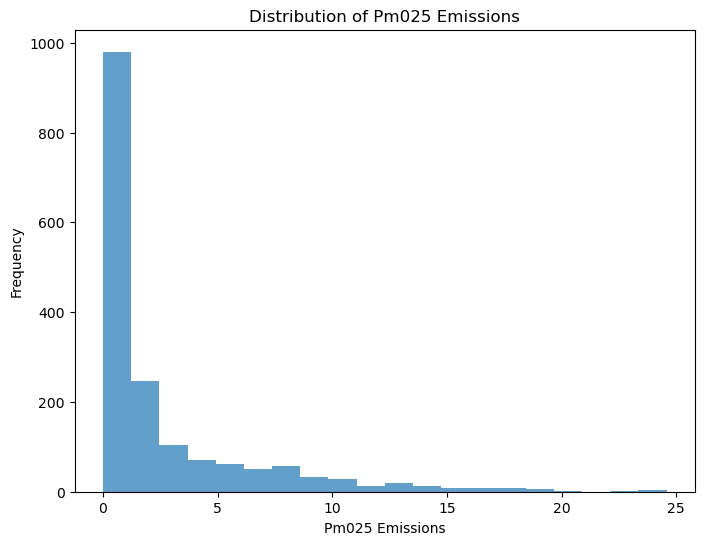

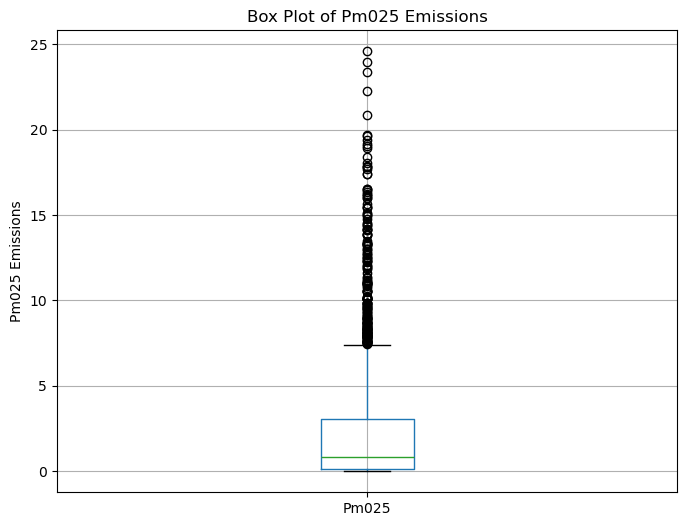


Pm025 Emissions by Borough and Year:
Borough               Year
Barking and Dagenham  2013    26.414614
                      2016    24.461445
                      2019    22.221483
                      2025    18.641956
Barnet                2013    75.235559
                                ...    
Waltham Forest        2025    22.941086
Wandsworth            2013    35.103582
                      2016    31.918551
                      2019    24.782198
                      2025    18.782807
Name: Pm025, Length: 132, dtype: float64


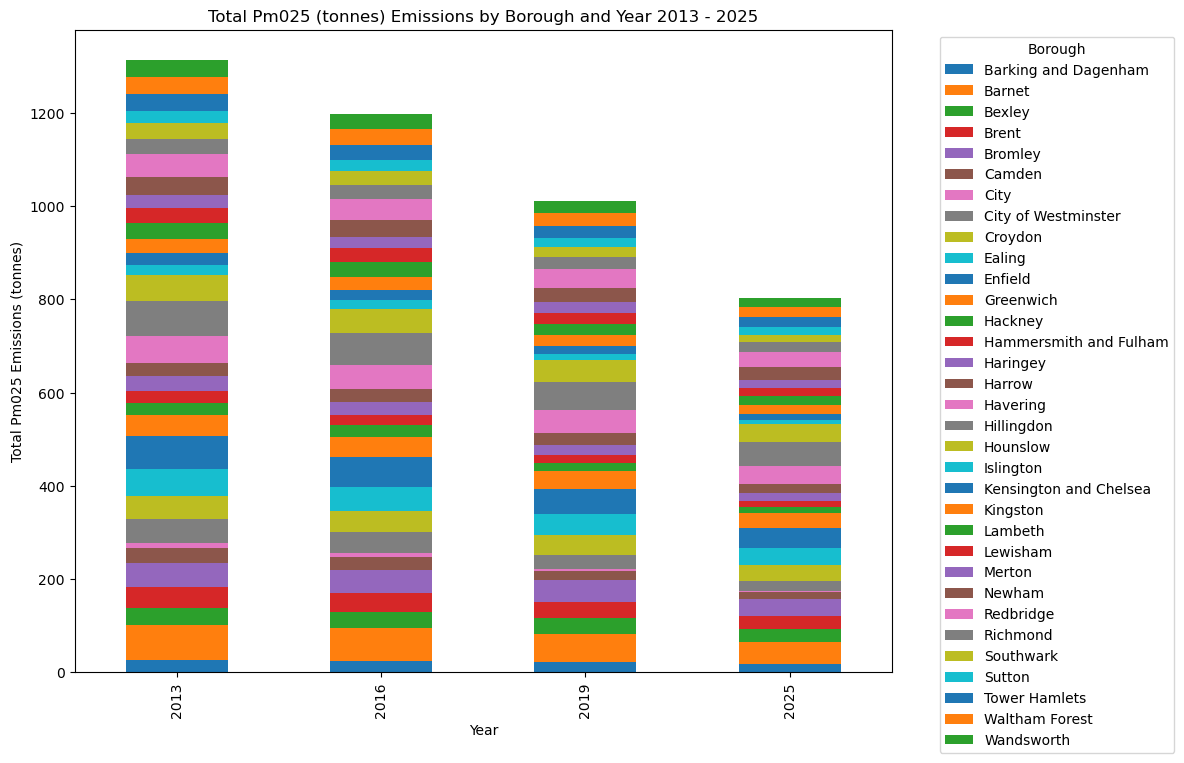


Pm025 Emissions by Transport Mode and Year:
Transport Mode       Year
Car - Diesel         2013    386.887537
                     2016    355.514039
                     2019    295.597848
                     2025    143.624360
Car - Electric       2013      0.154559
                     2016      0.815897
                     2019      1.909453
                     2025     34.051441
Car - Petrol         2013    316.460142
                     2016    303.061741
                     2019    278.562038
                     2025    265.069341
HGV - Articulated    2013     49.800333
                     2016     42.728318
                     2019     33.766052
                     2025     28.171902
HGV - Rigid          2013    104.309559
                     2016     94.154731
                     2019     81.003837
                     2025     68.639288
LGV - Diesel         2013    274.803532
                     2016    235.868460
                     2019    182.758984
         

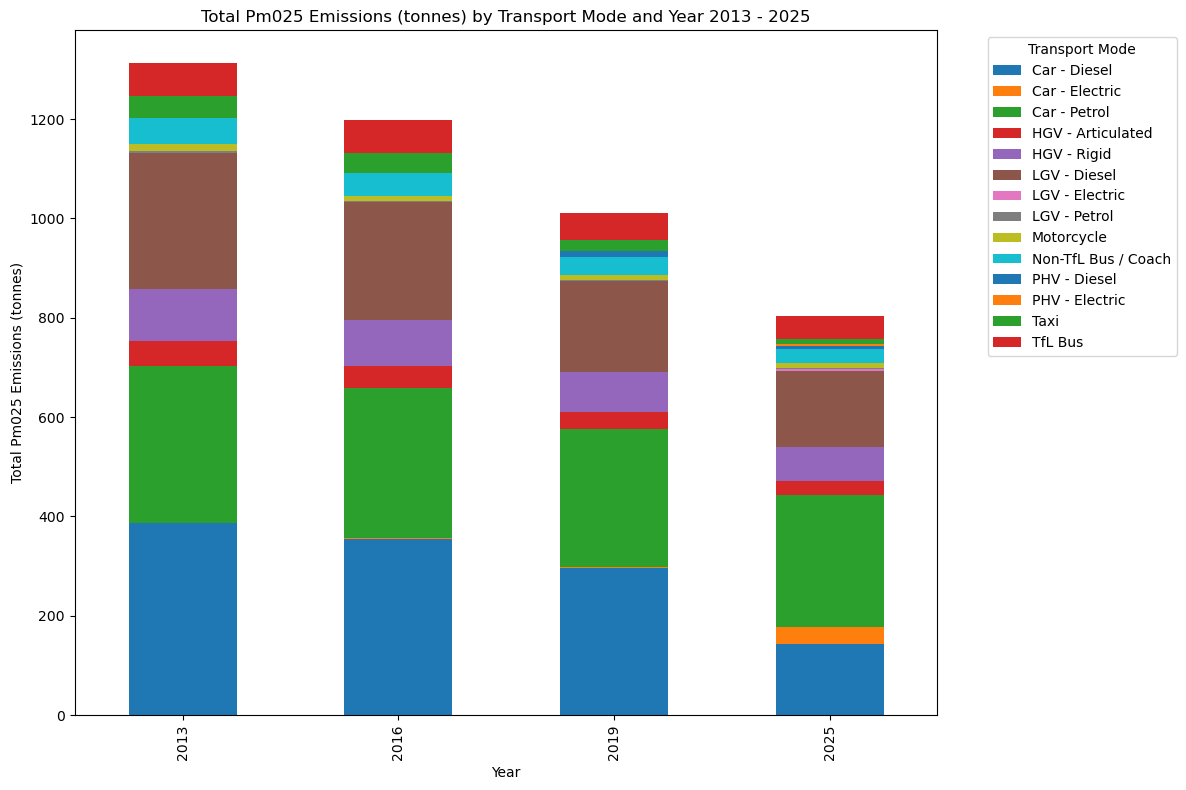


Top 5 Boroughs with Highest Pm025 Emissions:
Borough
Hillingdon    255.712424
Barnet        250.404607
Enfield       230.742310
Havering      199.962402
Ealing        193.309821
Name: Pm025, dtype: float64

Top 5 Transport Modes with Highest Pm025 Emissions:
Transport Mode
Car - Diesel    1181.623785
Car - Petrol    1163.153261
LGV - Diesel     846.075600
HGV - Rigid      348.107415
TfL Bus          233.187577
Name: Pm025, dtype: float64


In [735]:
#Descriptive Statistics for Pm025
print("Overall Pm025 Descriptive Statistics:")
print(combined_pm025_df['Pm025'].describe())

plt.figure(figsize=(8, 6))
plt.hist(combined_pm025_df['Pm025'], bins=20, alpha=0.7)
plt.xlabel('Pm025 Emissions')
plt.ylabel('Frequency')
plt.title('Distribution of Pm025 Emissions')
plt.show()

plt.figure(figsize=(8, 6))
combined_pm025_df.boxplot(column='Pm025')
plt.ylabel('Pm025 Emissions')
plt.title('Box Plot of Pm025 Emissions')
plt.show()


print("\nPm025 Emissions by Borough and Year:")
print(combined_pm025_df.groupby(['Borough', 'Year'])['Pm025'].sum())

# Visualisation
borough_year_pm025 = combined_pm025_df.groupby(['Borough', 'Year'])['Pm025'].sum().reset_index()
plt.figure(figsize=(12, 8))
borough_year_pm025.pivot(index='Year', columns='Borough', values='Pm025').plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('Year')
plt.ylabel('Total Pm025 Emissions (tonnes)')
plt.title('Total Pm025 (tonnes) Emissions by Borough and Year 2013 - 2025')
plt.legend(title='Borough', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



print("\nPm025 Emissions by Transport Mode and Year:")
print(combined_pm025_df.groupby(['Transport Mode', 'Year'])['Pm025'].sum())

# Visualisation
mode_year_pm025 = combined_pm025_df.groupby(['Transport Mode', 'Year'])['Pm025'].sum().reset_index()
plt.figure(figsize=(12, 8))
mode_year_pm025.pivot(index='Year', columns='Transport Mode', values='Pm025').plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('Year')
plt.ylabel('Total Pm025 Emissions (tonnes)')
plt.title('Total Pm025 Emissions (tonnes) by Transport Mode and Year 2013 - 2025')
plt.legend(title='Transport Mode', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Top borough analysis for Pm025
n = 5
top_boroughs_pm025 = combined_pm025_df.groupby('Borough')['Pm025'].sum().nlargest(n)
print(f"\nTop {n} Boroughs with Highest Pm025 Emissions:")
print(top_boroughs_pm025)

top_modes_pm025 = combined_pm025_df.groupby('Transport Mode')['Pm025'].sum().nlargest(n)
print(f"\nTop {n} Transport Modes with Highest Pm025 Emissions:")
print(top_modes_pm025)

In [736]:
#c02 2013
LAEI_co2_2013 = pd.read_excel('Copy of LAEI-2019-Emissions-Summary-including-Forecast.xlsx', 13, header=7)
print(LAEI_co2_2013)

    Unnamed: 0                     Source       Central         Inner  \
0          NaN                   Domestic  1.382520e+05  3.096126e+06   
1          NaN                    Biomass           NaN           NaN   
2          NaN               Wood Burning           NaN           NaN   
3          NaN  Heat and Power Generation  1.382493e+05  3.095668e+06   
4          NaN             Gas Combustion  1.353264e+05  3.061667e+06   
..         ...                        ...           ...           ...   
60         NaN             PHV - Electric  0.000000e+00  0.000000e+00   
61         NaN               PHV - Petrol  1.009804e+04  4.267425e+04   
62         NaN                       Taxi  3.659196e+04  7.955358e+04   
63         NaN                    TfL Bus  2.505514e+04  1.980431e+05   
64         NaN         LAEI (Grand Total)  1.194557e+06  7.937648e+06   

           Outer    Unnamed: 5    Unnamed: 6    Unnamed: 7  Unnamed: 8  \
0   5.309987e+06  8.544366e+06  1.321473e+06  9.8

In [737]:
new_LAEI_co2_2013 = LAEI_co2_2013.drop(columns=[ 'Unnamed: 0', 'Source', 'Central', 'Inner', 'Outer', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'])


In [738]:
new_LAEI_co2_2013.drop(new_LAEI_co2_2013.index[0:48], inplace=True)

In [739]:
new_LAEI_co2_2013.drop(new_LAEI_co2_2013.index[13], inplace=True)

In [740]:
new_LAEI_co2_2013 = new_LAEI_co2_2013.reset_index()

In [741]:
new_LAEI_co2_2013_long= new_LAEI_co2_2013.melt(
    id_vars=['Row Labels'],    
    var_name='Borough',        
    value_name='co2'           
)


In [742]:
new_LAEI_co2_2013_long['Year'] = 2013

In [743]:
new_LAEI_co2_2013_long = new_LAEI_co2_2013_long.rename(columns={'Row Labels': 'Transport Mode'})

In [744]:
new_LAEI_co2_2013_long.drop(new_LAEI_co2_2013_long.index[0:16], inplace=True)

In [745]:
new_LAEI_co2_2013_long = new_LAEI_co2_2013_long.reset_index()

In [746]:
new_LAEI_co2_2013_long.drop(columns=['index'], inplace=True)

In [747]:
new_LAEI_co2_2013_long.drop(index=range(525, 560), inplace=True)

In [748]:
print(new_LAEI_co2_2013_long.head(20))

         Transport Mode               Borough            co2  Year
0        Road Transport  Barking and Dagenham  138616.518826  2013
1          Car - Diesel  Barking and Dagenham   26950.150993  2013
2        Car - Electric  Barking and Dagenham       0.000000  2013
3          Car - Petrol  Barking and Dagenham   50354.012461  2013
4     HGV - Articulated  Barking and Dagenham   13458.867661  2013
5           HGV - Rigid  Barking and Dagenham   17261.601587  2013
6          LGV - Diesel  Barking and Dagenham   17115.503737  2013
7        LGV - Electric  Barking and Dagenham       0.000000  2013
8          LGV - Petrol  Barking and Dagenham     362.282953  2013
9            Motorcycle  Barking and Dagenham     745.846383  2013
10  Non-TfL Bus / Coach  Barking and Dagenham    3515.628135  2013
11                 Taxi  Barking and Dagenham     532.991315  2013
12              TfL Bus  Barking and Dagenham    8319.633600  2013
13                  NaN  Barking and Dagenham            NaN  

In [749]:
print(new_LAEI_co2_2013_long.tail(20))

          Transport Mode         Borough            co2  Year
505           Motorcycle  Waltham Forest    1375.231085  2013
506  Non-TfL Bus / Coach  Waltham Forest    7117.756661  2013
507                 Taxi  Waltham Forest    5438.198460  2013
508              TfL Bus  Waltham Forest   15642.670546  2013
509                  NaN  Waltham Forest            NaN  2013
510                  NaN  Waltham Forest            NaN  2013
511                  NaN  Waltham Forest            NaN  2013
512       Road Transport      Wandsworth  181876.359380  2013
513         Car - Diesel      Wandsworth   35311.719127  2013
514       Car - Electric      Wandsworth       0.000000  2013
515         Car - Petrol      Wandsworth   66246.867627  2013
516    HGV - Articulated      Wandsworth    5349.290470  2013
517          HGV - Rigid      Wandsworth   15493.052234  2013
518         LGV - Diesel      Wandsworth   24643.800806  2013
519       LGV - Electric      Wandsworth       0.000000  2013
520     

In [750]:
#co2 2016
LAEI_co2_2016 = pd.read_excel('Copy of LAEI-2019-Emissions-Summary-including-Forecast.xlsx', 14, header=7)

In [751]:
new_LAEI_co2_2016 = LAEI_co2_2016.drop(columns=[ 'Unnamed: 0', 'Source', 'Central', 'Inner', 'Outer', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'])


In [752]:
new_LAEI_co2_2016.drop(new_LAEI_co2_2016.index[0:48], inplace=True)

In [753]:
new_LAEI_co2_2016.drop(new_LAEI_co2_2016.index[13], inplace=True)

In [754]:
new_LAEI_co2_2016 = new_LAEI_co2_2016.reset_index()

In [755]:
new_LAEI_co2_2016_long= new_LAEI_co2_2016.melt(
    id_vars=['Row Labels'],    
    var_name='Borough',        
    value_name='co2'           
)


In [756]:
new_LAEI_co2_2016_long['Year'] = 2016

In [757]:
new_LAEI_co2_2016_long = new_LAEI_co2_2016_long.rename(columns={'Row Labels': 'Transport Mode'})

In [758]:
new_LAEI_co2_2016_long.drop(new_LAEI_co2_2016_long.index[0:16], inplace=True)

In [759]:
new_LAEI_co2_2016_long = new_LAEI_co2_2016_long.reset_index()

In [760]:
new_LAEI_co2_2016_long.drop(columns=['index'], inplace=True)

In [761]:
new_LAEI_co2_2016_long.drop(index=range(525, 560), inplace=True)

In [762]:
#co2 2019
LAEI_co2_2019 = pd.read_excel('Copy of LAEI-2019-Emissions-Summary-including-Forecast.xlsx', 15, header=7)

In [763]:
new_LAEI_co2_2019 = LAEI_co2_2019.drop(columns=[ 'Unnamed: 0', 'Source', 'Central', 'Inner', 'Outer', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'])


In [764]:
new_LAEI_co2_2019.drop(new_LAEI_co2_2019.index[0:48], inplace=True)

In [765]:
new_LAEI_co2_2019.drop(new_LAEI_co2_2019.index[13], inplace=True)

In [766]:
new_LAEI_co2_2019 = new_LAEI_co2_2019.reset_index()

In [767]:
new_LAEI_co2_2019_long= new_LAEI_co2_2019.melt(
    id_vars=['Row Labels'],    
    var_name='Borough',        
    value_name='co2'           
)


In [768]:
new_LAEI_co2_2019_long['Year'] = 2019

In [769]:
new_LAEI_co2_2019_long = new_LAEI_co2_2019_long.rename(columns={'Row Labels': 'Transport Mode'})

In [770]:
new_LAEI_co2_2019_long.drop(new_LAEI_co2_2019_long.index[0:16], inplace=True)

In [771]:
new_LAEI_co2_2019_long = new_LAEI_co2_2019_long.reset_index()

In [772]:
new_LAEI_co2_2019_long.drop(columns=['index'], inplace=True)

In [773]:
new_LAEI_co2_2019_long.drop(index=range(525, 560), inplace=True)

In [774]:
#co2 2025
LAEI_co2_2025 = pd.read_excel('Copy of LAEI-2019-Emissions-Summary-including-Forecast.xlsx', 16, header=7)

In [775]:
new_LAEI_co2_2025 = LAEI_co2_2025.drop(columns=[ 'Unnamed: 0', 'Source', 'Central', 'Inner', 'Outer', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'])

In [776]:
new_LAEI_co2_2025.drop(new_LAEI_co2_2025.index[0:48], inplace=True)

In [777]:
new_LAEI_co2_2025.drop(new_LAEI_co2_2025.index[13], inplace=True)

In [778]:
new_LAEI_co2_2025 = new_LAEI_co2_2025.reset_index()

In [779]:
new_LAEI_co2_2025_long= new_LAEI_co2_2025.melt(
    id_vars=['Row Labels'],    
    var_name='Borough',        
    value_name='co2'           
)

In [780]:
new_LAEI_co2_2025_long['Year'] = 2025

In [781]:
new_LAEI_co2_2025_long = new_LAEI_co2_2025_long.rename(columns={'Row Labels': 'Transport Mode'})

In [782]:
new_LAEI_co2_2025_long.drop(new_LAEI_co2_2025_long.index[0:16], inplace=True)

In [783]:
new_LAEI_co2_2025_long = new_LAEI_co2_2025_long.reset_index()

In [784]:
new_LAEI_co2_2025_long.drop(columns=['index'], inplace=True)

In [785]:
new_LAEI_co2_2025_long.drop(index=range(525, 560), inplace=True)

In [786]:
#combining into one big co2 dataframe
dataframes = [new_LAEI_co2_2013_long,
              new_LAEI_co2_2016_long,
              new_LAEI_co2_2019_long,
              new_LAEI_co2_2025_long]

In [787]:
combined_co2_df = pd.concat(dataframes, ignore_index=True)

In [788]:
combined_co2_df = combined_co2_df[~combined_co2_df['Transport Mode'].isin(modes_to_remove)]

In [789]:
print(combined_co2_df.head())
print(combined_co2_df.tail())
print(f"Shape of the combined DataFrame: {combined_co2_df.shape}")

      Transport Mode               Borough           co2  Year
1       Car - Diesel  Barking and Dagenham  26950.150993  2013
2     Car - Electric  Barking and Dagenham      0.000000  2013
3       Car - Petrol  Barking and Dagenham  50354.012461  2013
4  HGV - Articulated  Barking and Dagenham  13458.867661  2013
5        HGV - Rigid  Barking and Dagenham  17261.601587  2013
           Transport Mode     Borough          co2  Year
2095         LGV - Petrol  Wandsworth   398.097903  2025
2096           Motorcycle  Wandsworth  1734.909479  2025
2097  Non-TfL Bus / Coach  Wandsworth  9305.397210  2025
2098         PHV - Diesel  Wandsworth  1053.396009  2025
2099       PHV - Electric  Wandsworth     0.000000  2025
Shape of the combined DataFrame: (1904, 4)


Overall co2 Descriptive Statistics:
count      1712.000000
mean      14841.640971
std       22454.430719
min           0.000000
25%         526.354442
50%        5630.075989
75%       19451.546871
max      164199.096922
Name: co2, dtype: float64


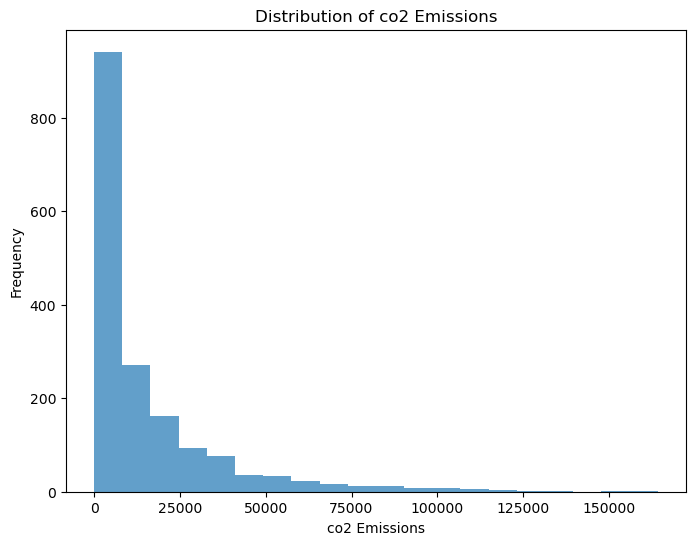

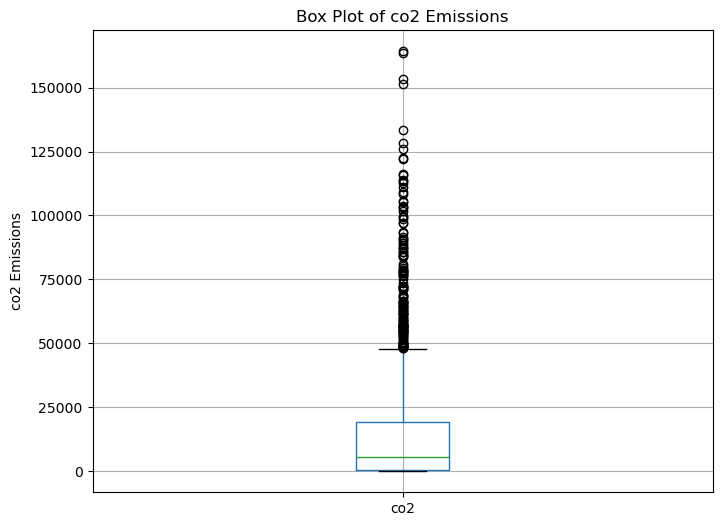


co2 Emissions by Borough and Year:
Borough               Year
Barking and Dagenham  2013    138616.518826
                      2016    138920.635958
                      2019    135591.687575
                      2025    119613.113732
Barnet                2013    410896.580475
                                  ...      
Waltham Forest        2025    135681.775764
Wandsworth            2013    181876.359380
                      2016    177092.049343
                      2019    145055.775817
                      2025    117668.102837
Name: co2, Length: 132, dtype: float64


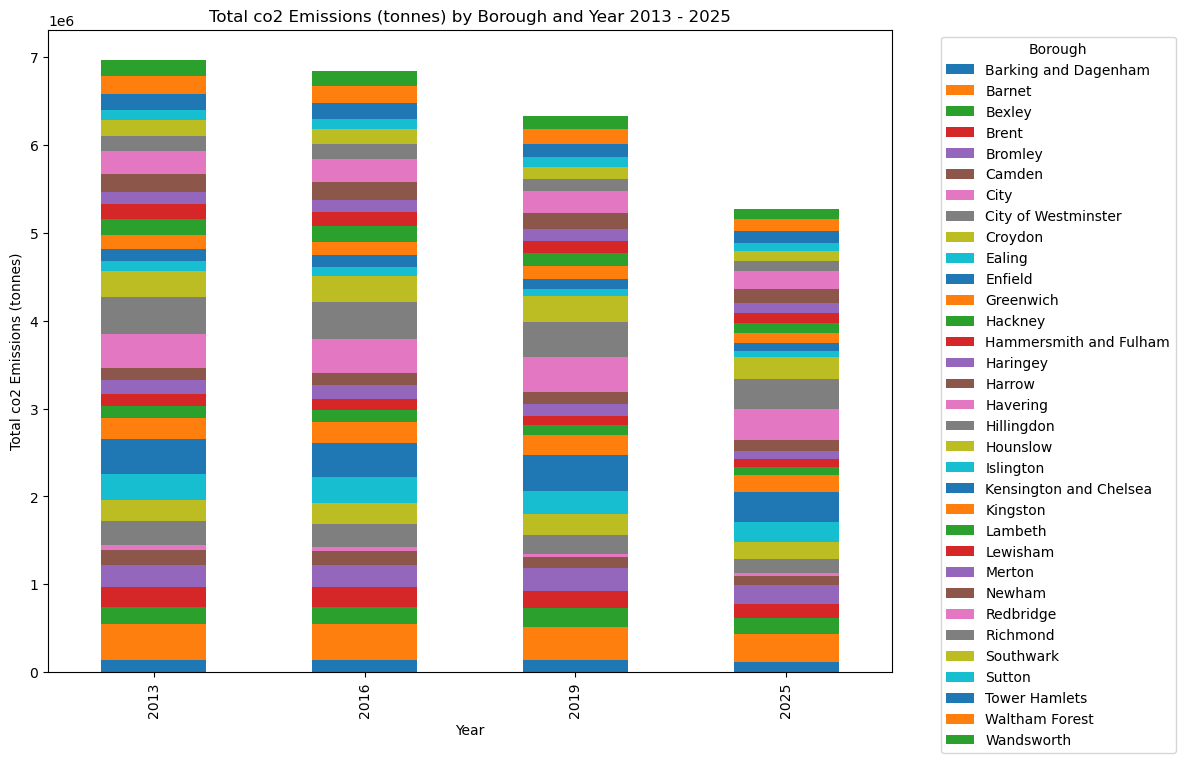


co2 Emissions by Transport Mode and Year:
Transport Mode       Year
Car - Diesel         2013    1.377582e+06
                     2016    1.455101e+06
                     2019    1.325210e+06
                     2025    7.716634e+05
Car - Electric       2013    0.000000e+00
                     2016    0.000000e+00
                     2019    0.000000e+00
                     2025    0.000000e+00
Car - Petrol         2013    2.530545e+06
                     2016    2.290660e+06
                     2019    1.955459e+06
                     2025    1.790239e+06
HGV - Articulated    2013    4.252353e+05
                     2016    4.290534e+05
                     2019    4.073839e+05
                     2025    3.807907e+05
HGV - Rigid          2013    5.876590e+05
                     2016    6.026957e+05
                     2019    6.047389e+05
                     2025    5.701081e+05
LGV - Diesel         2013    8.590927e+05
                     2016    9.170431e+05
       

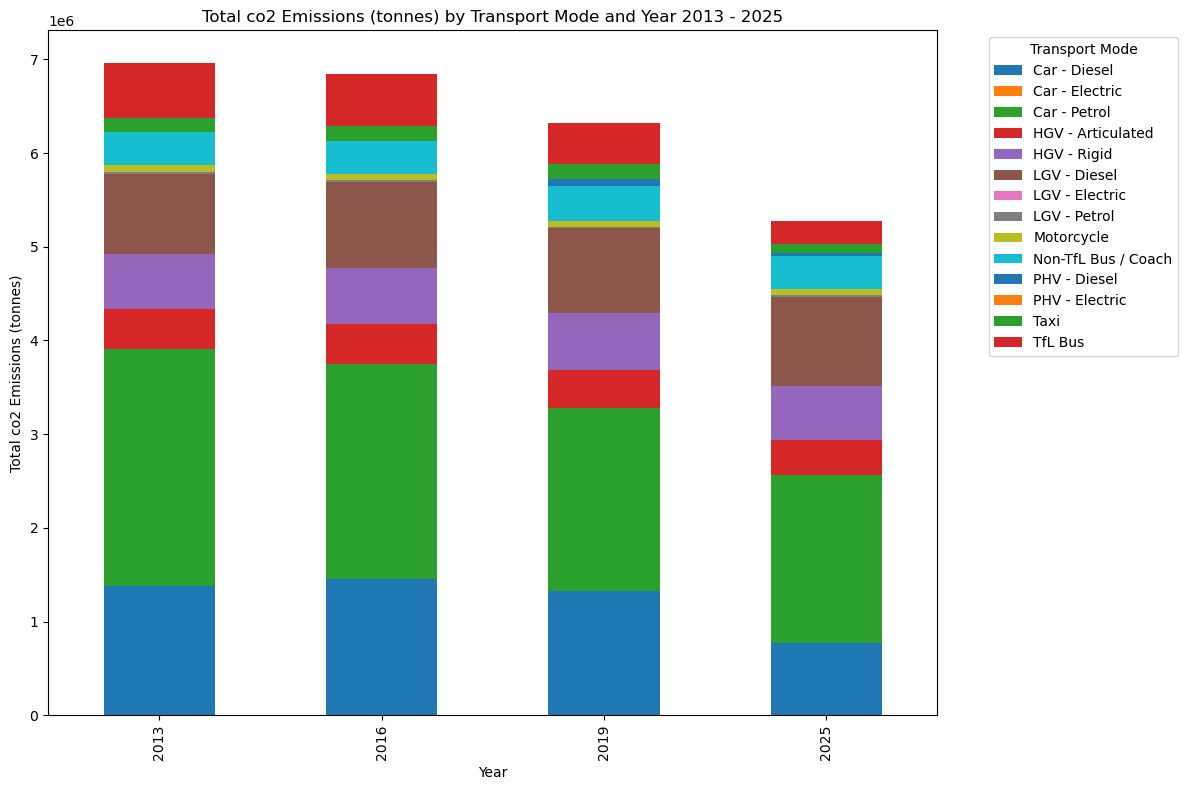


Top 5 Boroughs with Highest co2 Emissions:
Borough
Hillingdon    1.588487e+06
Enfield       1.531680e+06
Havering      1.529607e+06
Barnet        1.520525e+06
Hounslow      1.130081e+06
Name: co2, dtype: float64

Top 5 Transport Modes with Highest co2 Emissions:
Transport Mode
Car - Petrol    8.566903e+06
Car - Diesel    4.929555e+06
LGV - Diesel    3.634706e+06
HGV - Rigid     2.365202e+06
TfL Bus         1.842414e+06
Name: co2, dtype: float64


In [790]:
#Descriptive Statistics for co2
print("Overall co2 Descriptive Statistics:")
print(combined_co2_df['co2'].describe())

plt.figure(figsize=(8, 6))
plt.hist(combined_co2_df['co2'], bins=20, alpha=0.7)
plt.xlabel('co2 Emissions')
plt.ylabel('Frequency')
plt.title('Distribution of co2 Emissions')
plt.show()

plt.figure(figsize=(8, 6))
combined_co2_df.boxplot(column='co2')
plt.ylabel('co2 Emissions')
plt.title('Box Plot of co2 Emissions')
plt.show()


print("\nco2 Emissions by Borough and Year:")
print(combined_co2_df.groupby(['Borough', 'Year'])['co2'].sum())

# Visualisation
borough_year_co2 = combined_co2_df.groupby(['Borough', 'Year'])['co2'].sum().reset_index()
plt.figure(figsize=(12, 8))
borough_year_co2.pivot(index='Year', columns='Borough', values='co2').plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('Year')
plt.ylabel('Total co2 Emissions (tonnes)')
plt.title('Total co2 Emissions (tonnes) by Borough and Year 2013 - 2025')
plt.legend(title='Borough', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



print("\nco2 Emissions by Transport Mode and Year:")
print(combined_co2_df.groupby(['Transport Mode', 'Year'])['co2'].sum())

# Visualisation
mode_year_co2 = combined_co2_df.groupby(['Transport Mode', 'Year'])['co2'].sum().reset_index()
plt.figure(figsize=(12, 8))
mode_year_co2.pivot(index='Year', columns='Transport Mode', values='co2').plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('Year')
plt.ylabel('Total co2 Emissions (tonnes)')
plt.title('Total co2 Emissions (tonnes) by Transport Mode and Year 2013 - 2025')
plt.legend(title='Transport Mode', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Top borough analysis for co2
n = 5
top_boroughs_co2 = combined_co2_df.groupby('Borough')['co2'].sum().nlargest(n)
print(f"\nTop {n} Boroughs with Highest co2 Emissions:")
print(top_boroughs_co2)

top_modes_co2 = combined_co2_df.groupby('Transport Mode')['co2'].sum().nlargest(n)
print(f"\nTop {n} Transport Modes with Highest co2 Emissions:")
print(top_modes_co2)

# Combining all graphs

In [791]:
dataframes = [combined_nox_df, combined_pm10_df, combined_pm025_df, combined_co2_df]

In [792]:
all_ghg_combined = pd.concat(dataframes, ignore_index=True)

In [793]:
print(f"Shape of the combined DataFrame: {all_ghg_combined.shape}")

Shape of the combined DataFrame: (7397, 7)


In [794]:
combined_nox_df

Transport Mode               Borough         NOx  Year
1            Car - Diesel  Barking and Dagenham  122.771048  2013
2          Car - Electric  Barking and Dagenham    0.000000  2013
3            Car - Petrol  Barking and Dagenham   40.104403  2013
4       HGV - Articulated  Barking and Dagenham   43.438257  2013
5             HGV - Rigid  Barking and Dagenham   73.887258  2013
...                   ...                   ...         ...   ...
1873         LGV - Petrol            Wandsworth    0.178208  2025
1874           Motorcycle            Wandsworth    1.102324  2025
1875  Non-TfL Bus / Coach            Wandsworth    1.863367  2025
1876                 Taxi            Wandsworth    1.208521  2025
1877              TfL Bus            Wandsworth    4.044666  2025

[1685 rows x 4 columns]

In [795]:
combined_pm025_df

Transport Mode               Borough     Pm025  Year
1            Car - Diesel  Barking and Dagenham  7.783286  2013
2          Car - Electric  Barking and Dagenham  0.003229  2013
3            Car - Petrol  Barking and Dagenham  6.528639  2013
4       HGV - Articulated  Barking and Dagenham  1.671496  2013
5             HGV - Rigid  Barking and Dagenham  2.852336  2013
...                   ...                   ...       ...   ...
2095         LGV - Petrol            Wandsworth  0.071783  2025
2096           Motorcycle            Wandsworth  0.263618  2025
2097  Non-TfL Bus / Coach            Wandsworth  0.728600  2025
2098         PHV - Diesel            Wandsworth  0.184451  2025
2099       PHV - Electric            Wandsworth  0.134270  2025

[1904 rows x 4 columns]

In [796]:
combined_pm10_df

Transport Mode               Borough       Pm10  Year
1            Car - Diesel  Barking and Dagenham  12.304775  2013
2          Car - Electric  Barking and Dagenham   0.007073  2013
3            Car - Petrol  Barking and Dagenham  13.802089  2013
4       HGV - Articulated  Barking and Dagenham   2.846585  2013
5             HGV - Rigid  Barking and Dagenham   5.365921  2013
...                   ...                   ...        ...   ...
2095         LGV - Petrol            Wandsworth   0.151390  2025
2096           Motorcycle            Wandsworth   0.492426  2025
2097  Non-TfL Bus / Coach            Wandsworth   1.606608  2025
2098         PHV - Diesel            Wandsworth   0.379396  2025
2099       PHV - Electric            Wandsworth   0.225672  2025

[1904 rows x 4 columns]

In [797]:
combined_co2_df

Transport Mode               Borough           co2  Year
1            Car - Diesel  Barking and Dagenham  26950.150993  2013
2          Car - Electric  Barking and Dagenham      0.000000  2013
3            Car - Petrol  Barking and Dagenham  50354.012461  2013
4       HGV - Articulated  Barking and Dagenham  13458.867661  2013
5             HGV - Rigid  Barking and Dagenham  17261.601587  2013
...                   ...                   ...           ...   ...
2095         LGV - Petrol            Wandsworth    398.097903  2025
2096           Motorcycle            Wandsworth   1734.909479  2025
2097  Non-TfL Bus / Coach            Wandsworth   9305.397210  2025
2098         PHV - Diesel            Wandsworth   1053.396009  2025
2099       PHV - Electric            Wandsworth      0.000000  2025

[1904 rows x 4 columns]

In [798]:
print(combined_nox_df.columns)

Index(['Transport Mode', 'Borough', 'NOx', 'Year'], dtype='object')


In [808]:
merged_df = pd.concat([combined_nox_df, combined_pm025_df, combined_pm10_df, combined_co2_df], ignore_index=True)

In [801]:
merged_df['Borough'].unique()

array(['Barking and Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley',
       'Camden', 'City', 'City of Westminster', 'Croydon', 'Ealing',
       'Enfield', 'Greenwich', 'Hackney', 'Hammersmith and Fulham',
       'Haringey', 'Harrow', 'Havering', 'Hillingdon', 'Hounslow',
       'Islington', 'Kensington and Chelsea', 'Kingston', 'Lambeth',
       'Lewisham', 'Merton', 'Newham', 'Redbridge', 'Richmond',
       'Southwark', 'Sutton', 'Tower Hamlets', 'Waltham Forest',
       'Wandsworth'], dtype=object)

In [ ]:
combined_nox_df['Pollutant'] = 'NOx'

combined_pm025_df['Pollutant'] = 'Pm025'

combined_pm10_df['Pollutant'] = 'Pm10'

combined_co2_df['Pollutant'] = 'co2'



common_columns = ['Transport Mode', 'Borough', 'Year', 'Pollutant']


combined_nox_df = combined_nox_df[common_columns + ['NOx']].rename(columns={'NOx': 'Emissions'})

combined_pm025_df = combined_pm025_df[common_columns + ['Pm025']].rename(columns={'Pm025': 'Emissions'})

combined_pm10_df = combined_pm10_df[common_columns + ['Pm10']].rename(columns={'Pm10': 'Emissions'})

combined_co2_df = combined_co2_df[common_columns + ['co2']].rename(columns={'co2': 'Emissions'})



C:\Users\harve\AppData\Local\Temp\ipykernel_15968\2540995813.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
merged_df = pd.concat([combined_nox_df, combined_pm025_df, combined_pm10_df, combined_co2_df], ignore_index=True)

              Year      Emissions
count  7397.000000    6821.000000
mean   2018.133297    3733.735409
std       4.393912   12955.563782
min    2013.000000       0.000000
25%    2013.000000       0.251915
50%    2016.000000       3.066923
75%    2019.000000      44.381174
max    2025.000000  164199.096922
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7397 entries, 0 to 7396
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Transport Mode  6821 non-null   object 
 1   Borough         7397 non-null   object 
 2   Year            7397 non-null   int64  
 3   Pollutant       7397 non-null   object 
 4   Emissions       6821 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 289.1+ KB
None
Pollutant
co2      2.540889e+07
NOx      4.646035e+04
Pm10     8.134481e+03
Pm025    4.325046e+03
Name: Emissions, dtype: float64
Pollutant           NOx        Pm025         Pm10           co2
Year      

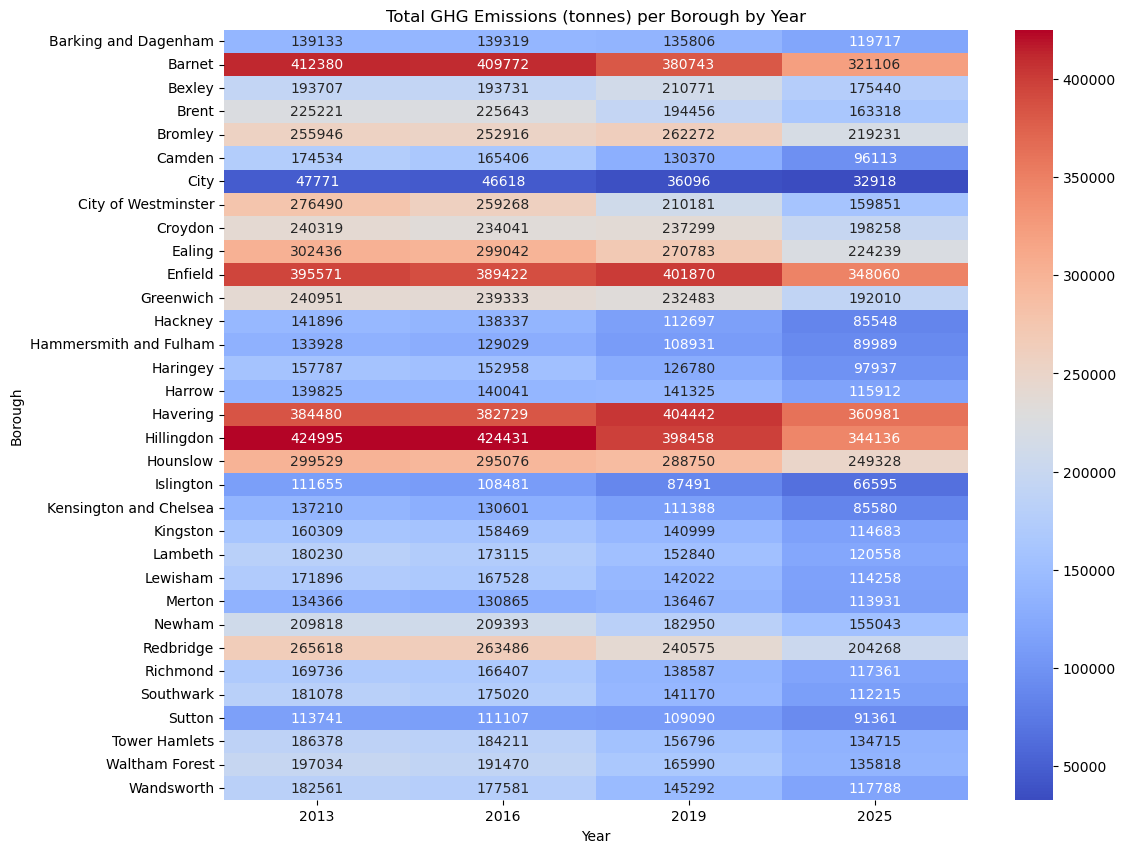

In [809]:
print(merged_df.describe())
print(merged_df.info())

#Total emissions per pollutant
pollutant_summary = merged_df.groupby('Pollutant')['Emissions'].sum().sort_values(ascending=False)
print(pollutant_summary)

#Emissions by year and pollutant
year_pollutant = merged_df.groupby(['Year', 'Pollutant'])['Emissions'].sum().unstack()
print(year_pollutant)

#Top 5 boroughs with highest emissions overall
top_boroughs = merged_df.groupby('Borough')['Emissions'].sum().sort_values(ascending=False).head(5)
print(top_boroughs)

#Heatmap of emissions across borough and year
pivot = merged_df.pivot_table(values='Emissions', index='Borough', columns='Year', aggfunc='sum')
plt.figure(figsize=(12,10))
sns.heatmap(pivot, cmap='coolwarm', annot=True, fmt='.0f')
plt.title('Total GHG Emissions (tonnes) per Borough by Year')
plt.show()


In [810]:
future_year = 2050
predictions = {}

for pollutant in merged_df['Pollutant'].unique():
    pollutant_df = merged_df[merged_df['Pollutant'] == pollutant]
    yearly = pollutant_df.groupby('Year')['Emissions'].sum().reset_index()
    
    X = yearly['Year'].values.reshape(-1,1)
    y = yearly['Emissions'].values
    
    model = LinearRegression()
    model.fit(X, y)
    
    pred = model.predict(np.array([[future_year]]))[0]
    predictions[pollutant] = pred

print(f"Predicted emissions for {future_year}:")
for pollutant, value in predictions.items():
    print(f"{pollutant}: {value:.2f}")


Predicted emissions for 2050:
NOx: -41577.86
Pm025: -292.37
Pm10: 287.11
co2: 1669116.40


In [ ]:
X_train

Year  Month  Days in period
165  2022     12              28
38   2013      3              29
19   2011      9              28
58   2014      9              28
48   2013     12              28
..    ...    ...             ...
78   2016      4              30
113  2018     12              28
21   2011     11              28
99   2017     11              28
109  2018      8              28

[143 rows x 3 columns]

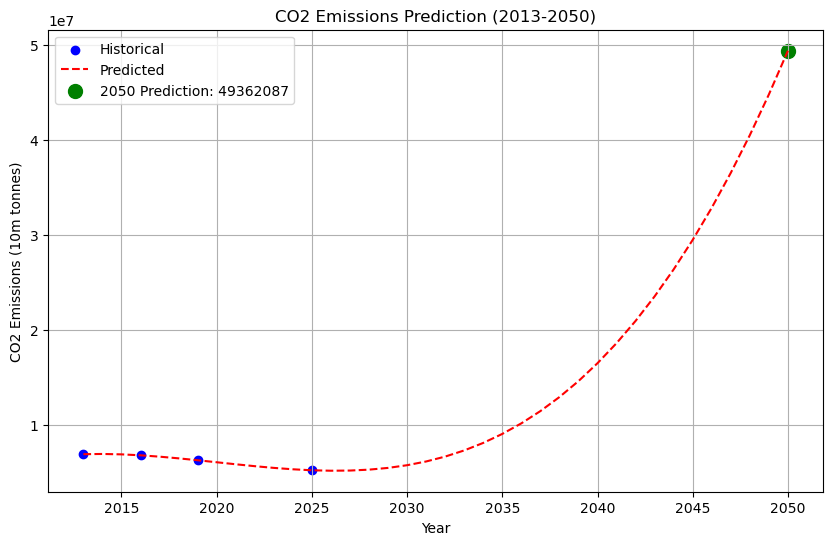


 Predicted CO2 Emissions for 2050: 49362086.52


In [ ]:
future_years = np.arange(2013, 2051).reshape(-1, 1)
degree = 3  

co2_df = merged_df[merged_df['Pollutant'] == 'co2']
yearly_co2 = co2_df.groupby('Year')['Emissions'].sum().reset_index()

X_train_co2 = yearly_co2['Year'].values.reshape(-1, 1)
y_train_co2 = yearly_co2['Emissions'].values

poly_model_co2 = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_model_co2.fit(X_train_co2, y_train_co2)

predicted_co2 = poly_model_co2.predict(future_years)
predicted_co2 = np.clip(predicted_co2, 0, None)

plt.figure(figsize=(10, 6))
plt.scatter(X_train_co2, y_train_co2, color='blue', label='Historical')
plt.plot(future_years, predicted_co2, color='red', linestyle='--', label='Predicted')
plt.scatter(2050, predicted_co2[-1], color='green', s=100, label=f'2050 Prediction: {predicted_co2[-1]:.0f}')
plt.title('CO2 Emissions Prediction (2013-2050)')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (10m tonnes)')
plt.legend()
plt.grid(True)
plt.show()

print(f"\n Predicted CO2 Emissions for 2050: {predicted_co2[-1]:.2f}")

In [ ]:
zero_carbon = pd.read_excel('Datastore_Zero Carbon Pathways Tool_v1.3.xlsm', sheet_name='Sheet2', header=1)

In [ ]:
zero_carbon

Sector  2015  2020  2025  2030  2035  2040  2045  2050
0  Electricity (Cars, LGVs, M)    34   142  1312  3278  4635  4963  5057  4967
1     Hydrogen (Cars, LGVs, M)     0     0     2    23   113   274   457   619
2       Petrol (Cars, LGVs, M)  3648  3528  2881  1789   806   265    78    11
3       Diesel (Cars, LGVs, M)  3663  3397  2615  1382   505   131    23     2
4              HGVs - hydrogen     0     0     0     5    24    47    56    55
5                HGVs - diesel   395   392   400   381   263   116    30     3
6             Buses - hydrogen     0     0     0     7    16    24    28    27
7               Buses - diesel   230   223   164    74    46    20     6     1
8         Buses - electricity      3     5    68   151   170   189   200   206

In [ ]:
# Melting the dataframe to long format from wide
zero_carbon_melted = zero_carbon.melt(id_vars='Sector', var_name='Year', value_name='Value')
zero_carbon_melted['Year'] = pd.to_numeric(zero_carbon_melted['Year'])

#Initialising the chart
fig_area = px.area(zero_carbon_melted, x='Year', y='Value', color='Sector',
                  title='Stacked Area Chart by Transport Method (annual KM) 2015-2050',
                  labels={'Value': 'Value', 'Year': 'Year'})
fig_area.show()